In [1]:
import os
import torch
import h5py as h5
import numpy as np
import torch.nn as nn
from io import BytesIO
from tqdm import trange
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from os.path import join as path_join
from matplotlib.colors import Normalize

In [2]:
class Model(nn.Module):
    def __init__(self, n_features, dim_hidden, n_layers):
        super(Model, self).__init__()
        self.n_features = n_features
        self.dim_hidden = dim_hidden
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            n_features, hidden_size=dim_hidden, num_layers=n_layers, batch_first=True
        )
        self.dense = nn.Linear(in_features=dim_hidden, out_features=n_features)

    def forward(self, x, h_0=None, c_0=None):
        if h_0 is None:
            h_0 = torch.zeros(self.n_layers, x.shape[0], self.dim_hidden)
            c_0 = torch.zeros(self.n_layers, x.shape[0], self.dim_hidden)
        x, (h, c) = self.lstm(x, (h_0, c_0))
        return self.dense(x), (h, c)

In [3]:
def predict(model, X, batch_size):
    model.eval()
    for i in range(0, X.shape[0], batch_size):
        x = X[i : i + batch_size, :1, :]
        yhat = torch.zeros_like(X, dtype=X.dtype)
        h = torch.zeros(model.n_layers, batch_size, model.dim_hidden)
        c = torch.zeros(model.n_layers, batch_size, model.dim_hidden)
        for t in range(X.shape[1]):
            with torch.no_grad():
                yhat_t, (h, c) = model(x, h, c)
                x = yhat_t
                yhat[i : i + batch_size, t : t + 1, :] = yhat_t
    return yhat.numpy()

In [4]:
val_path = "/Users/reza/Career/DMLab/SURROGATE/data/pete_sample/test"
val_arrays = []
for h5_name in os.listdir(val_path):
    with h5.File(path_join(val_path, h5_name)) as h5_file:
        val_arrays.append(h5_file["Data"][:])
for i in range(len(val_arrays)):
    val_arrays[i] /= np.max(val_arrays[i])
for i in range(len(val_arrays)):
    val_arrays[i] = np.transpose(val_arrays[i], (2, 0, 1))
val_set = np.concatenate(val_arrays, axis=0)
val_X = val_set[:-1, :, :]
val_y = val_set[1:, :, :]
val_X = torch.tensor(val_X, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)

In [5]:
dim_k_val, dim_i, dim_j = val_X.shape
hidden_size = 64
num_layers = 1

In [6]:
model = Model(dim_j, hidden_size, num_layers)
model.load_state_dict(torch.load('/Users/reza/Career/DMLab/SURROGATE/results/laplace/LSTM/69.pth'))

/var/folders/bv/7h0f0hns2y72yqgg3ww8qkkm0000gn/T/ipykernel_4373/3359194070.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/Users/reza/

<All keys matched successfully>

In [7]:
yhat = predict(model, val_X, val_X.shape[0])

In [8]:
val_y = np.transpose(val_y, (1, 2, 0))
yhat = np.transpose(yhat, (1, 2, 0))

In [9]:
norm = Normalize(vmin=0.3, vmax=1.0)

In [10]:
frames = []

In [11]:
for step in trange(val_y.shape[2]):
    val = val_y[:, :, step]
    pred = yhat[:, :, step]
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.contourf(
        np.arange(val.shape[0]),
        np.arange(val.shape[1]),
        val.T,
        cmap="viridis",
        norm=norm,
    )
    plt.title(f"Actual Slice (k={step})")
    plt.colorbar()
    plt.xlabel("I")
    plt.ylabel("J")

    plt.subplot(1, 2, 2)
    plt.contourf(
        np.arange(pred.shape[0]),
        np.arange(pred.shape[1]),
        pred.T,
        cmap="viridis",
        norm=norm,
    )
    plt.title(f"Predicted Slice (k={step})")
    plt.colorbar()
    plt.xlabel("I")
    plt.ylabel("J")

    # plt.show()
    buf = BytesIO()
    plt.savefig(buf, format='png')
    frames.append(imageio.imread(buf))
    plt.close()

100%|██████████| 139/139 [01:07<00:00,  2.05it/s]


In [12]:
output_filename = f"plt.mp4"
fps = 10  # Adjust frames per second as needed

# Create video directly from frames in memory
with imageio.get_writer(output_filename, fps=fps) as writer:
    for frame in frames:
        writer.append_data(frame)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1200, 600) to (1200, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


# wrong

In [13]:
def wrong_predict(model, X, k_pred):
    model.eval()
    x = X[:1, :, :]
    yhats = []
    for i in range(k_pred):
        with torch.no_grad():
            yhat, _ = model(x)
            yhats.append(yhat.squeeze())
            x = yhat
    return np.array(yhats)

In [14]:
yhat = wrong_predict(model, val_X, val_X.shape[0])

In [15]:
yhat = yhat.transpose(1, 2, 0)

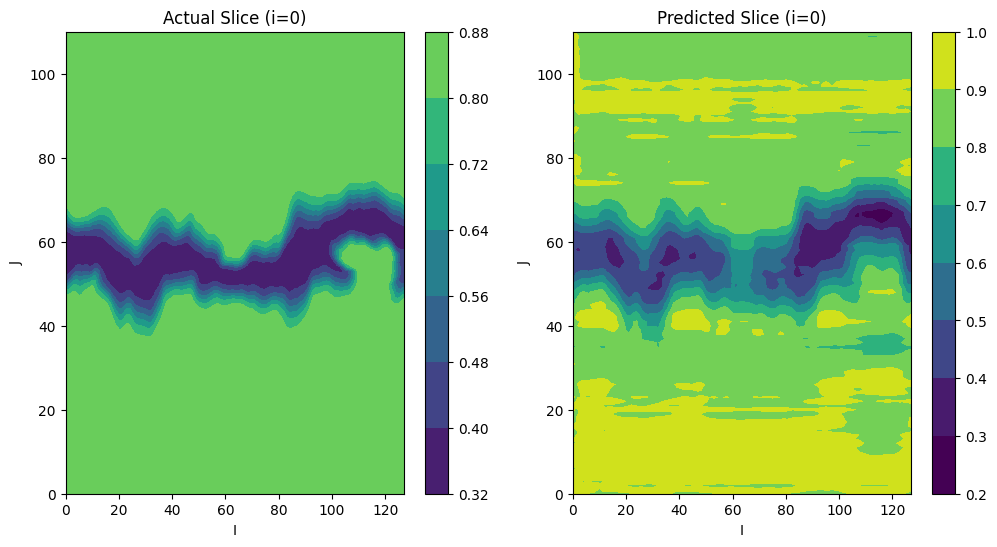

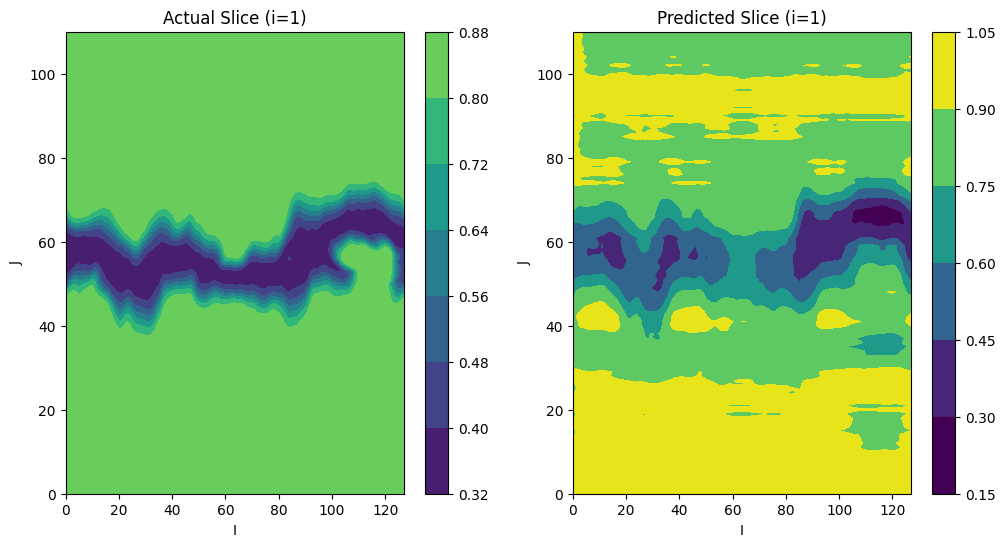

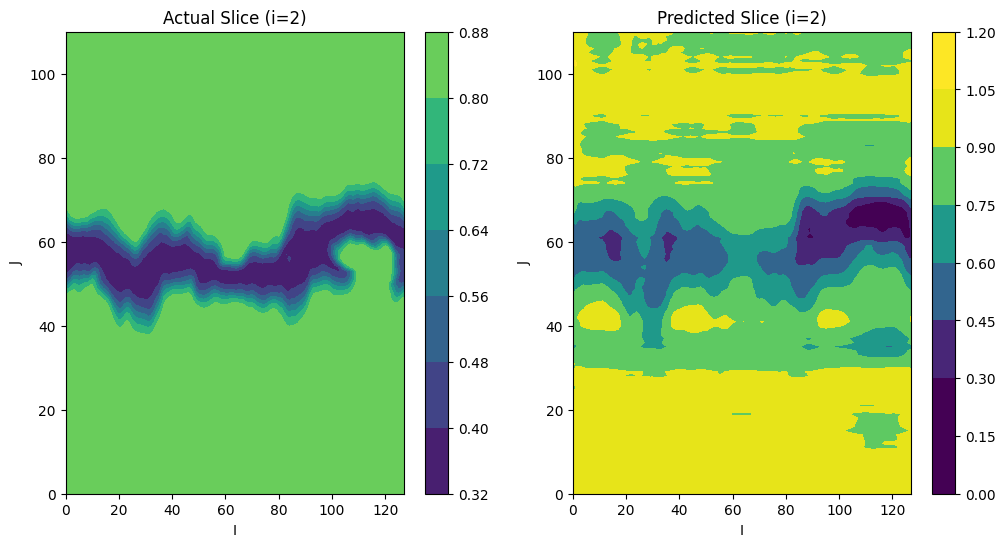

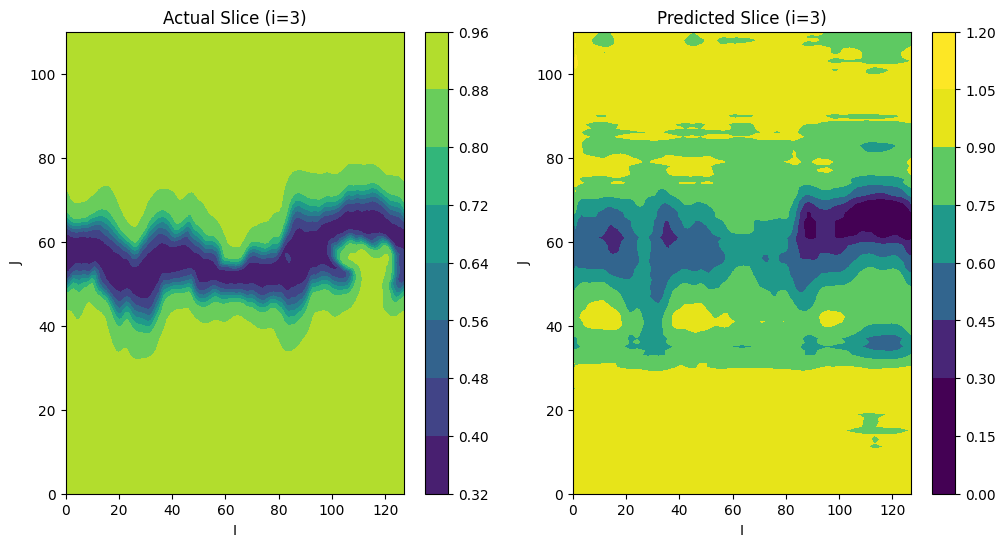

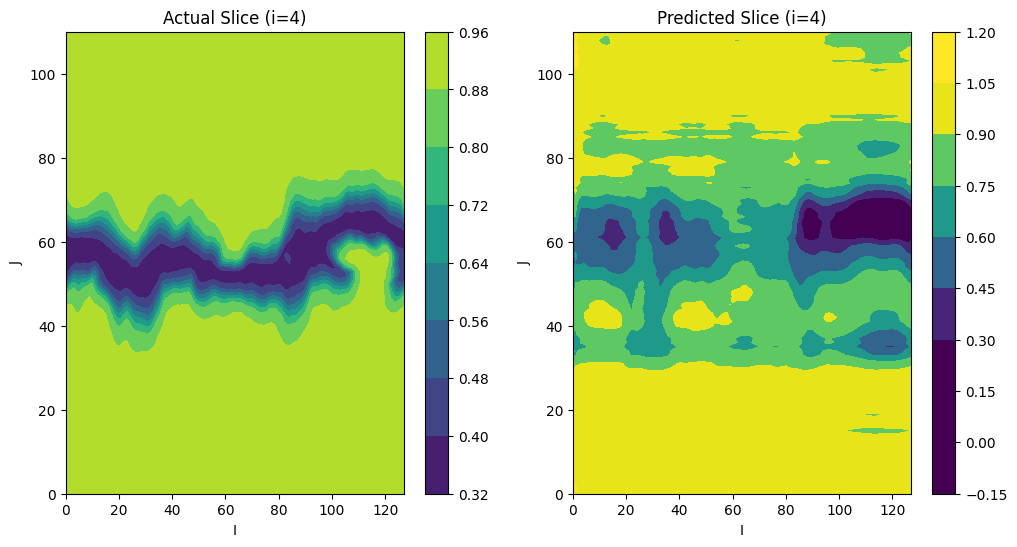

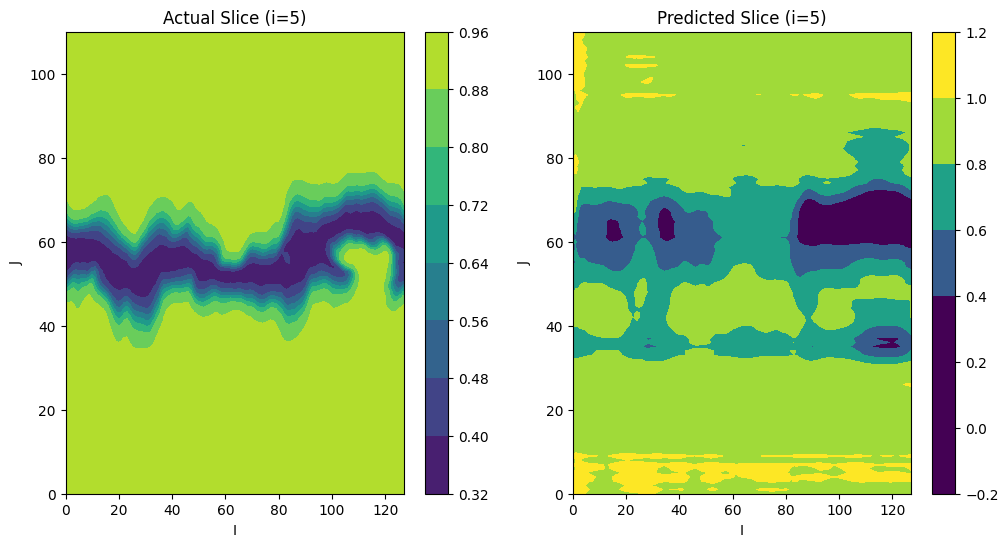

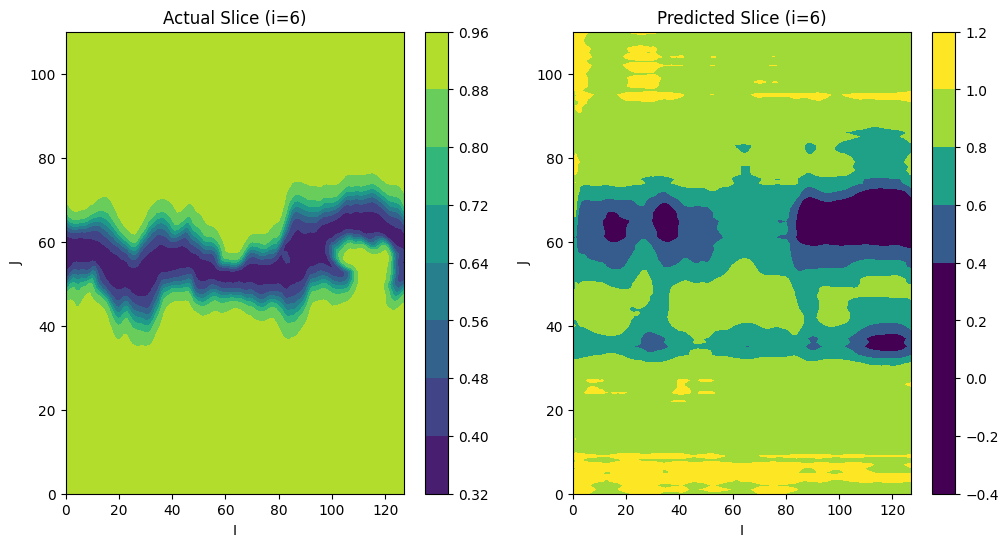

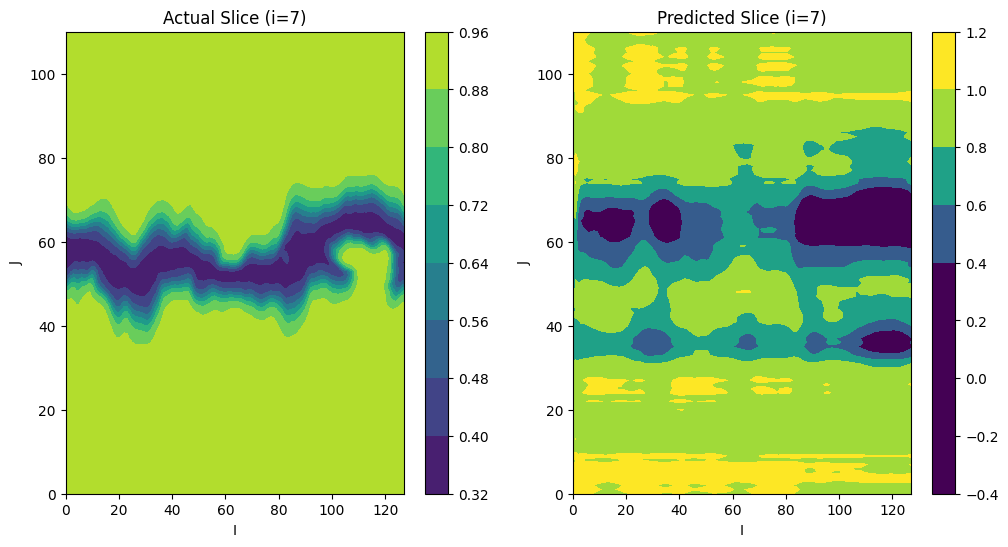

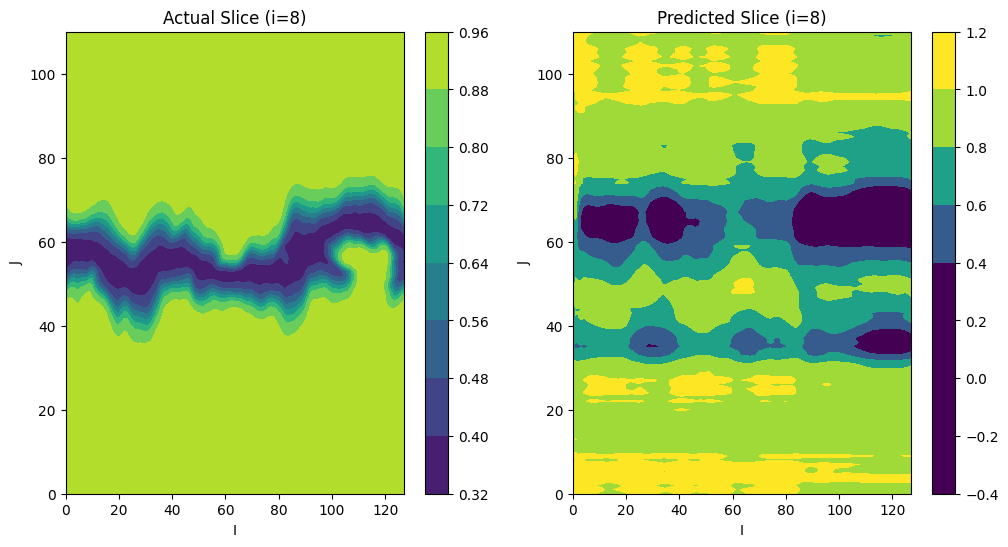

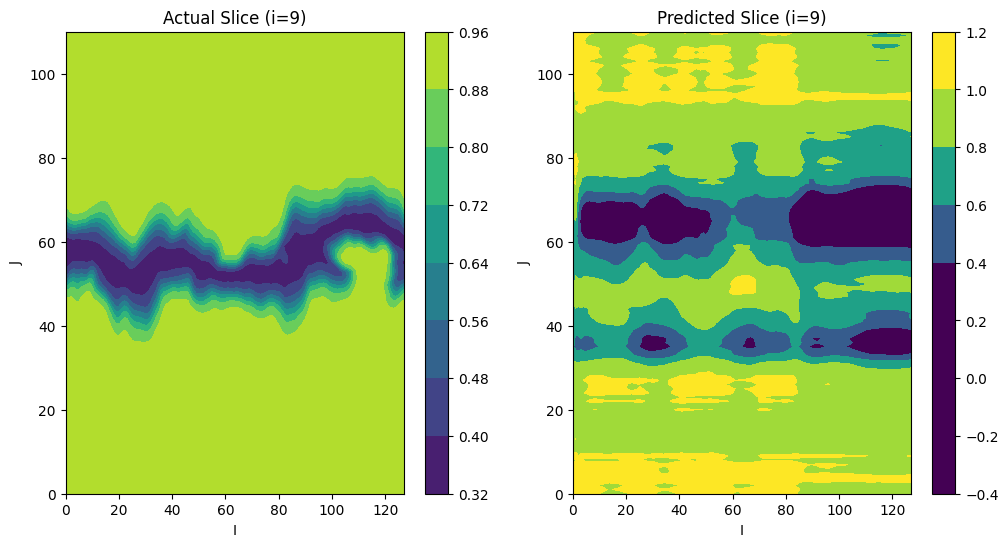

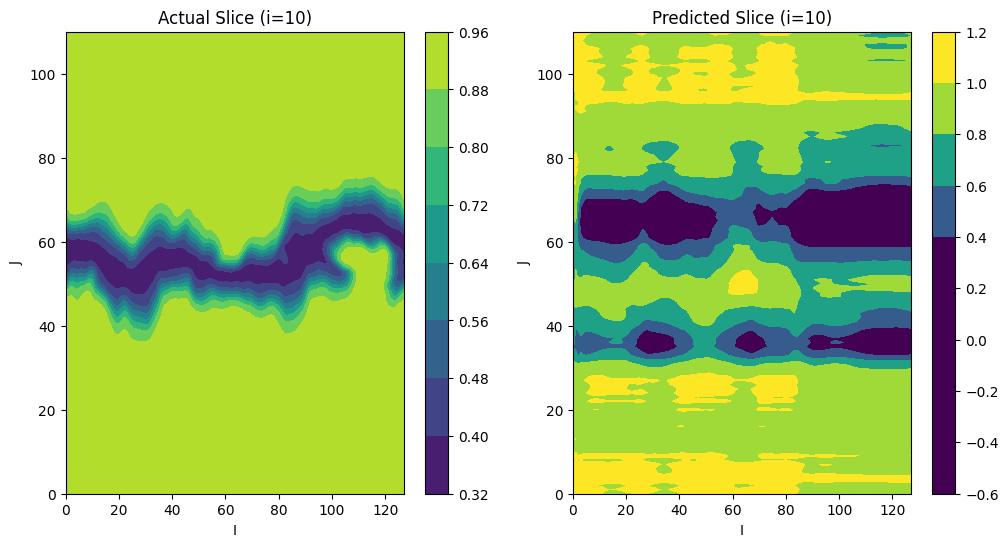

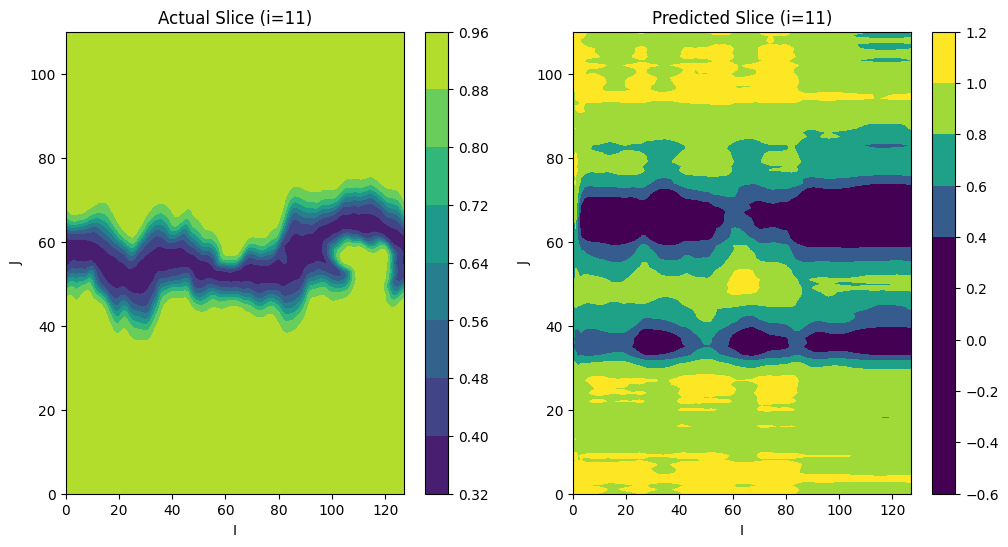

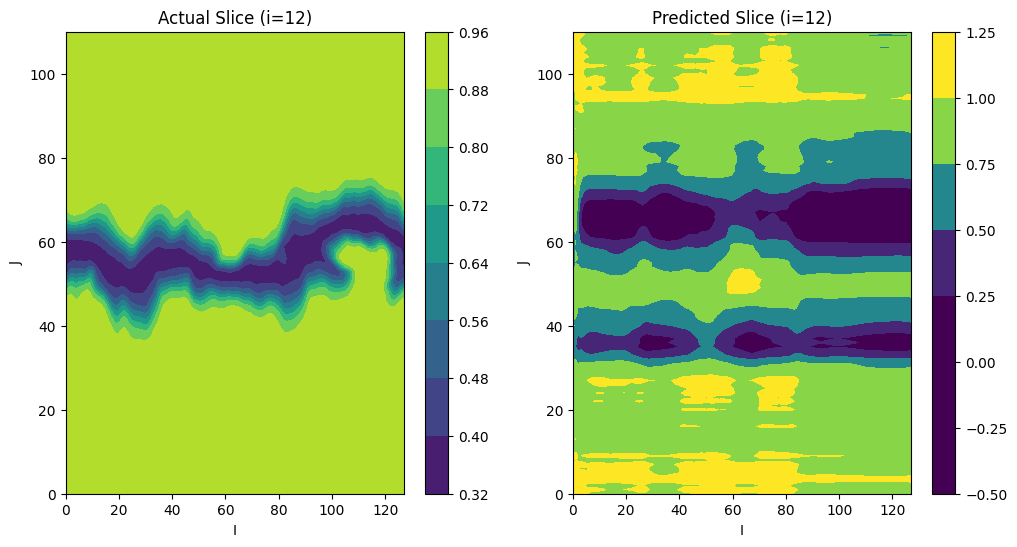

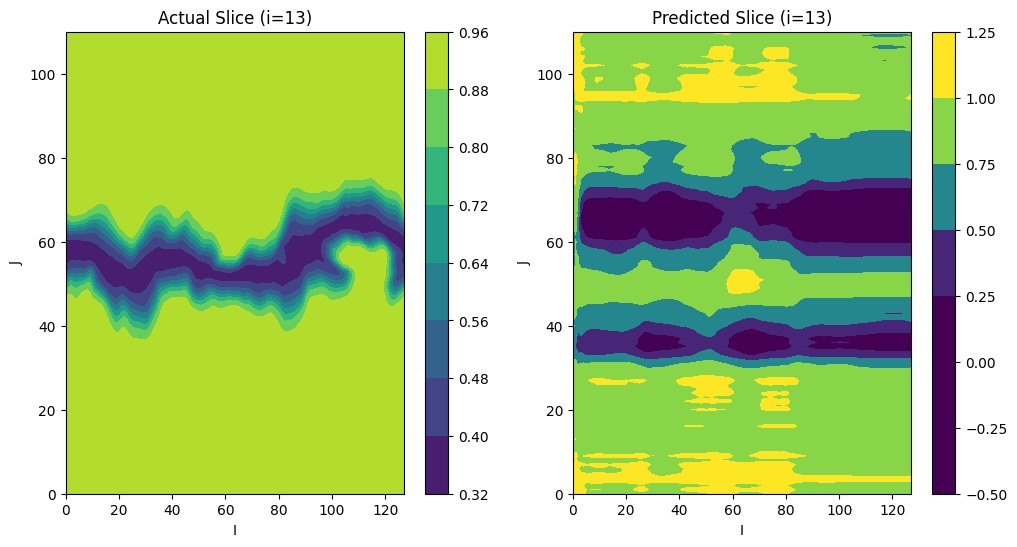

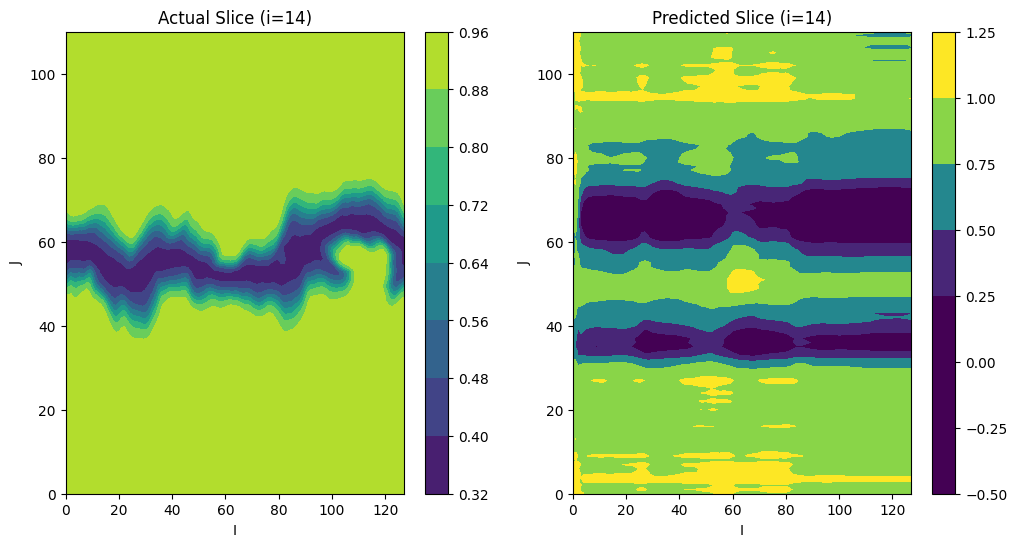

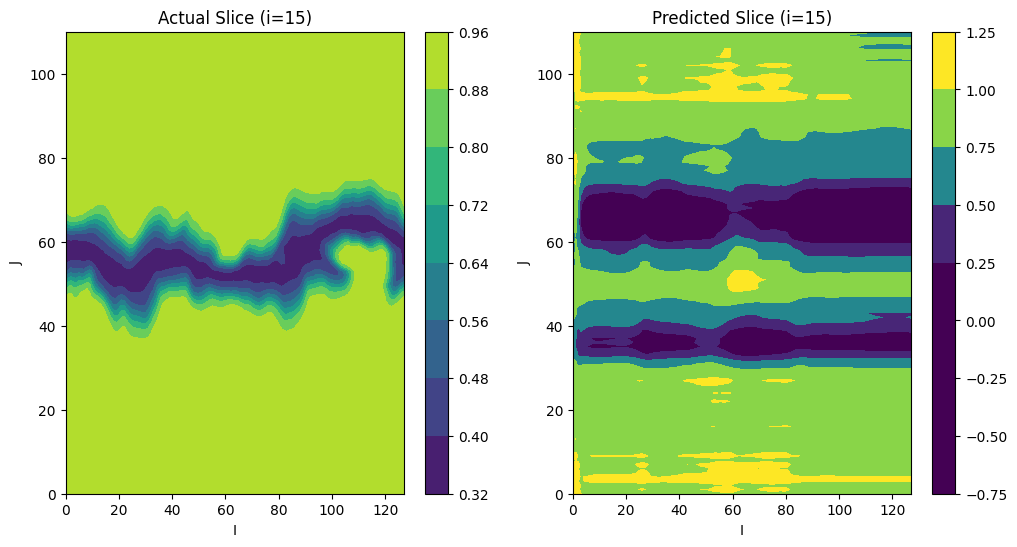

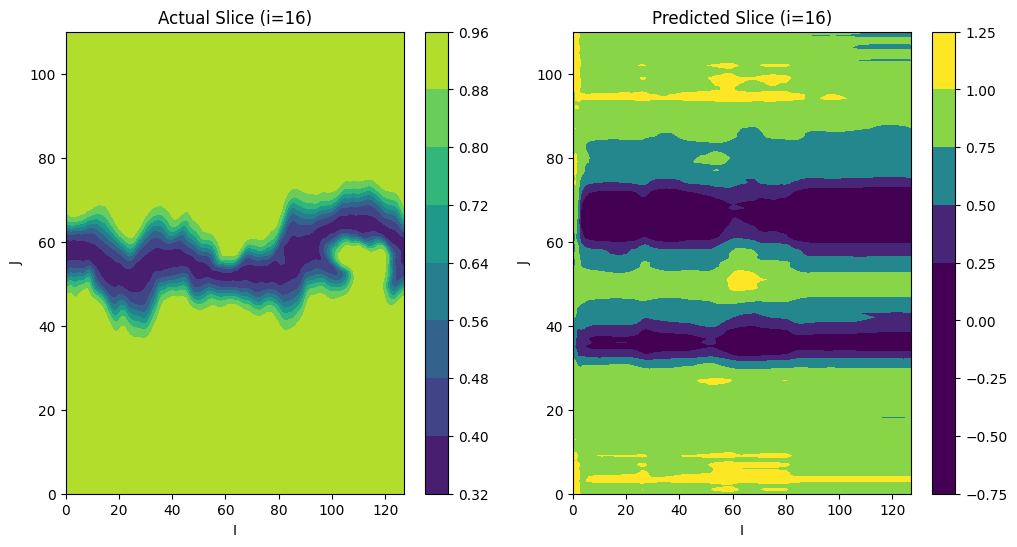

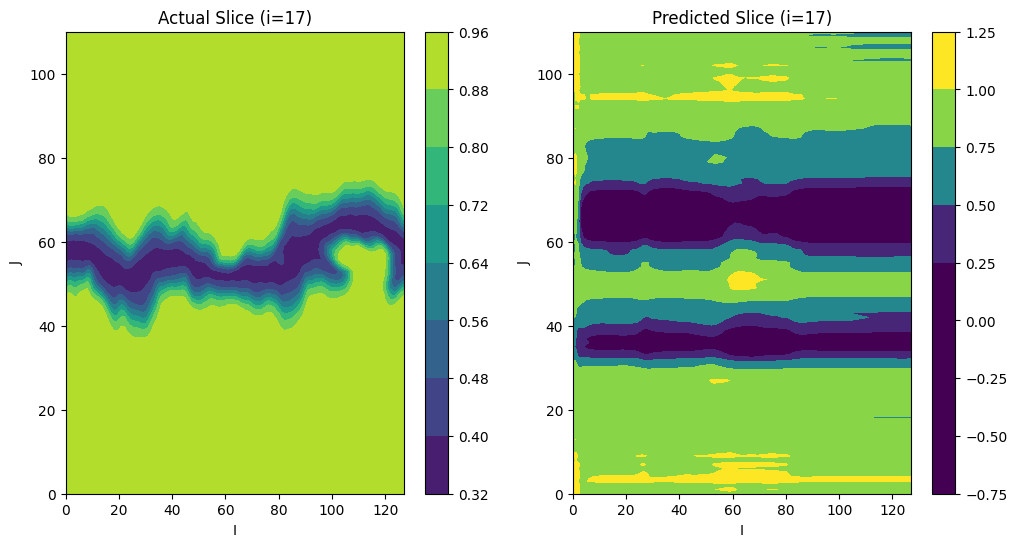

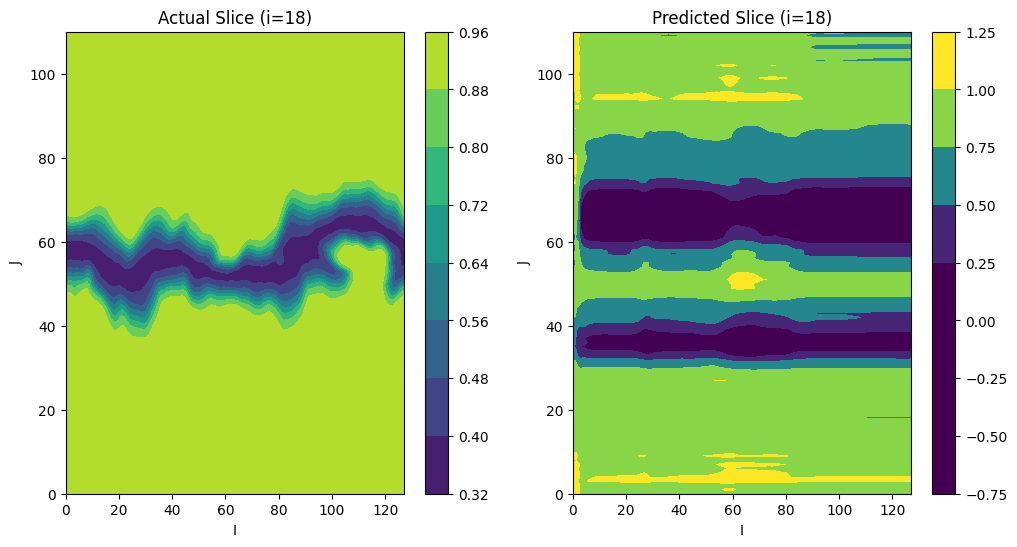

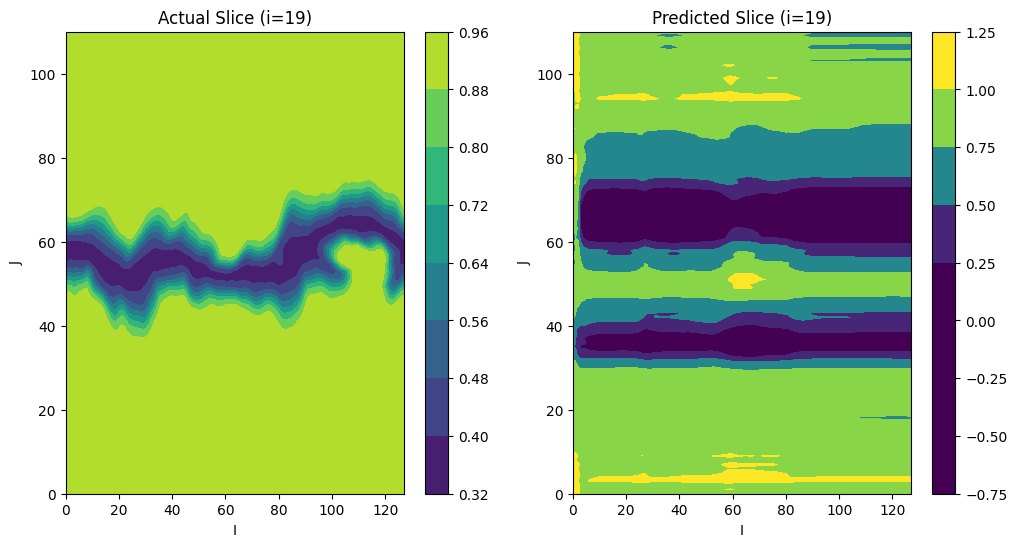

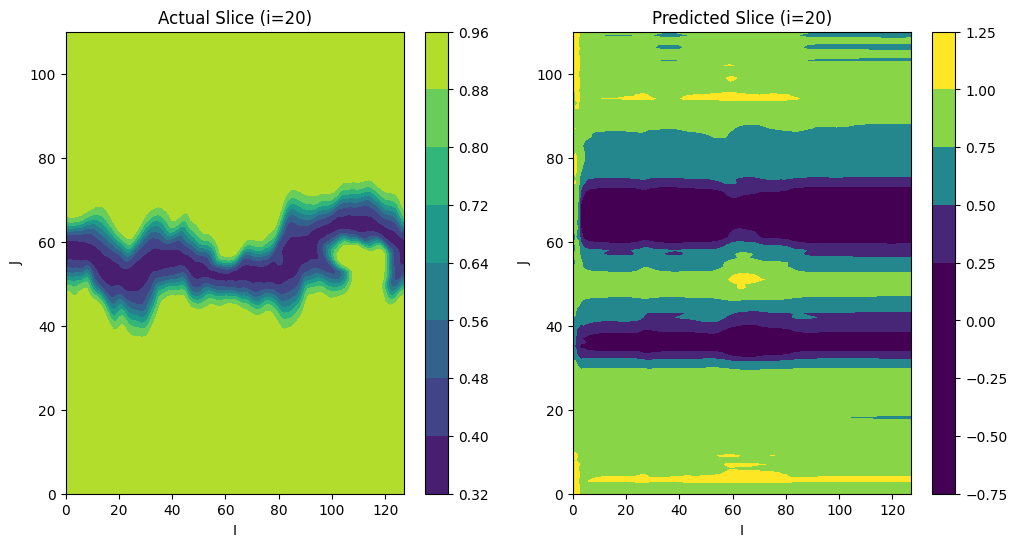

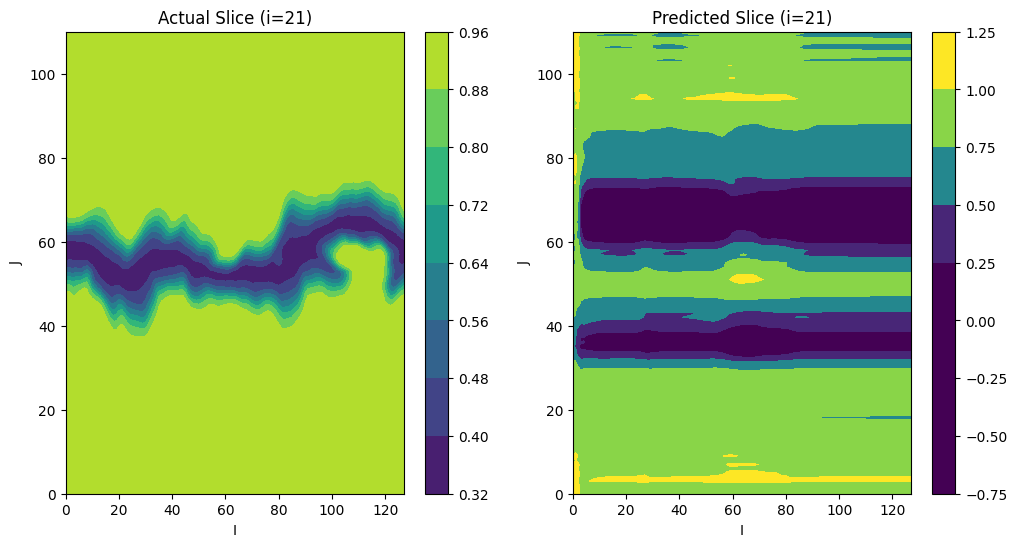

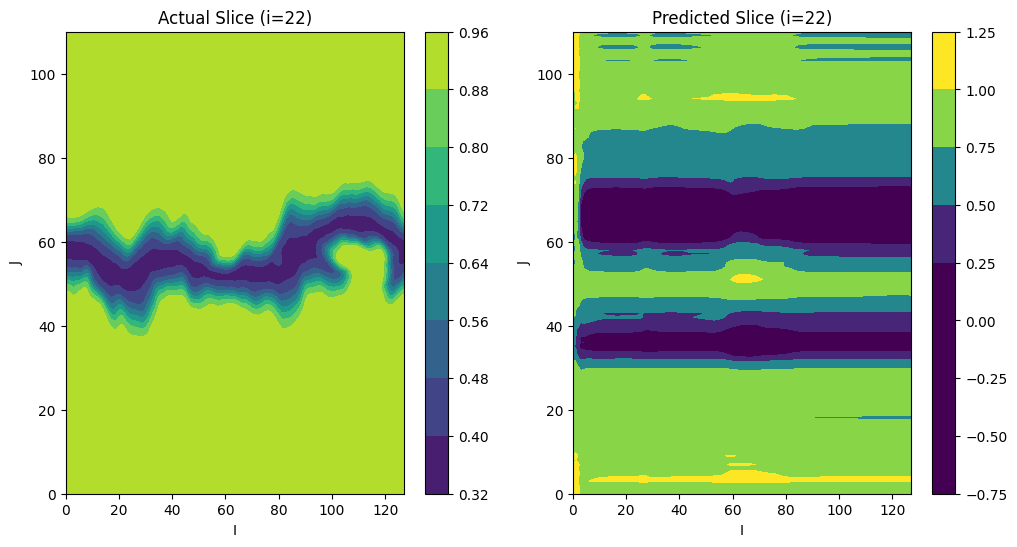

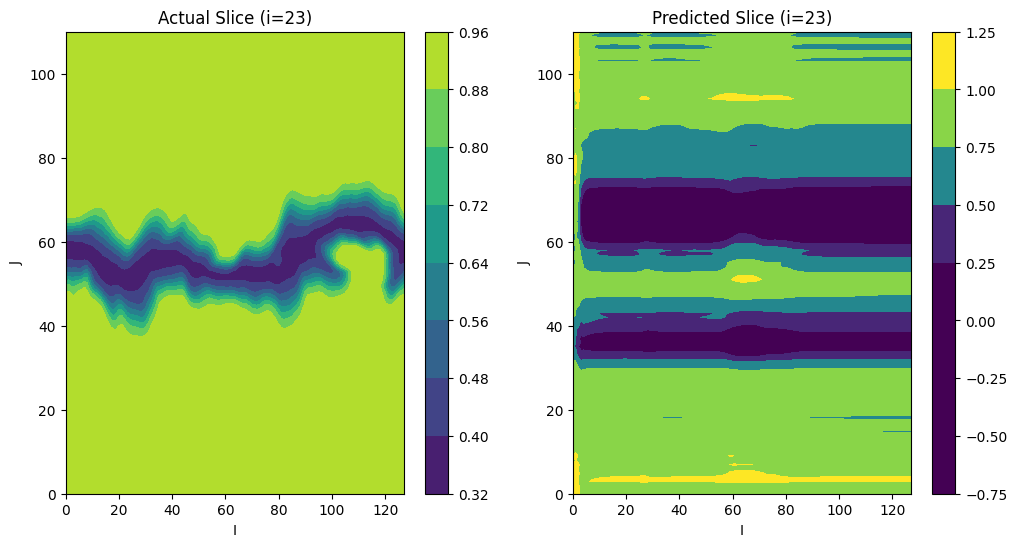

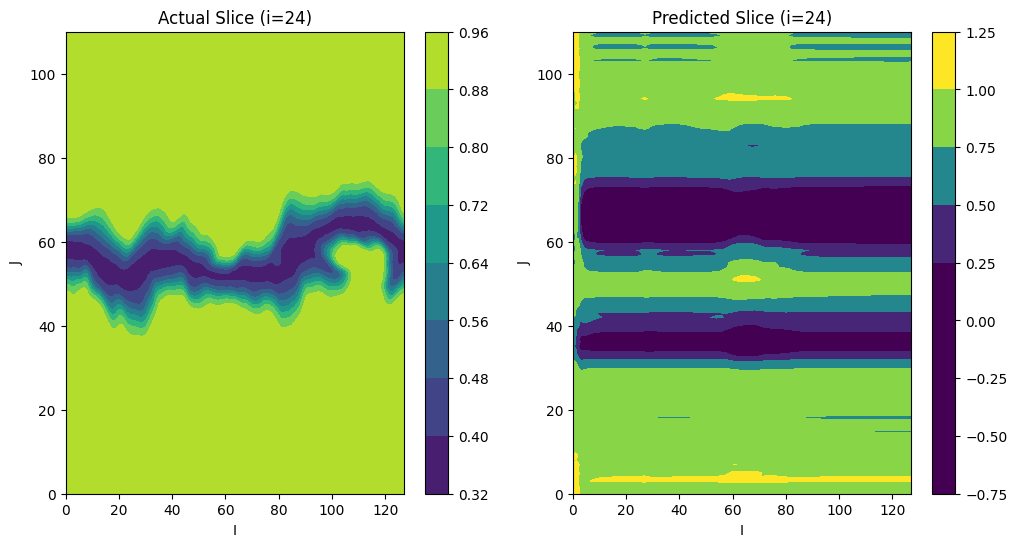

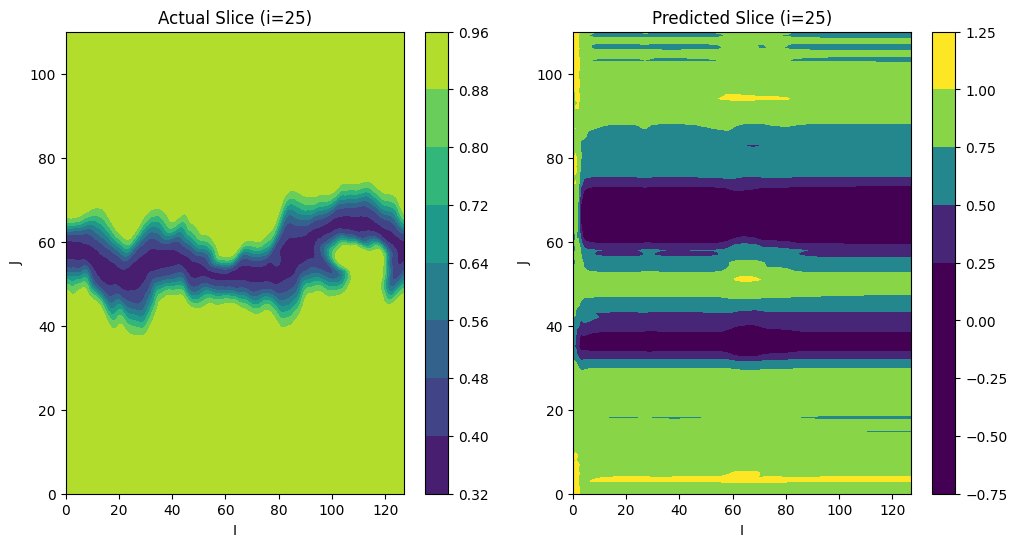

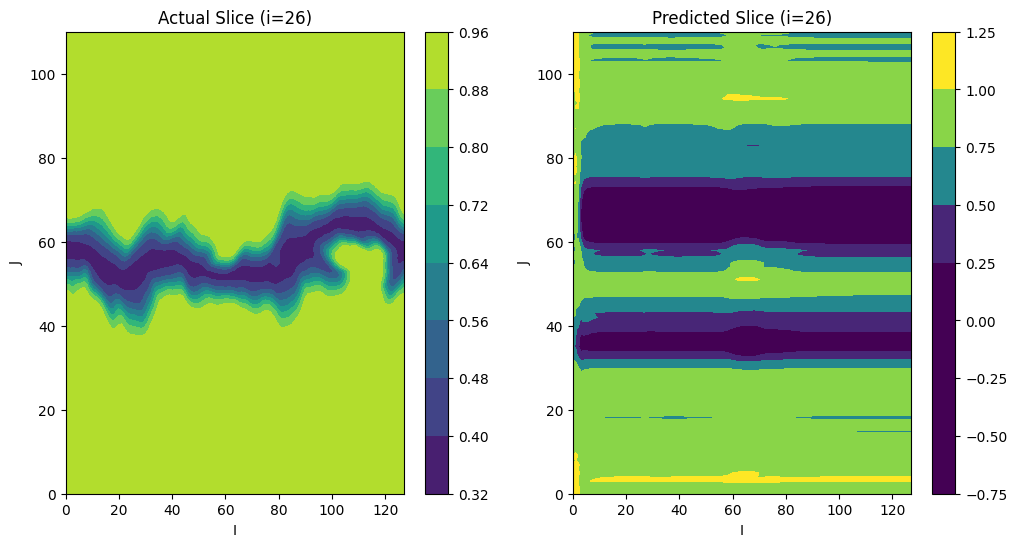

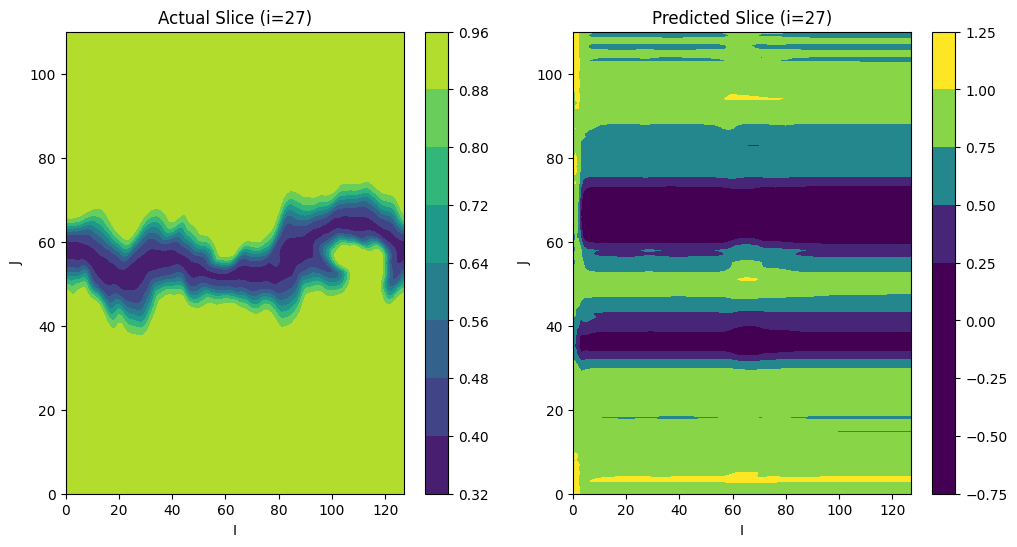

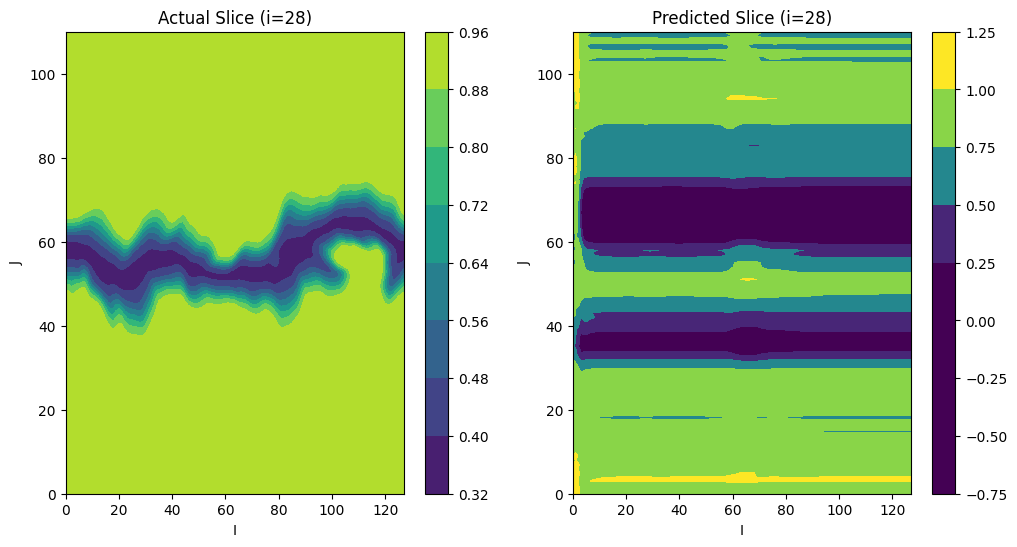

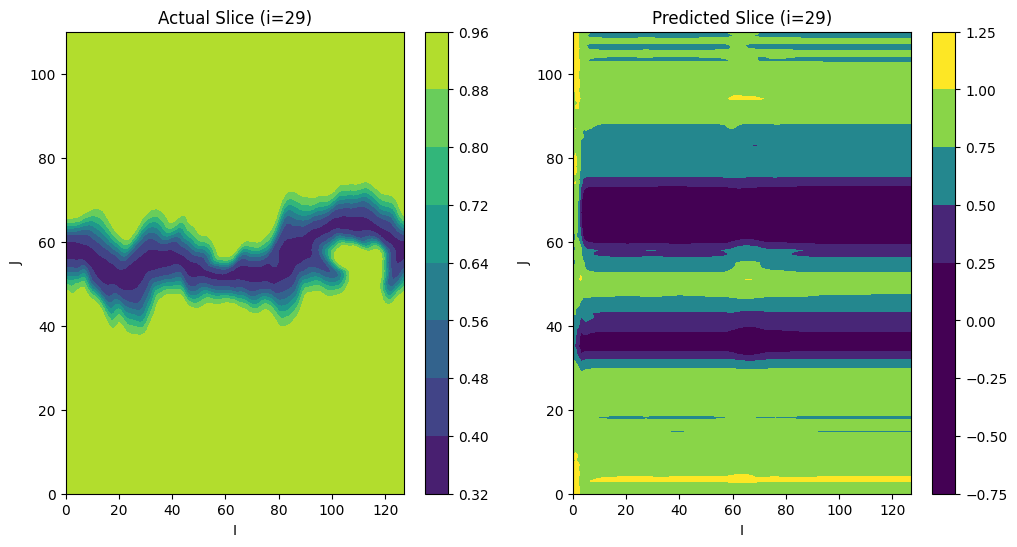

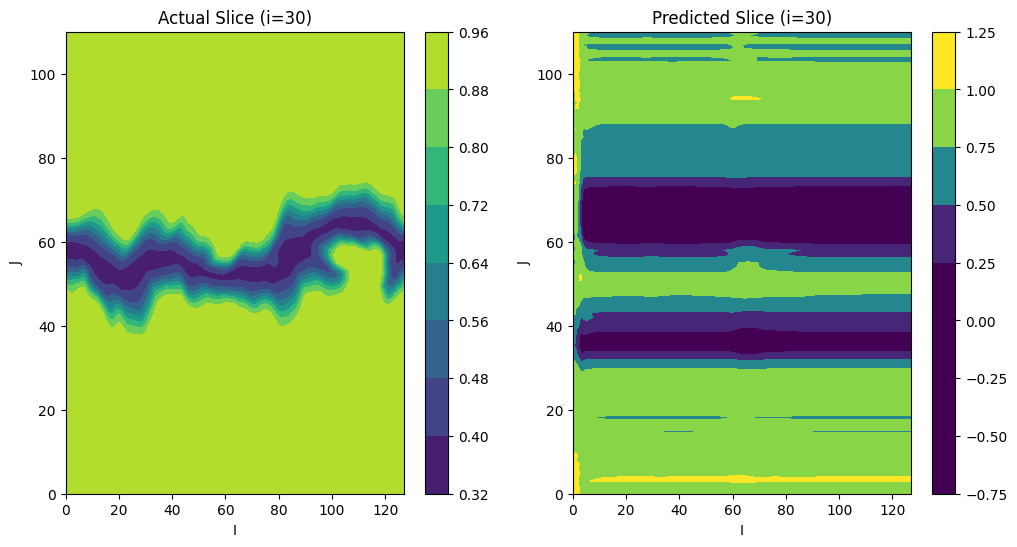

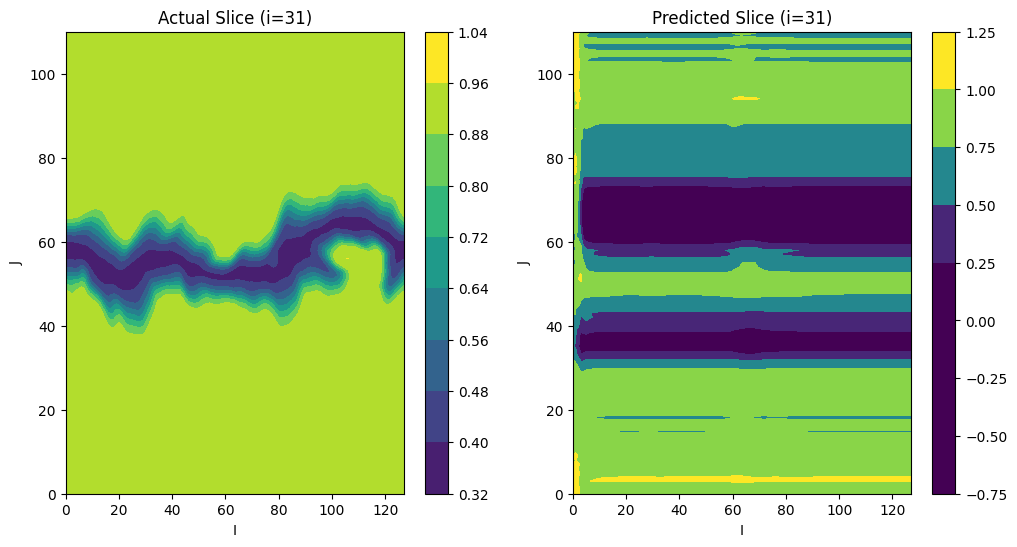

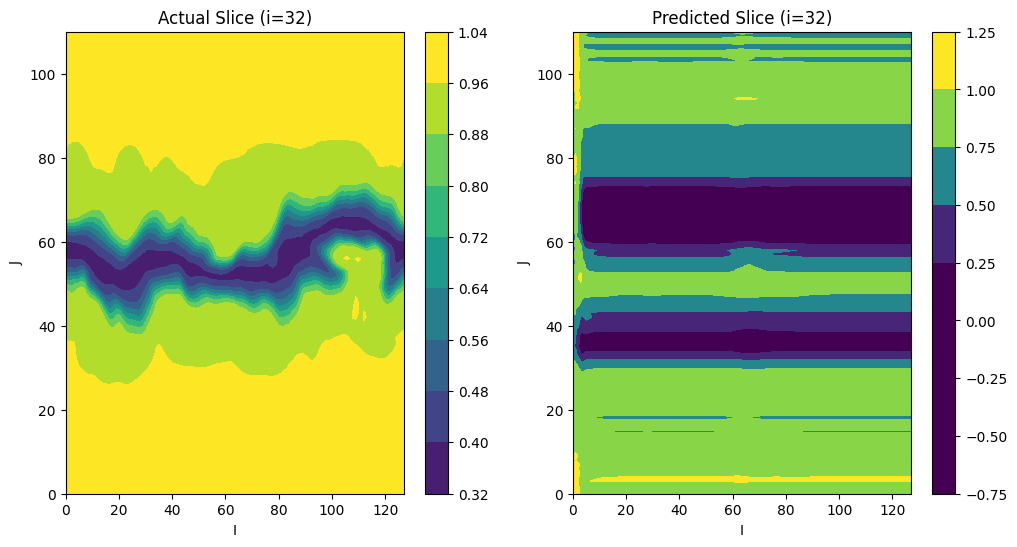

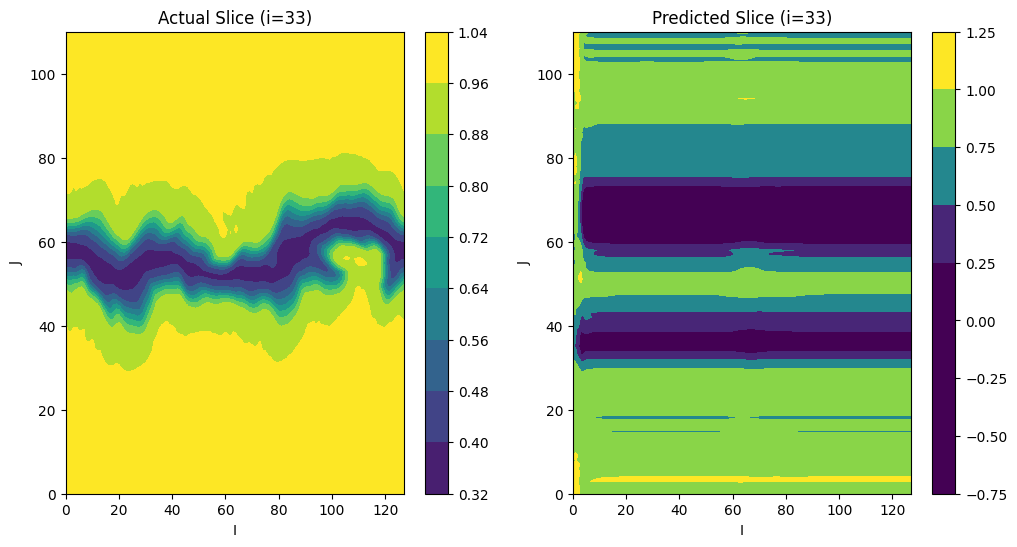

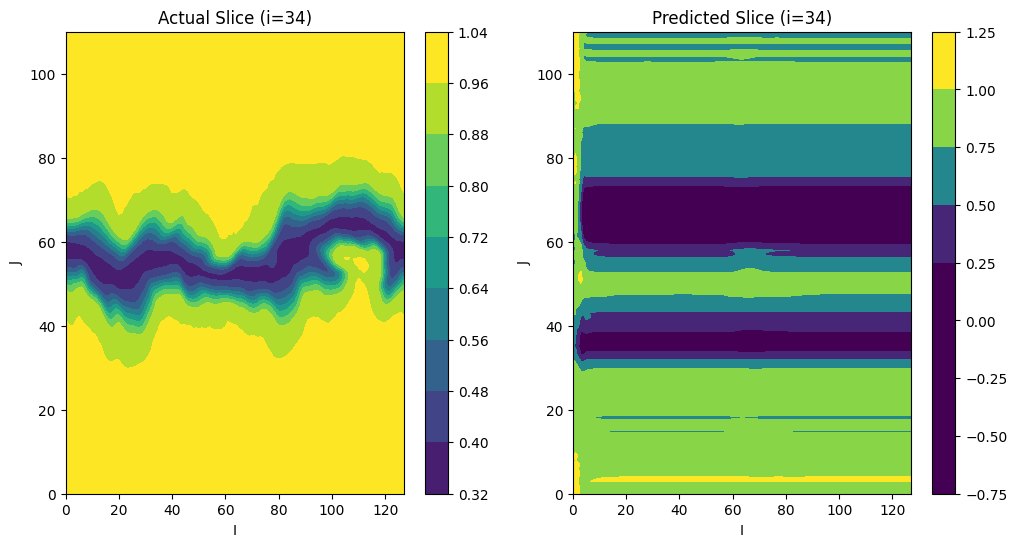

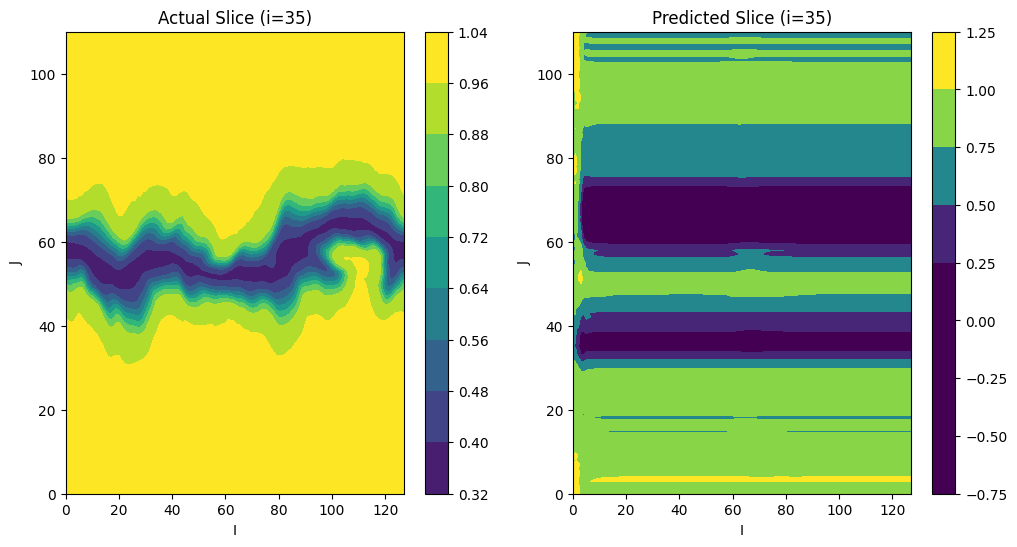

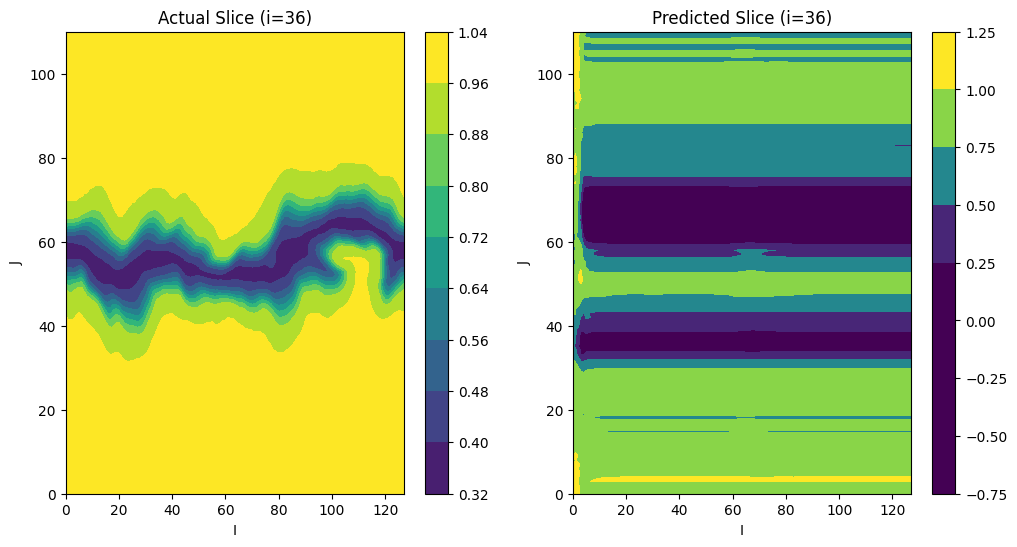

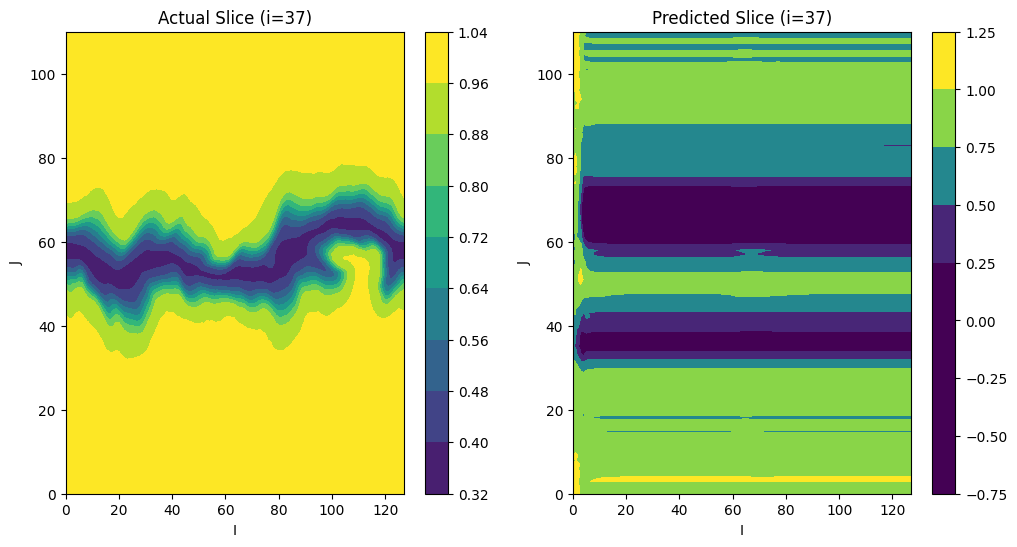

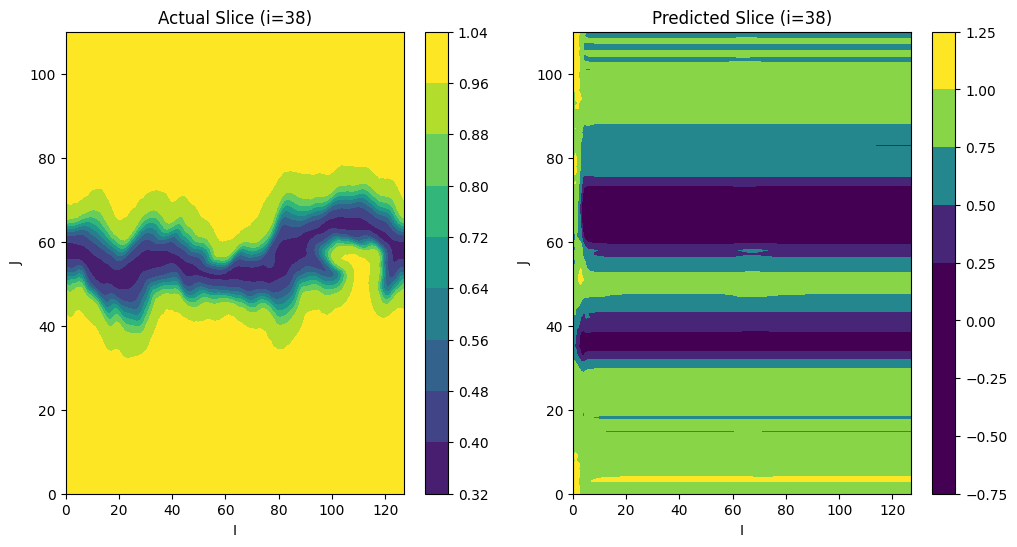

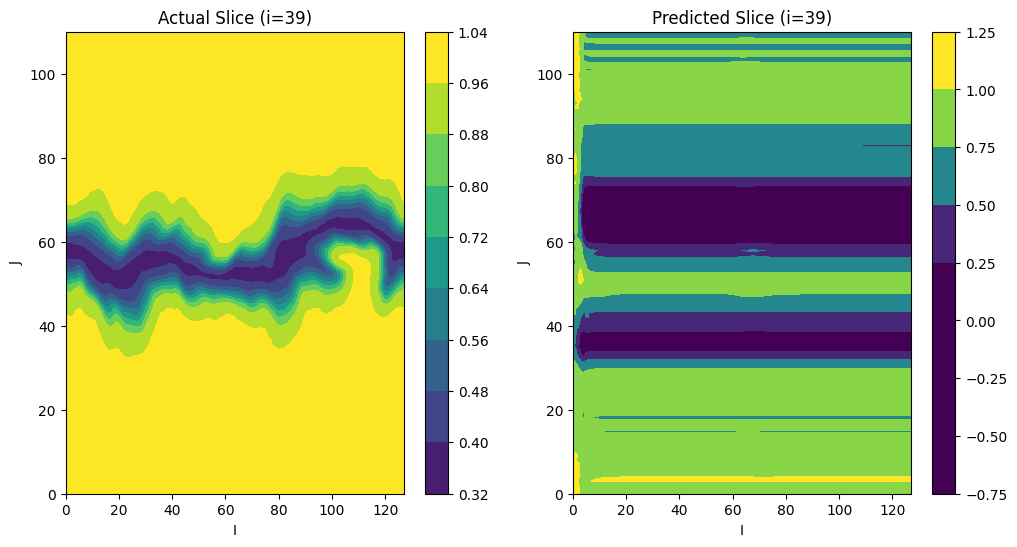

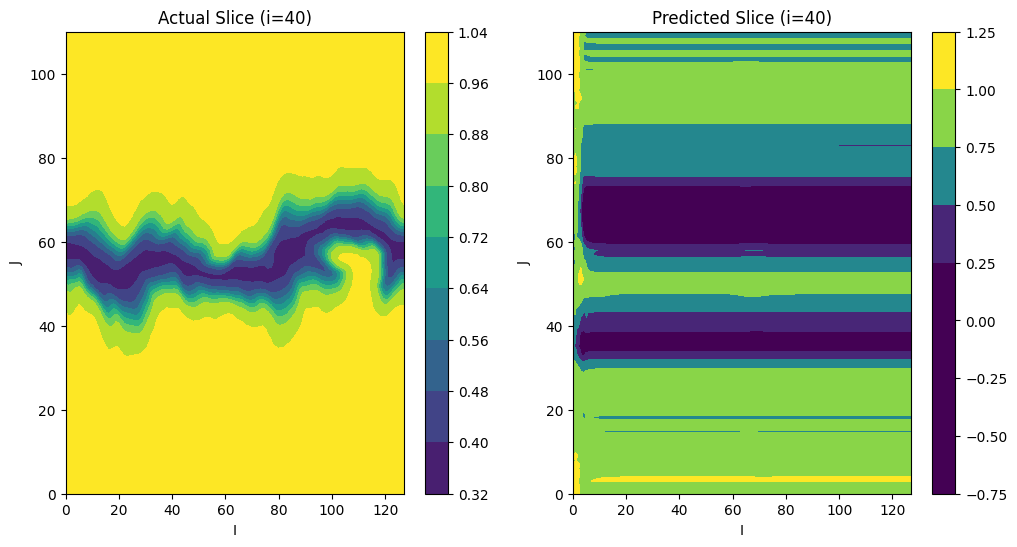

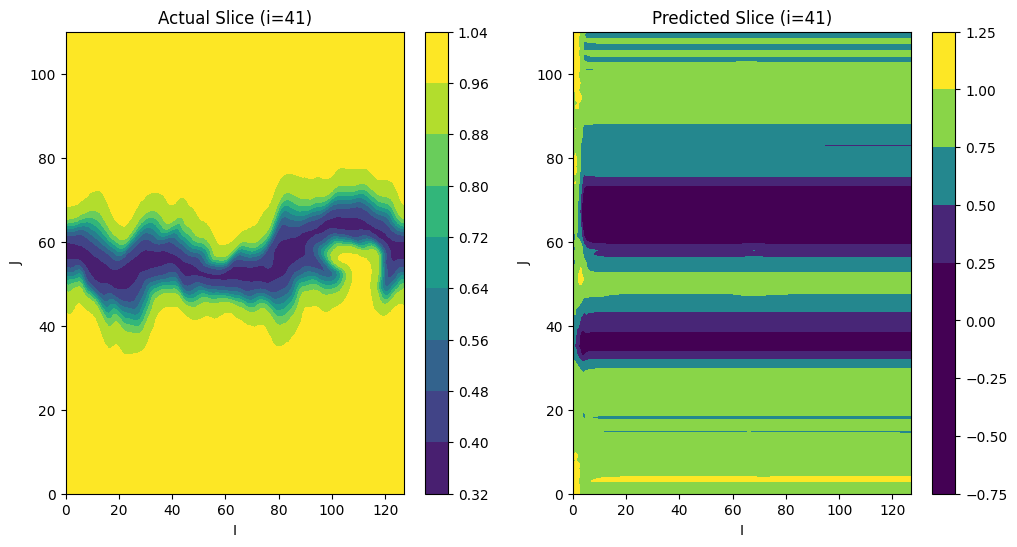

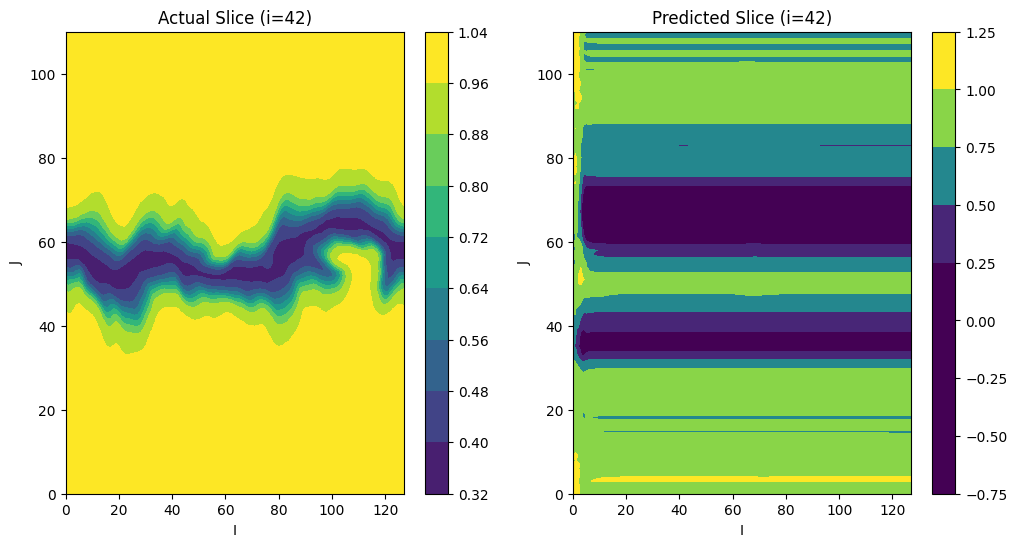

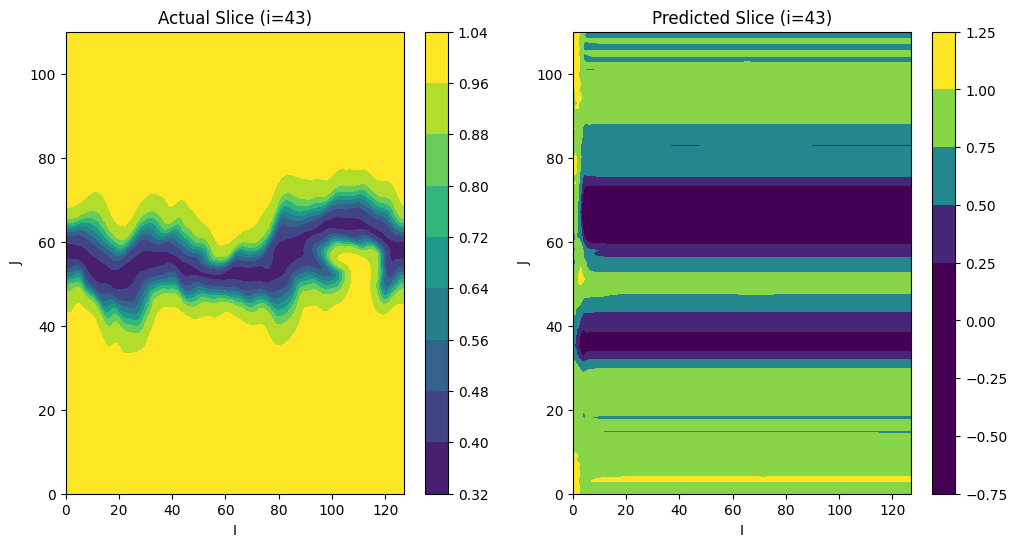

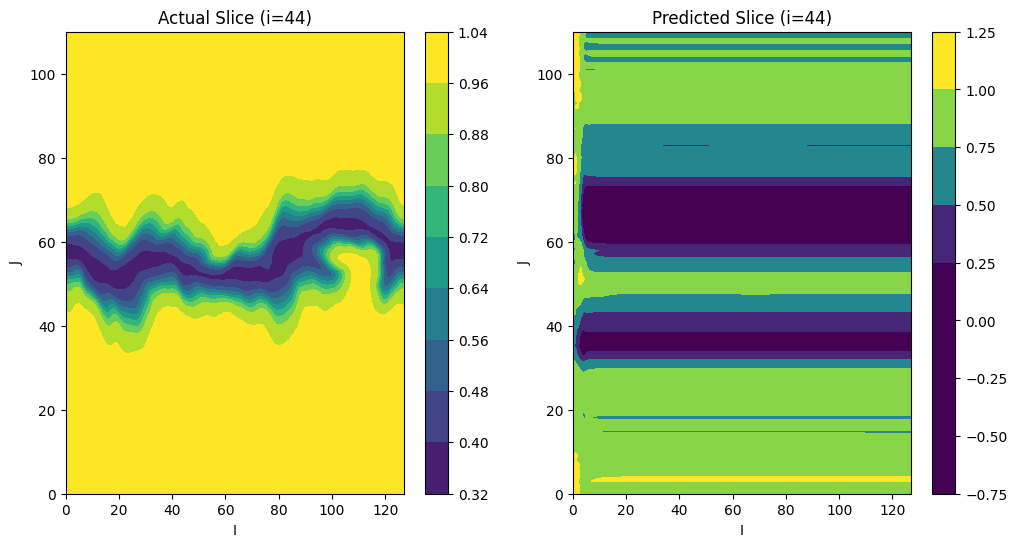

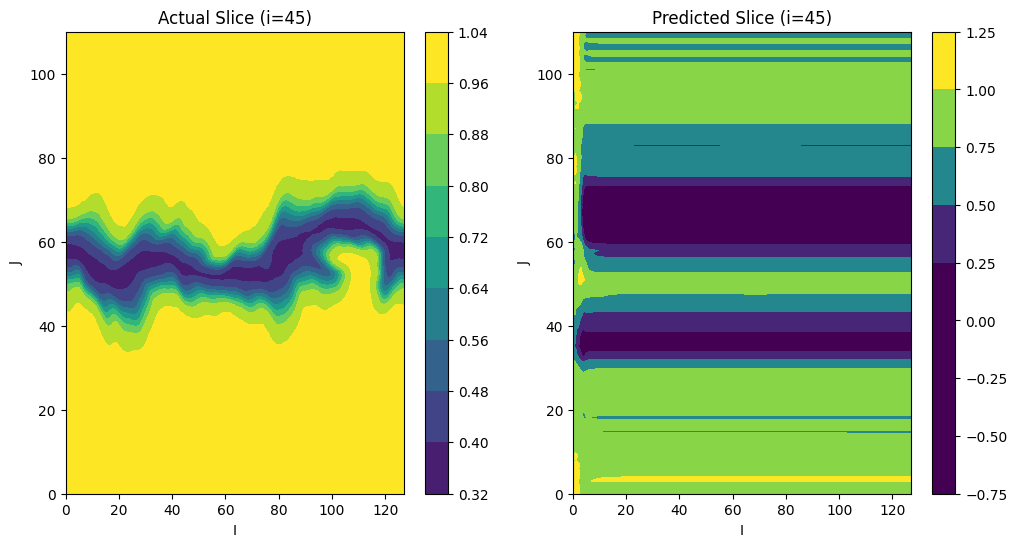

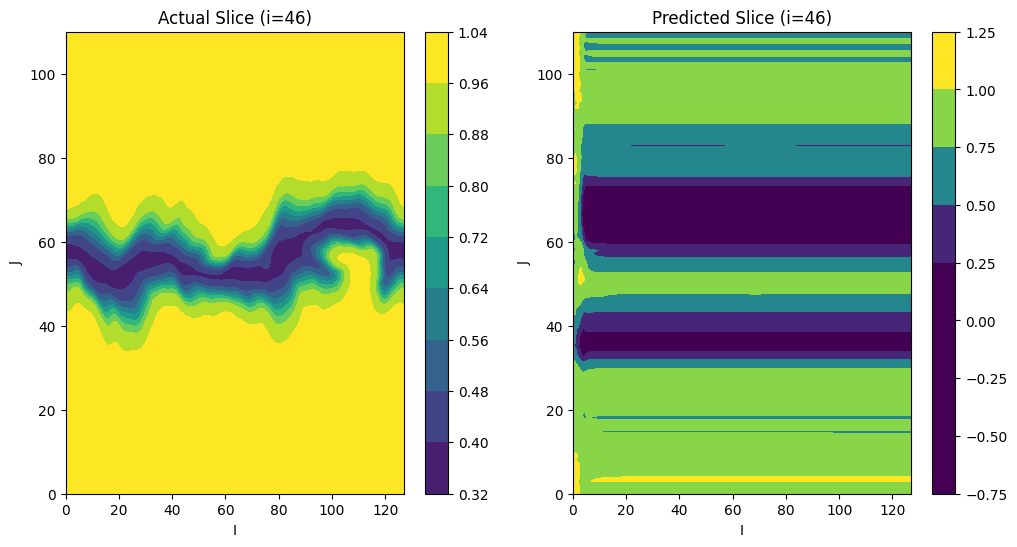

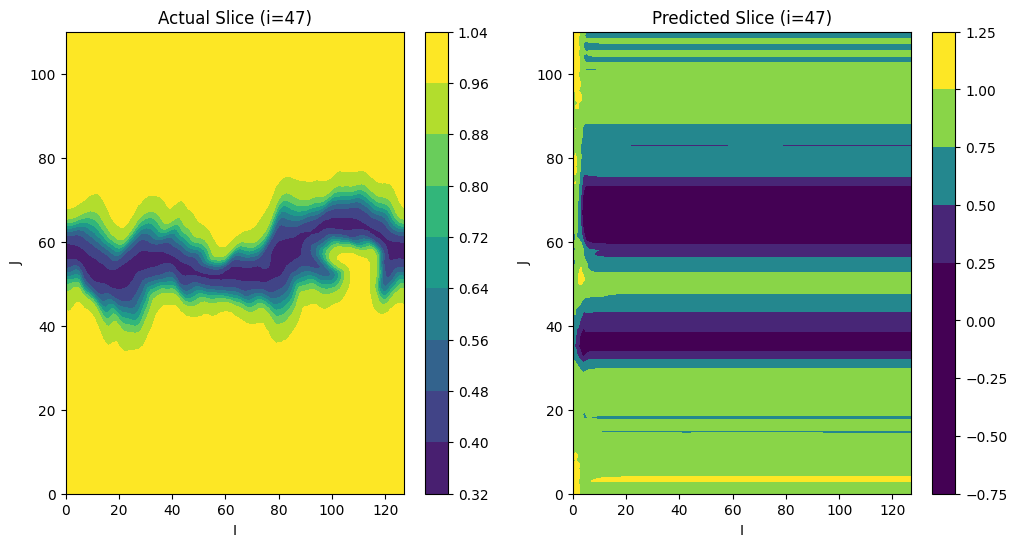

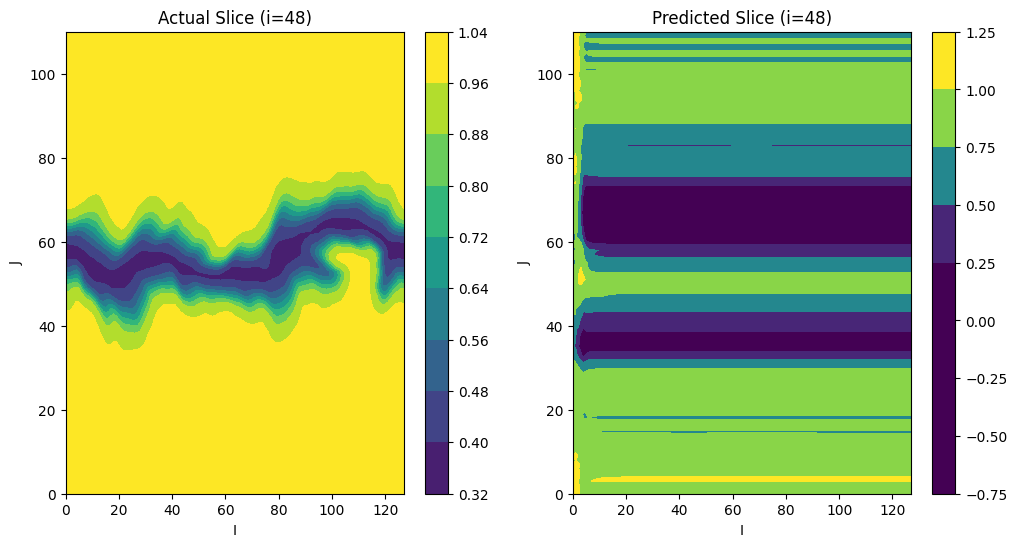

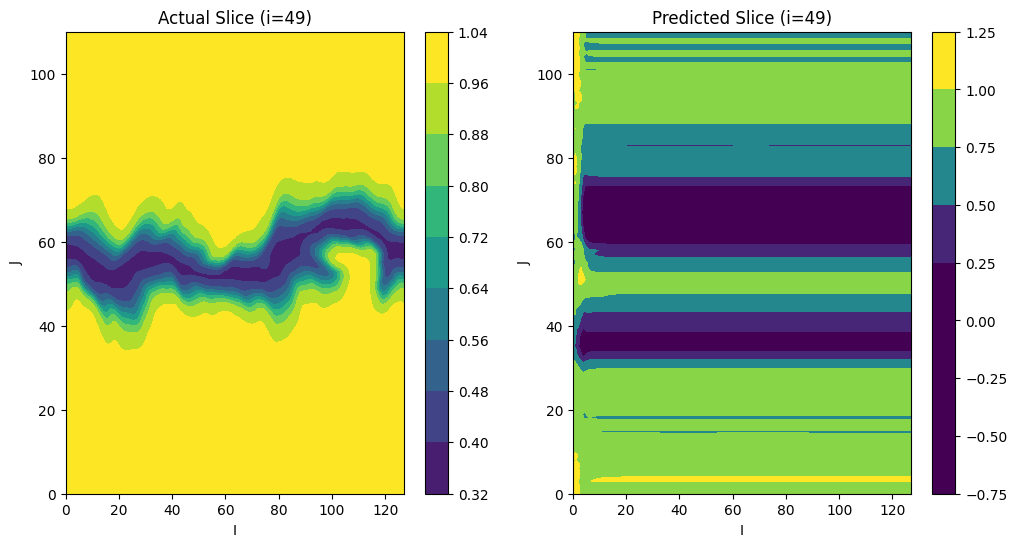

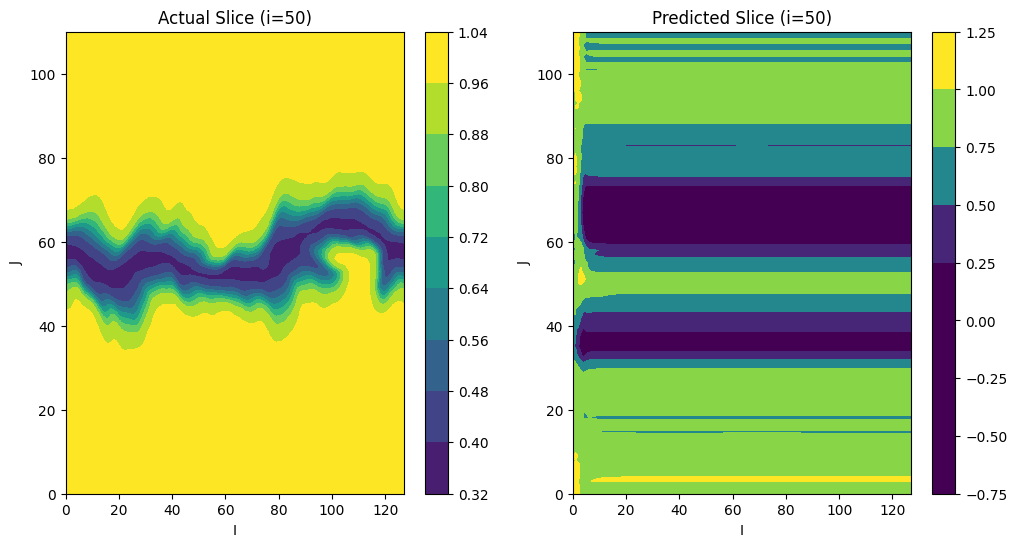

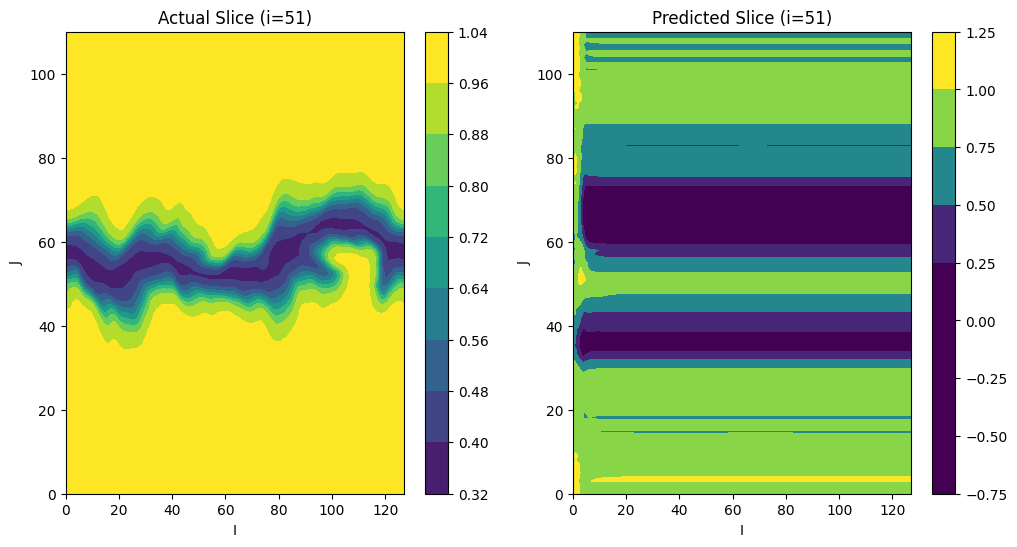

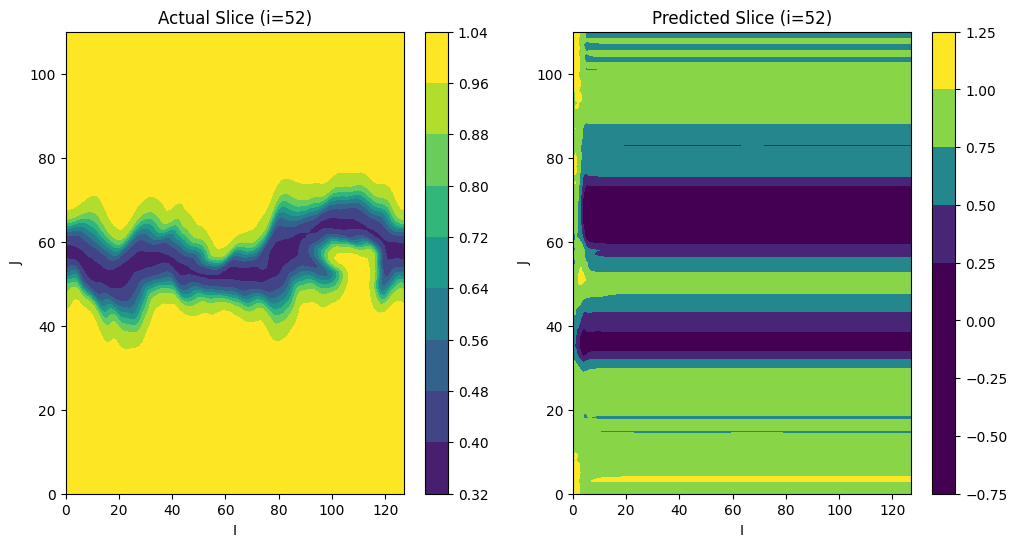

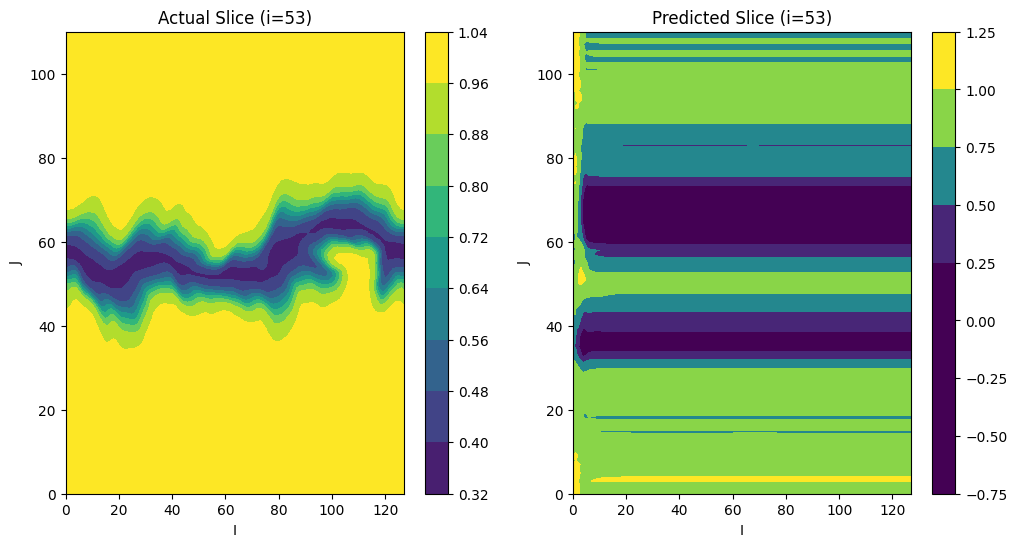

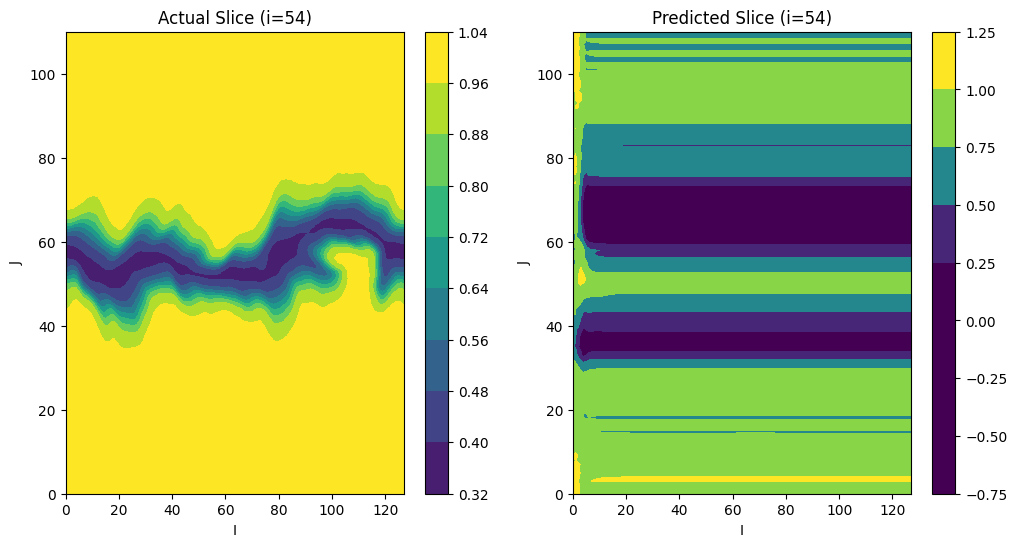

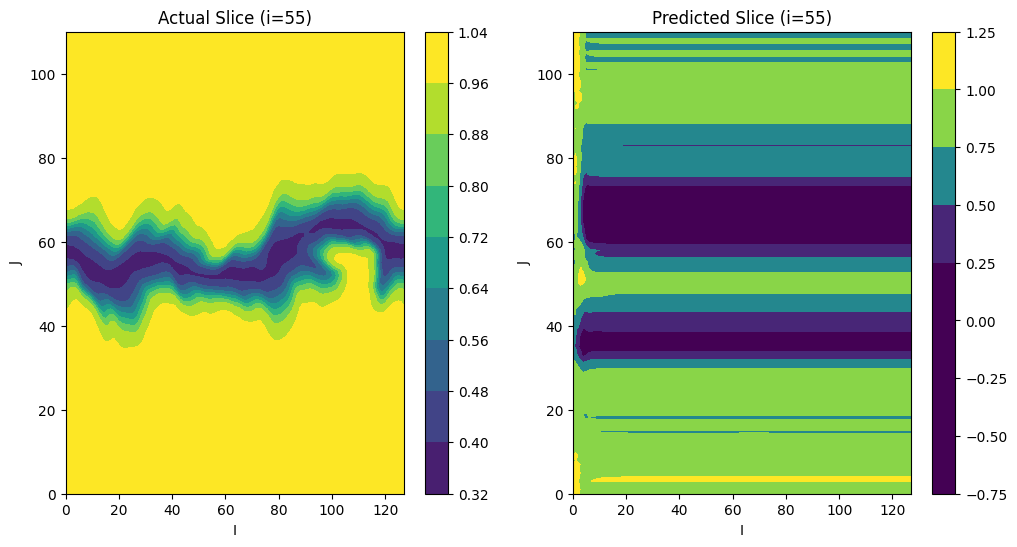

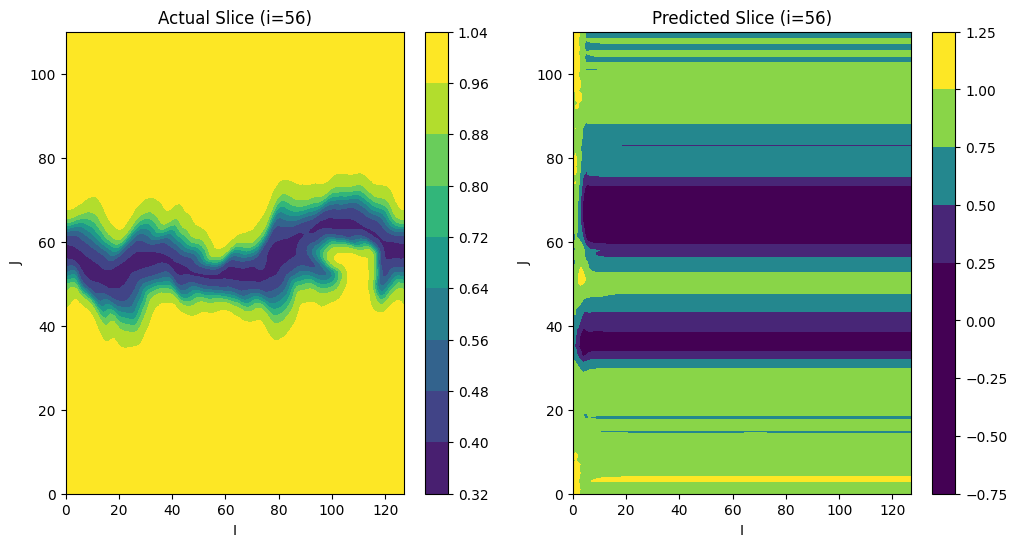

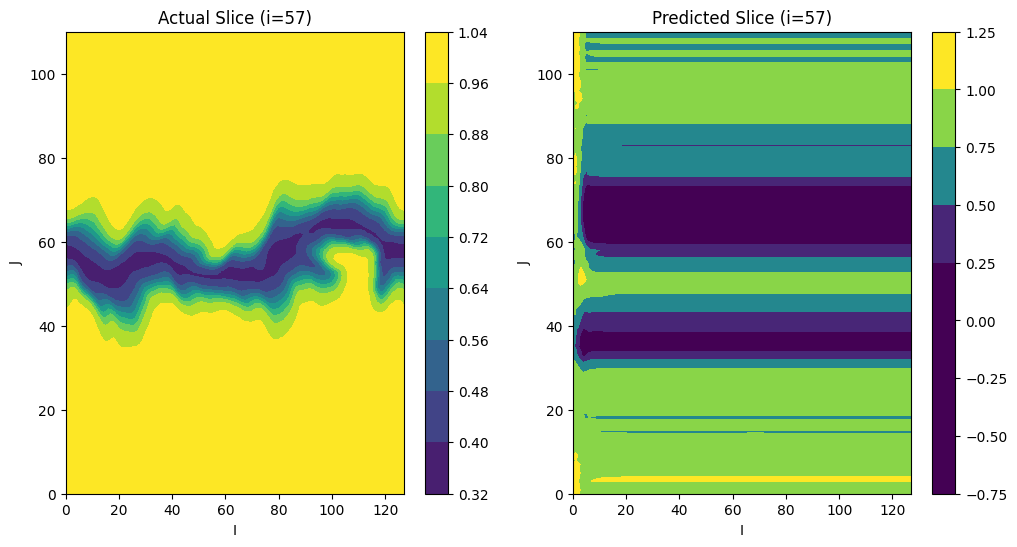

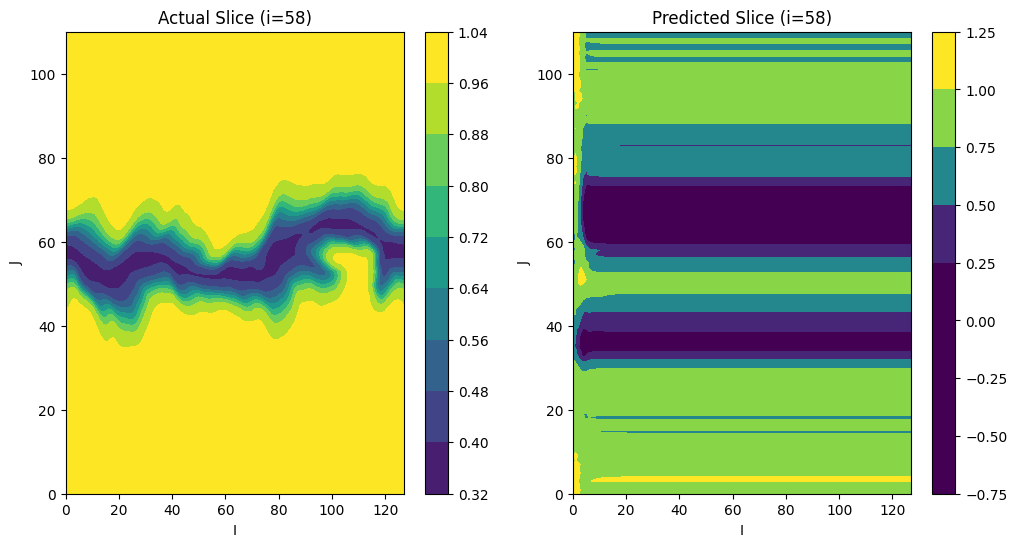

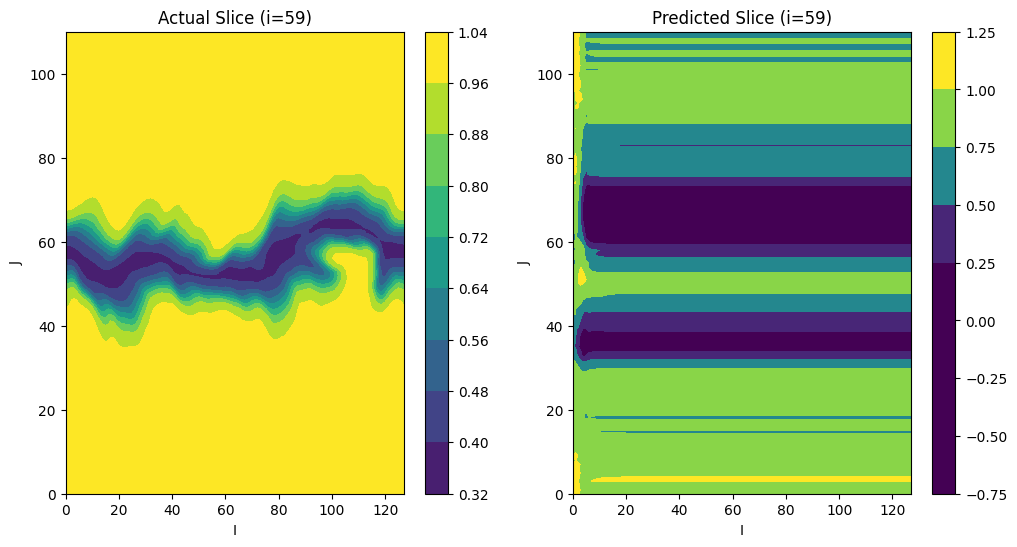

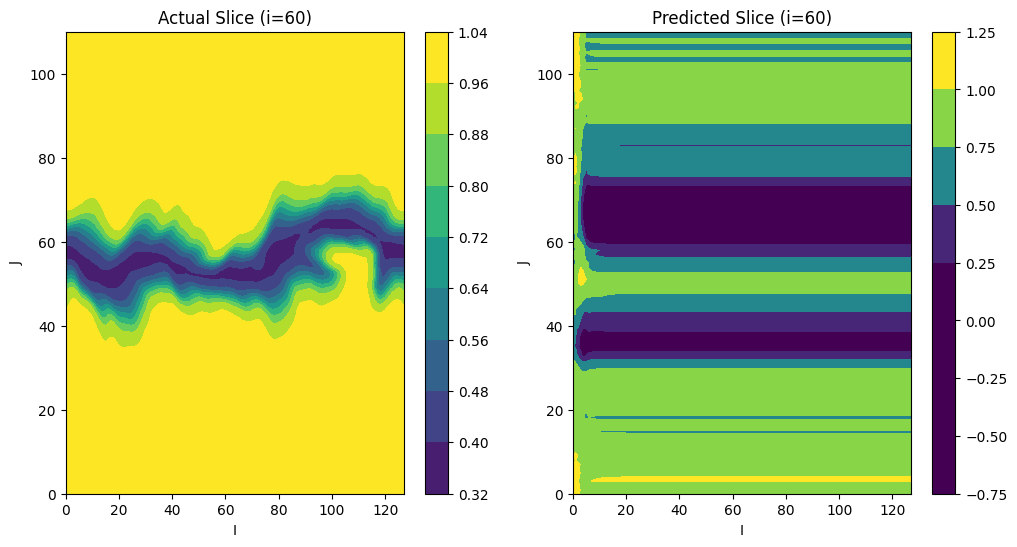

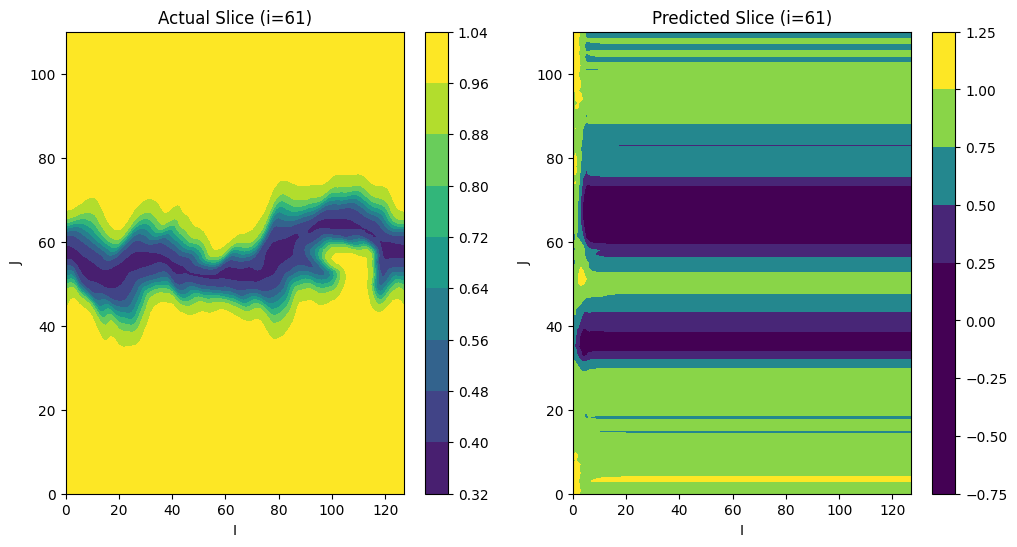

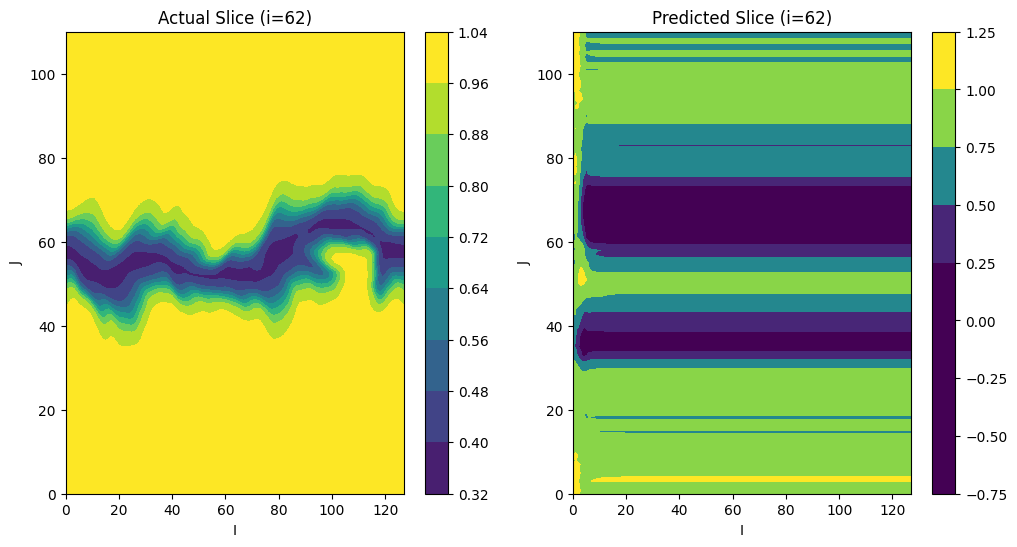

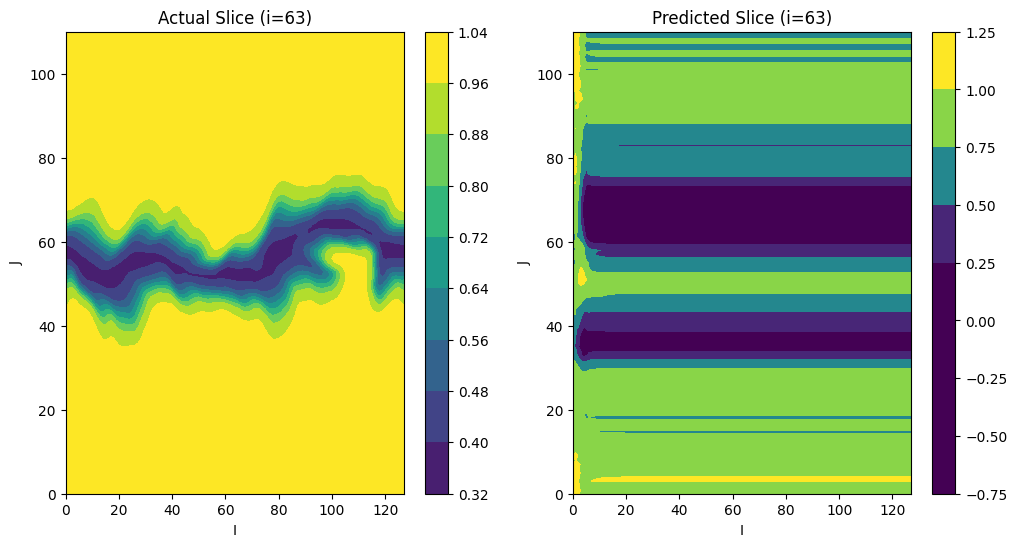

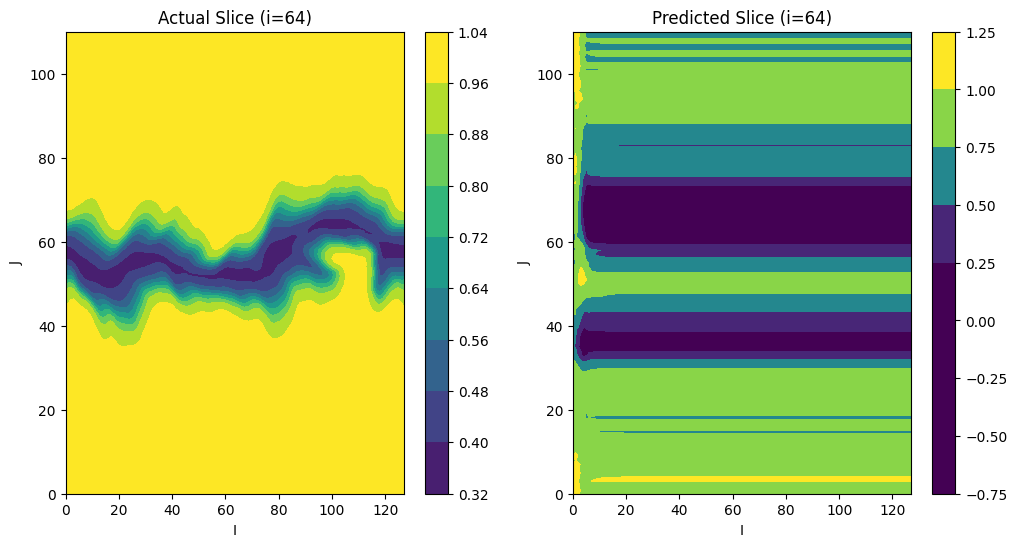

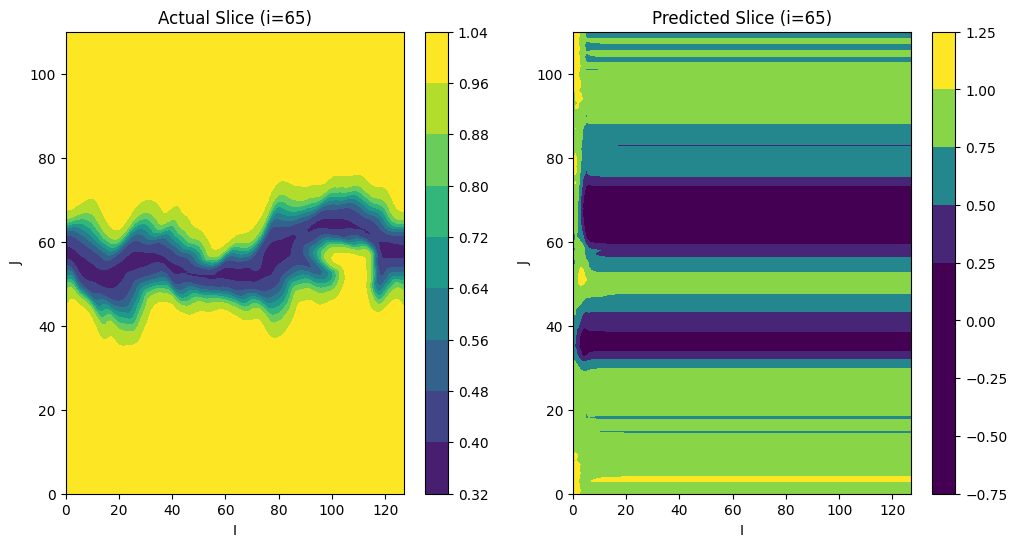

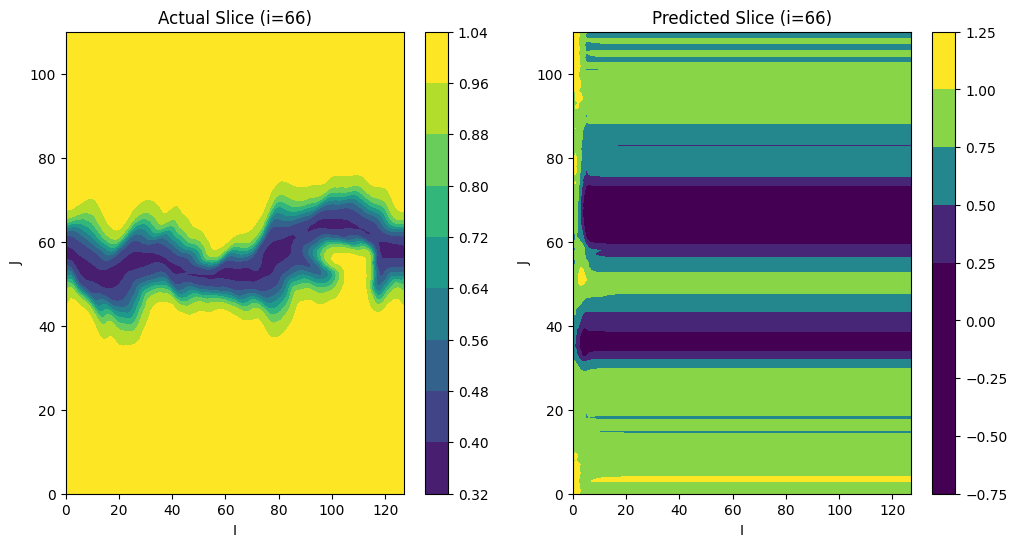

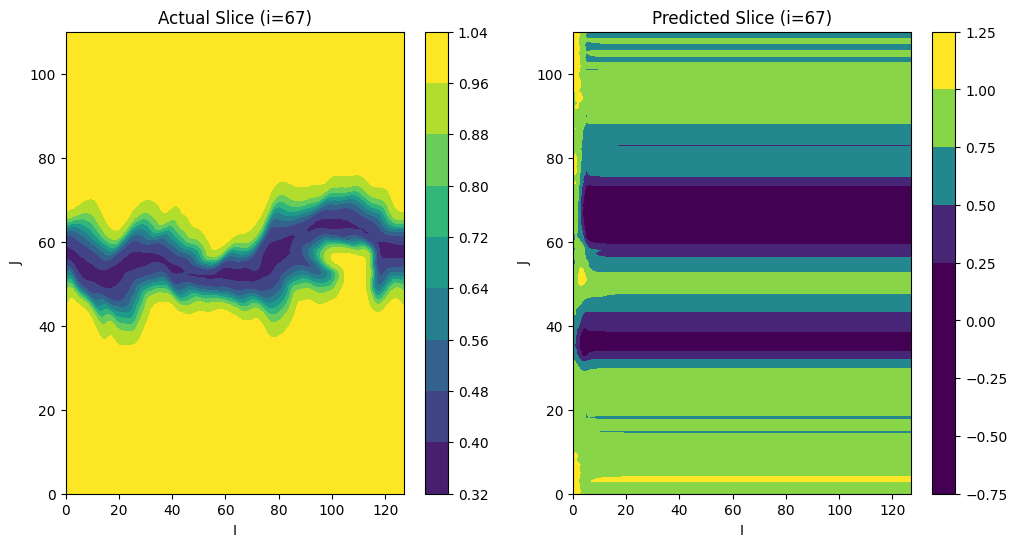

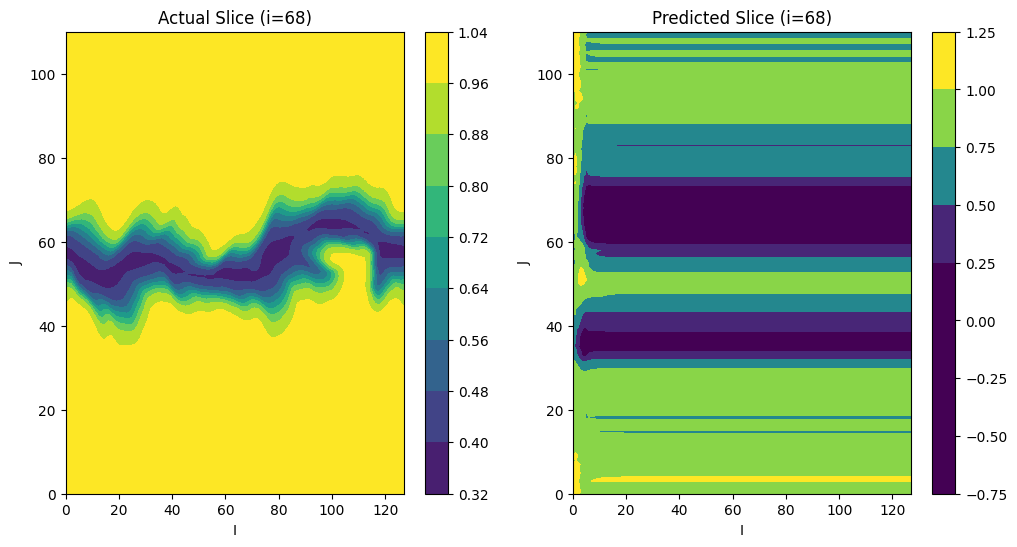

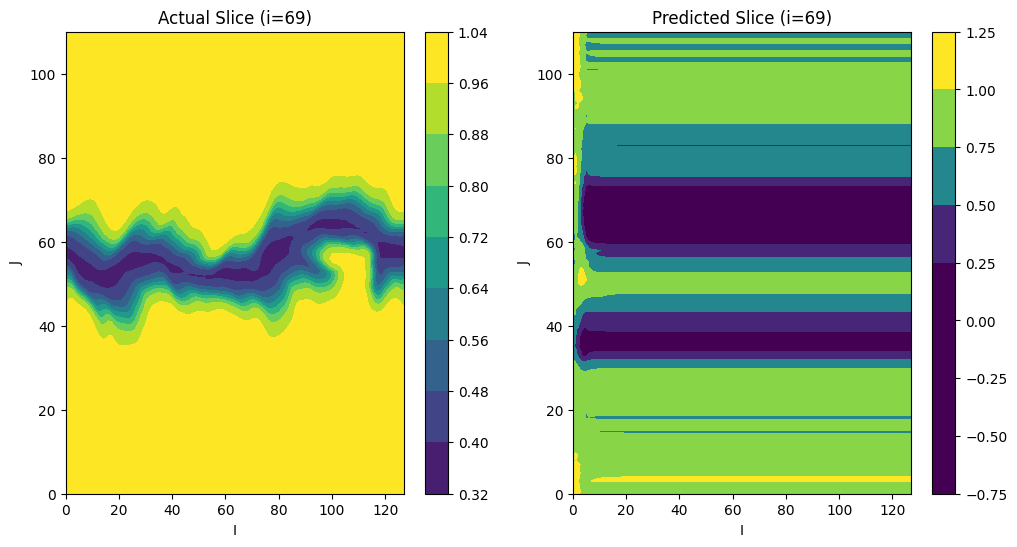

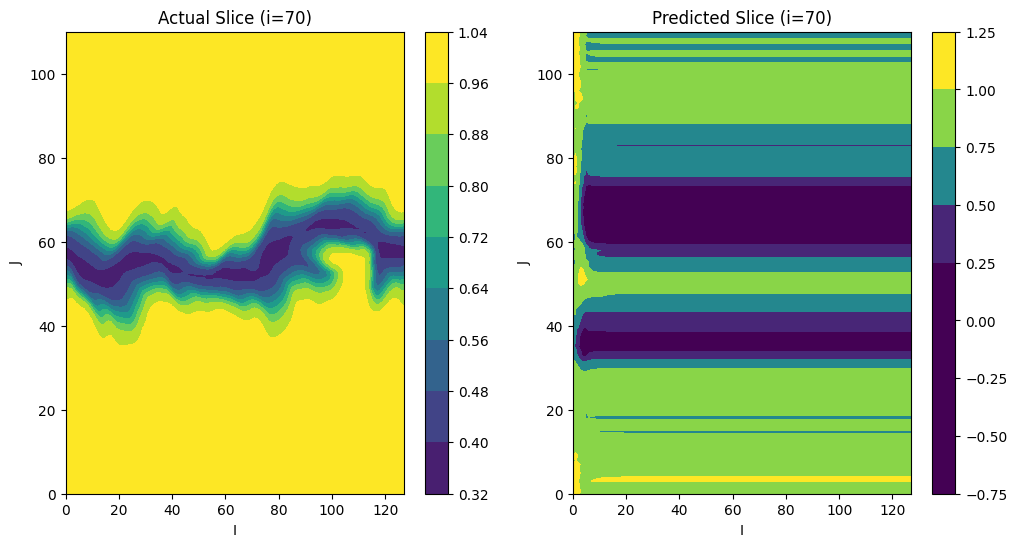

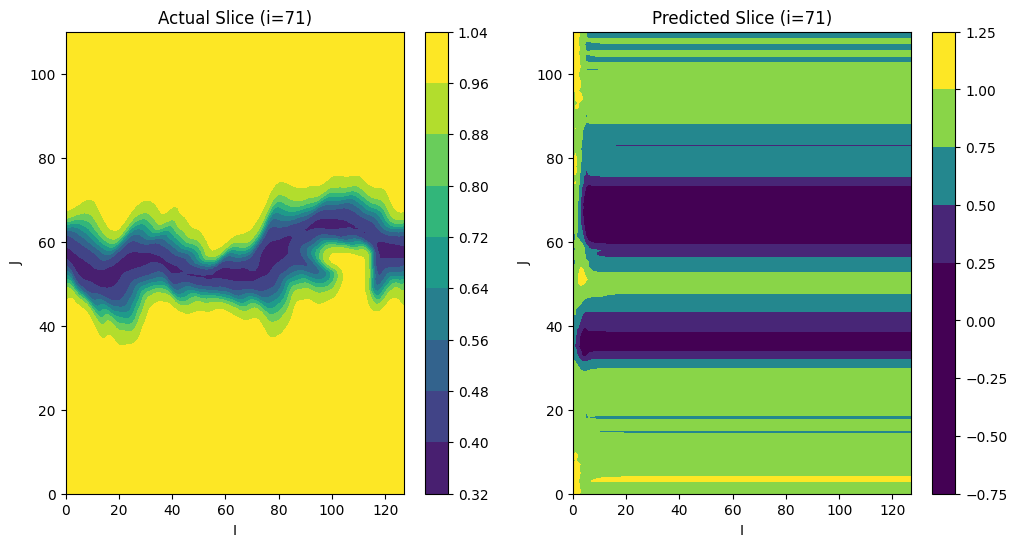

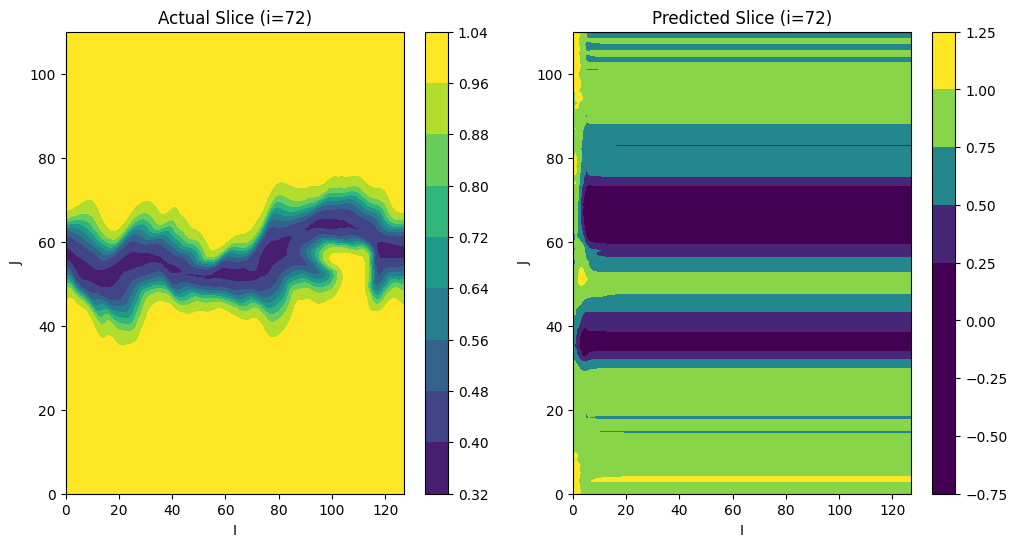

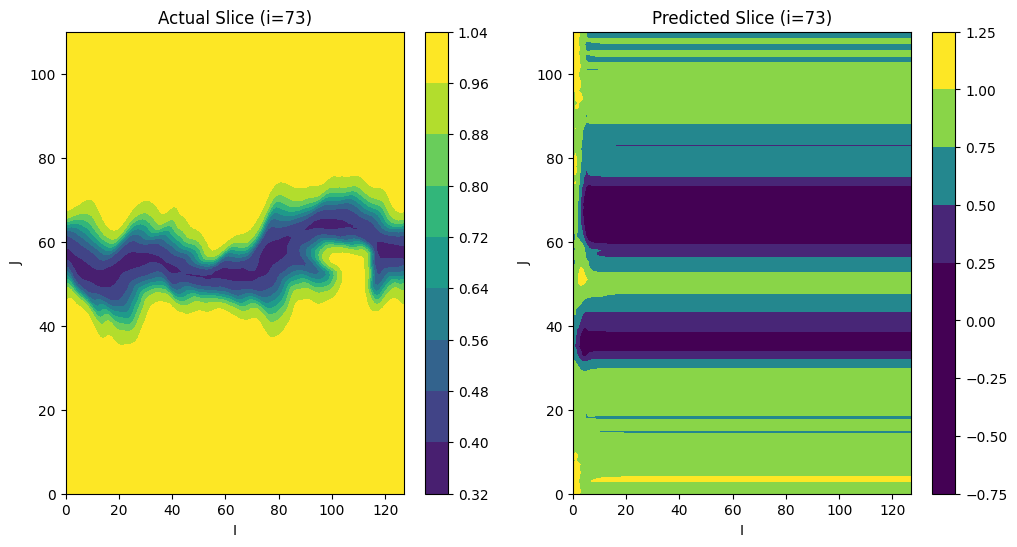

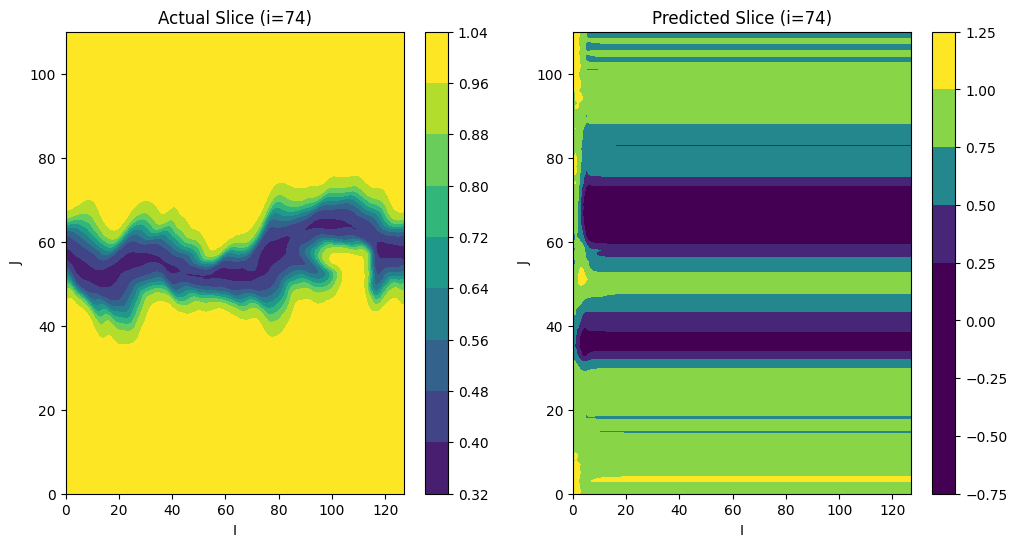

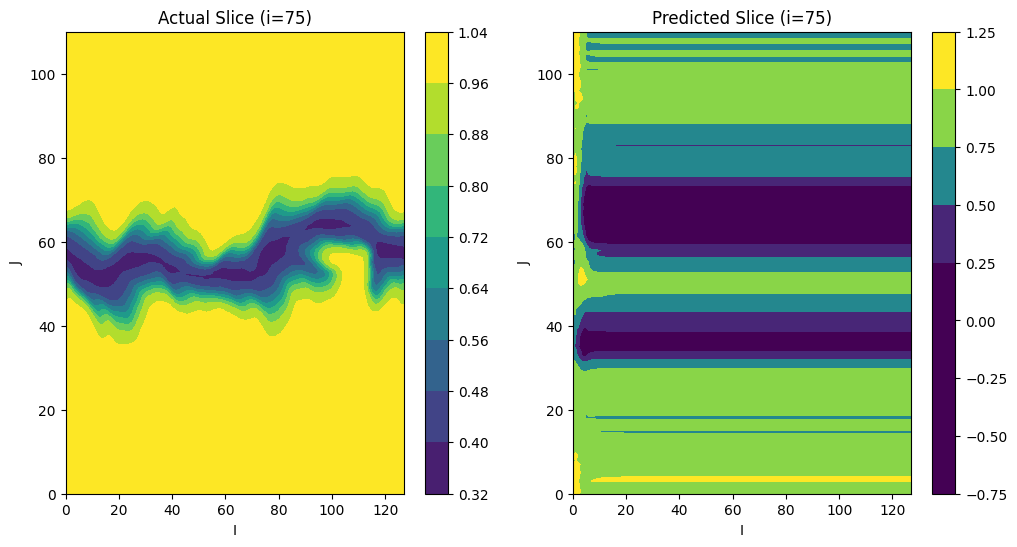

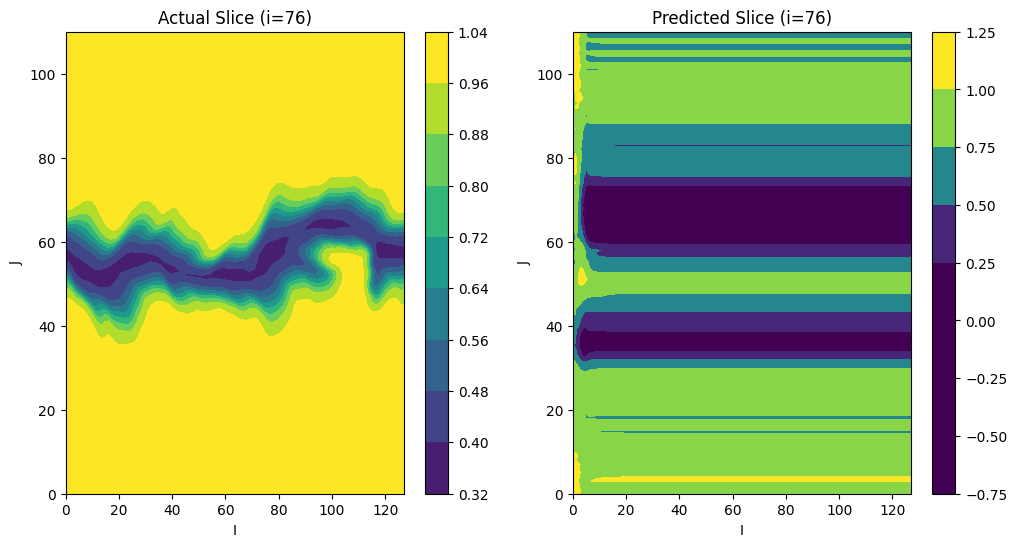

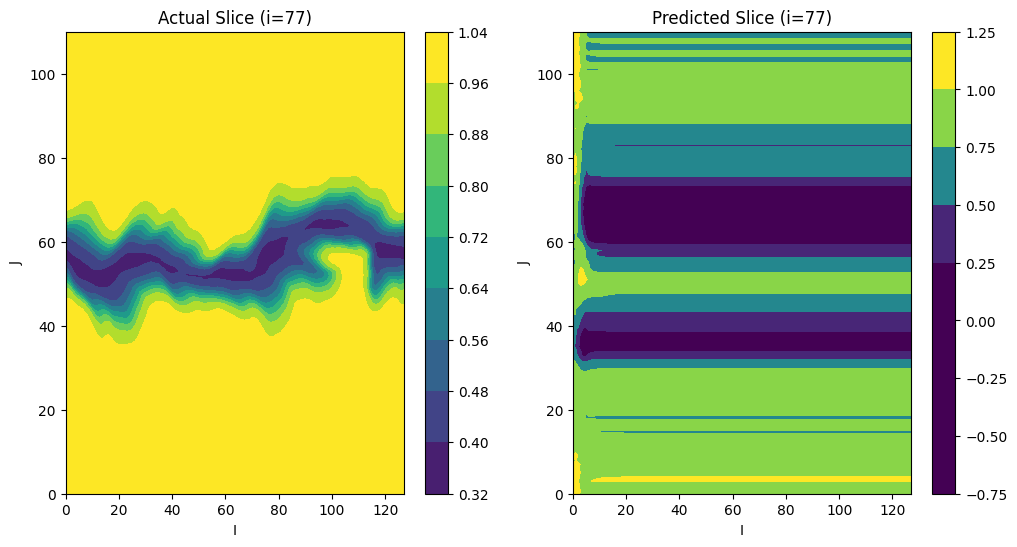

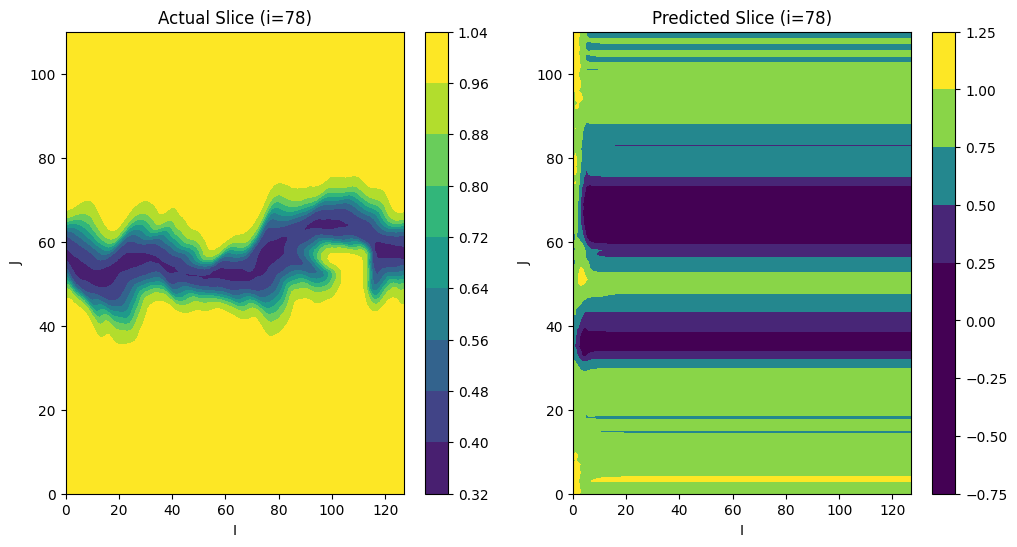

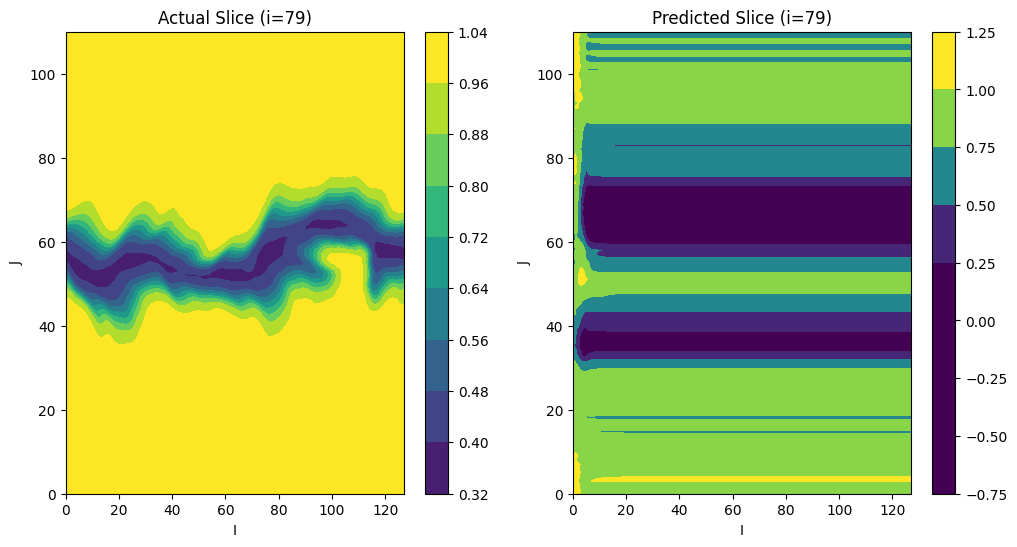

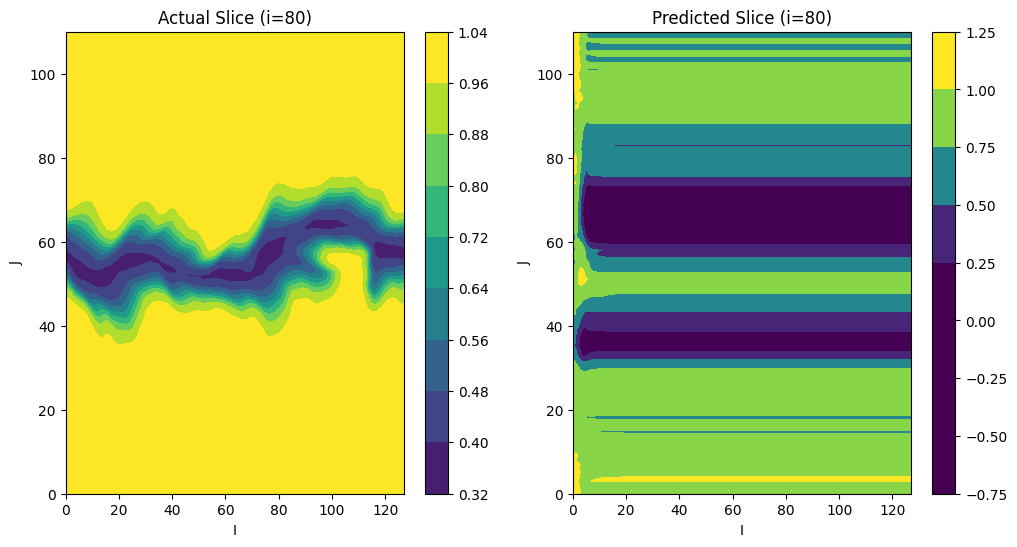

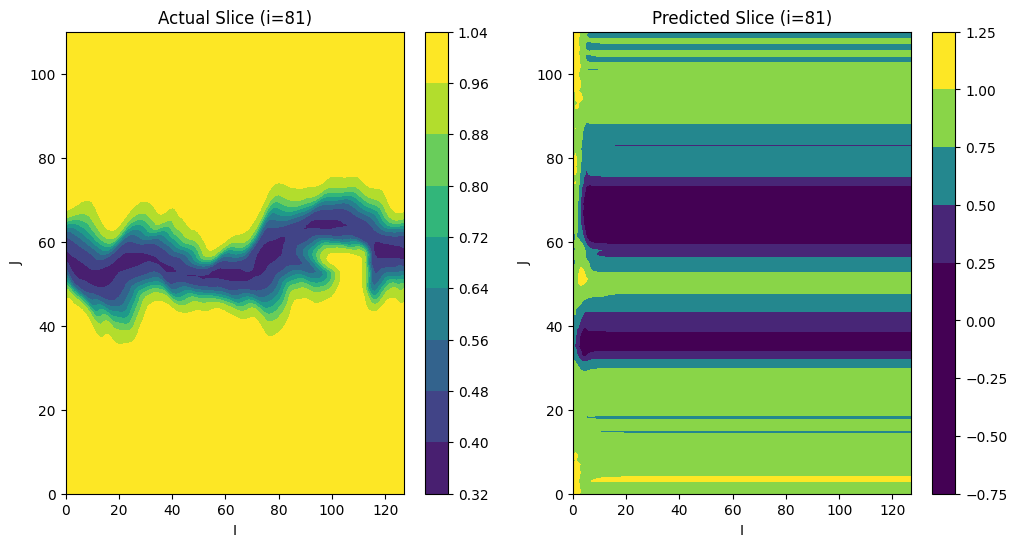

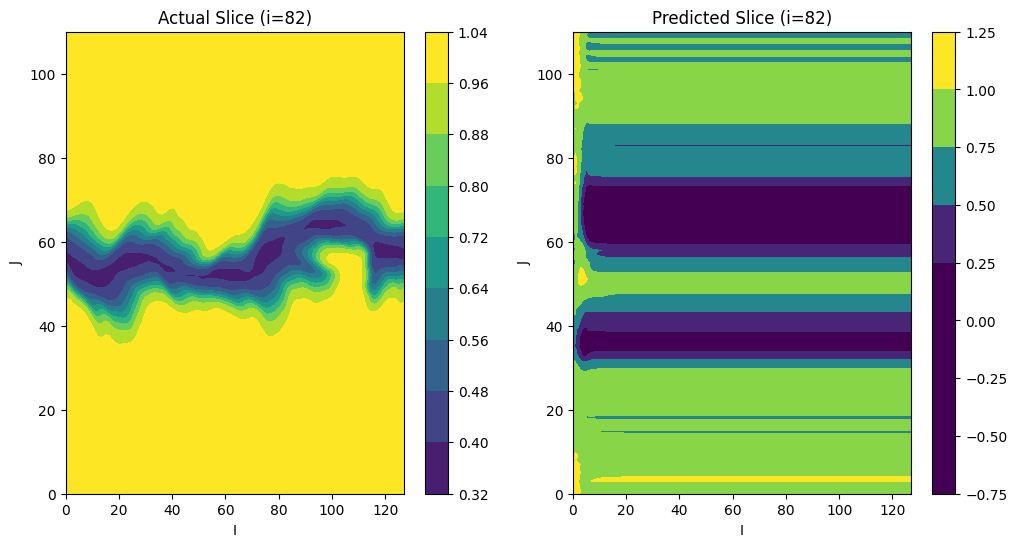

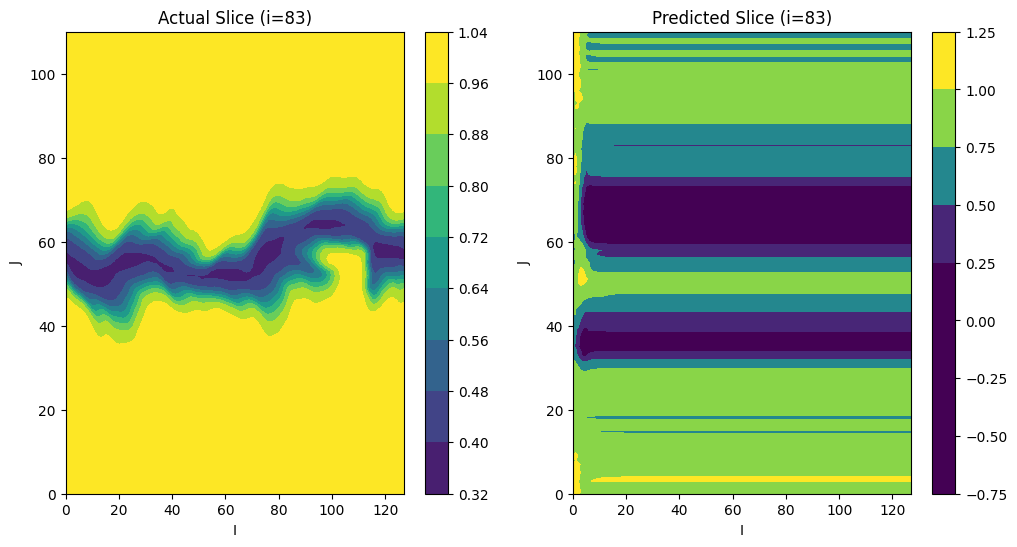

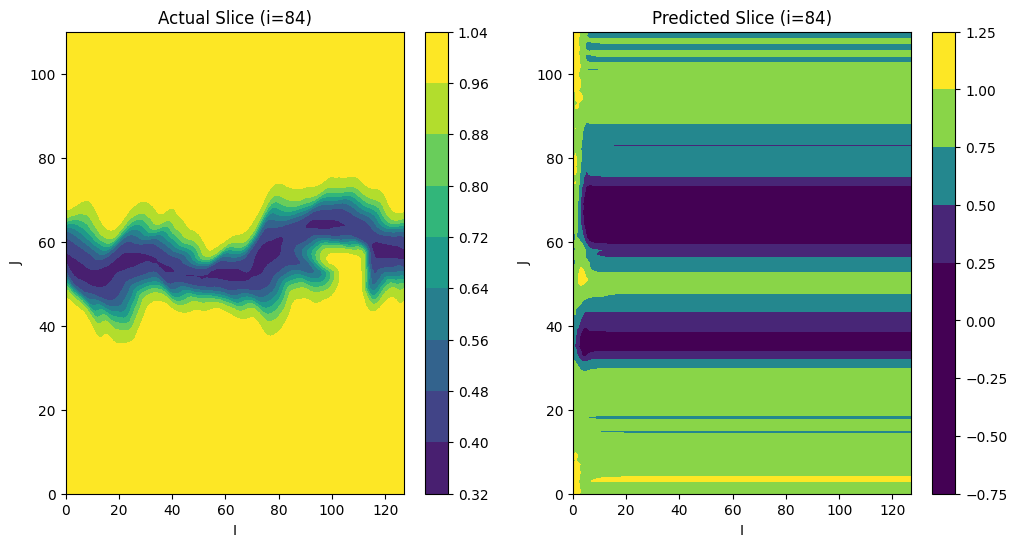

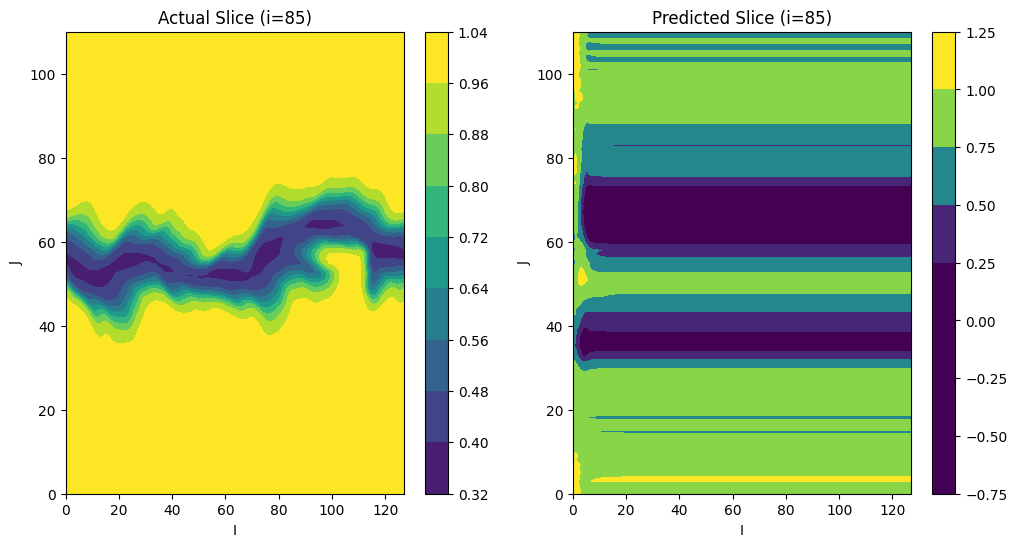

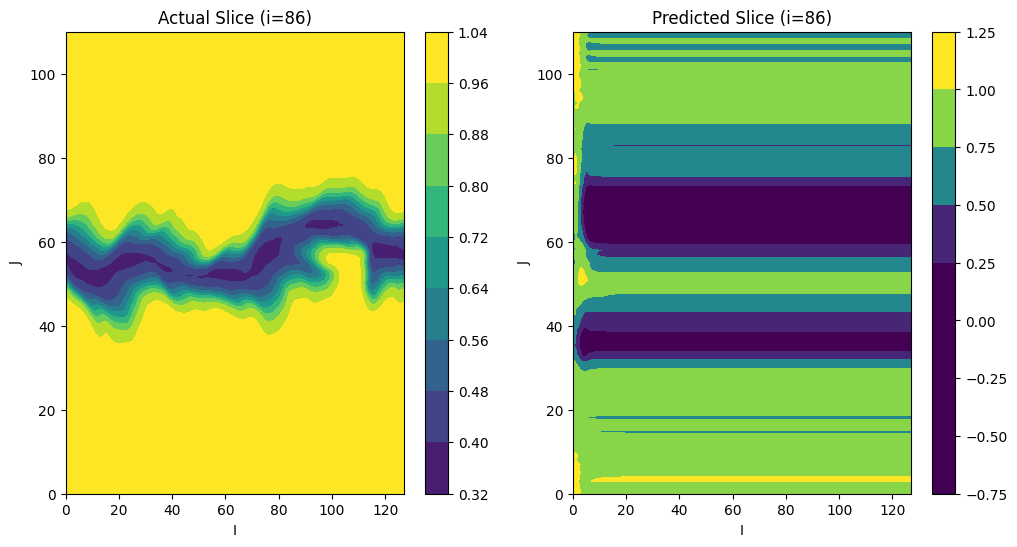

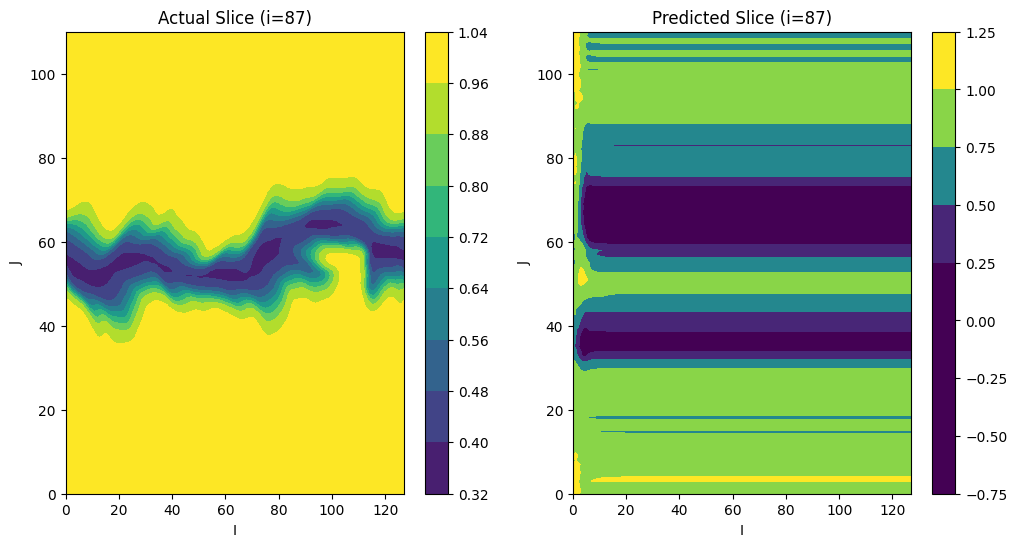

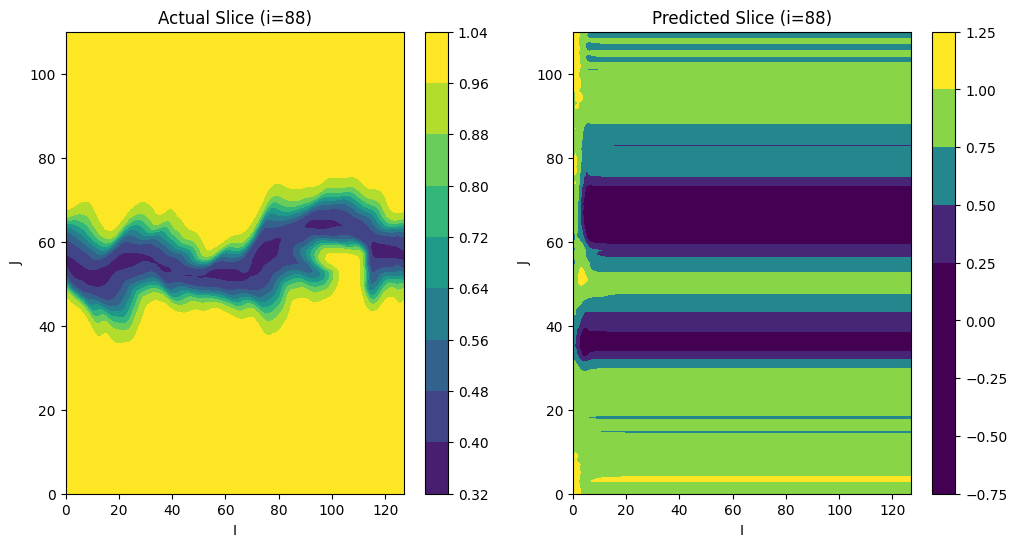

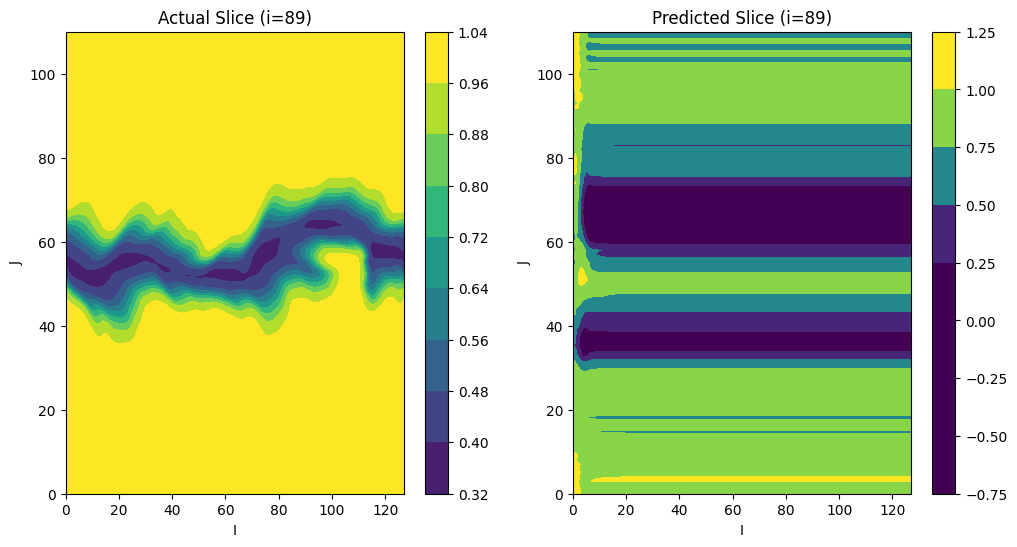

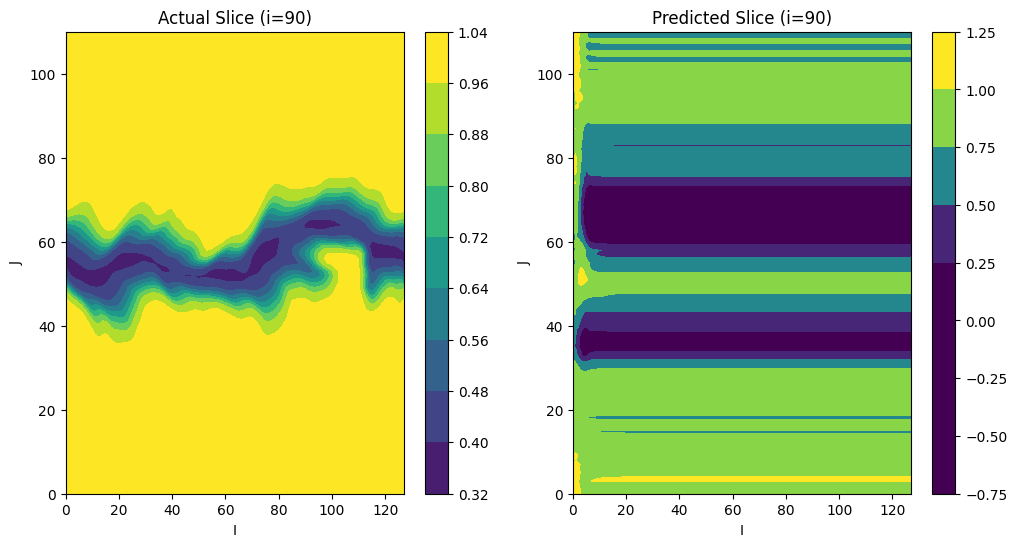

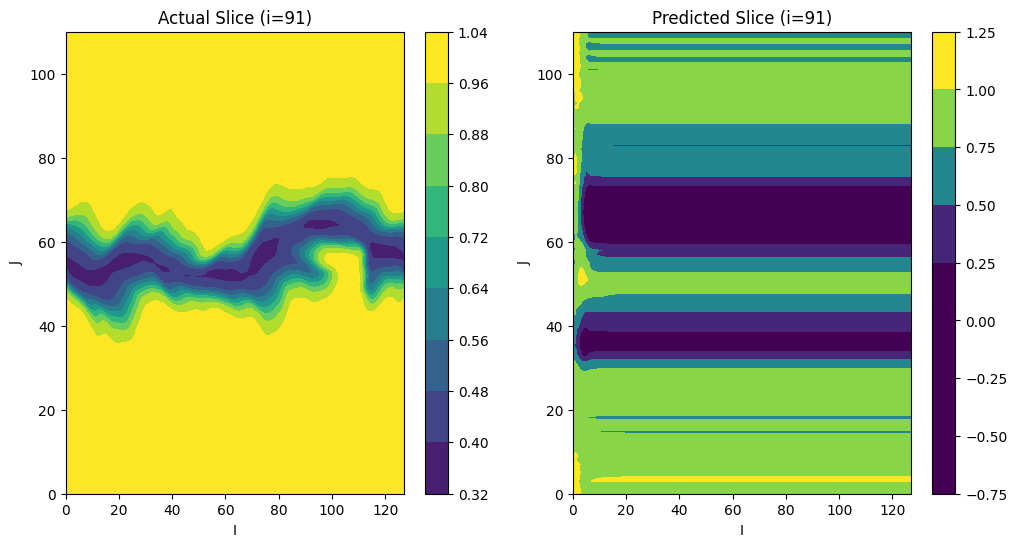

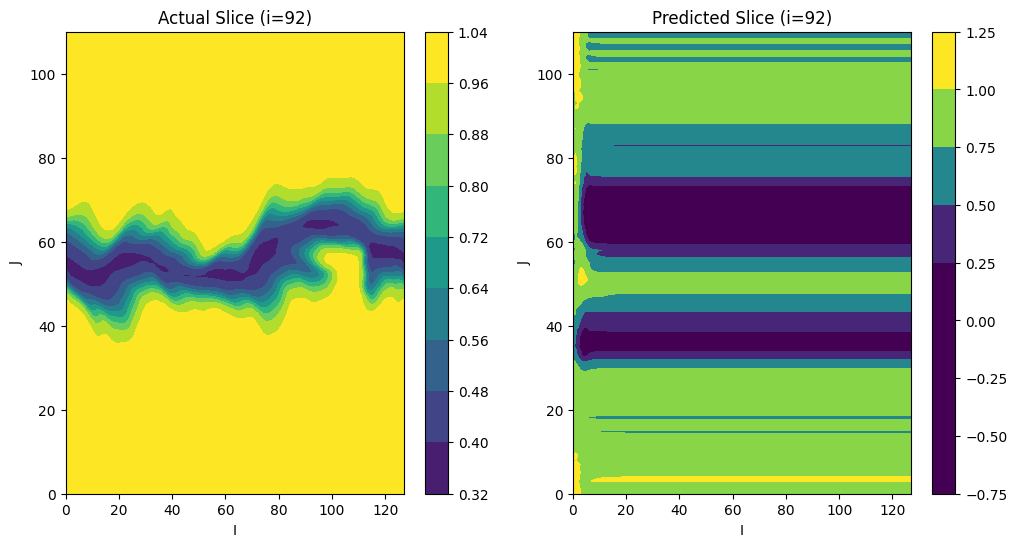

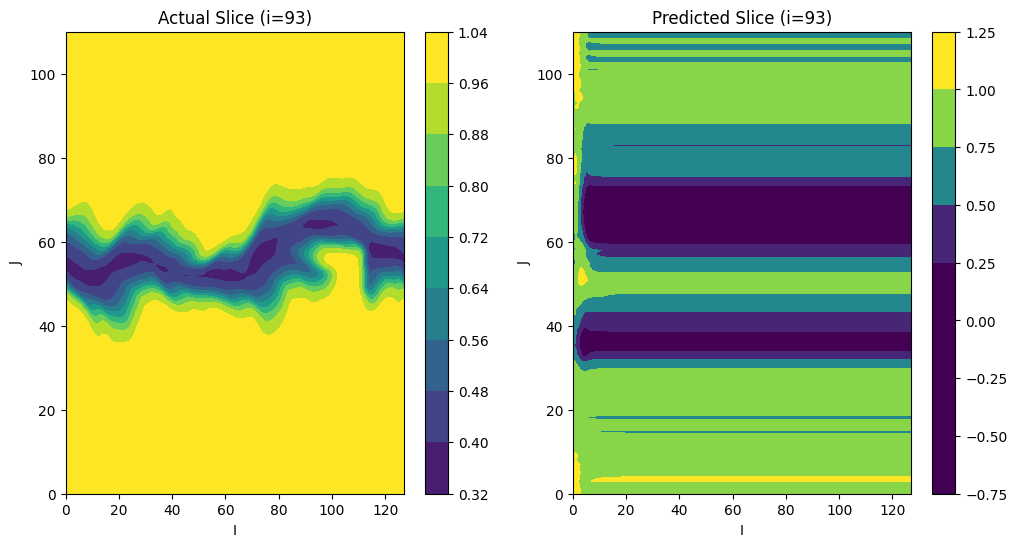

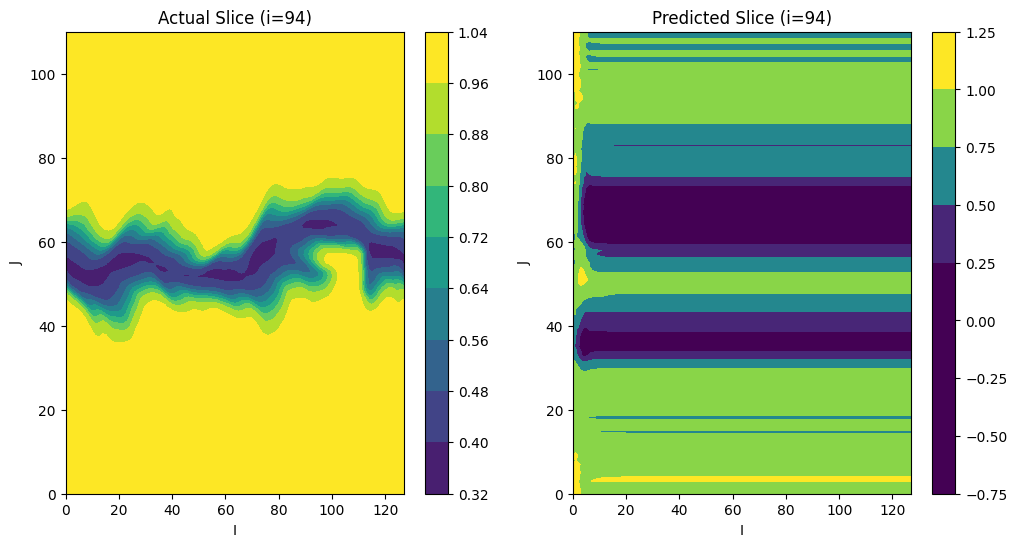

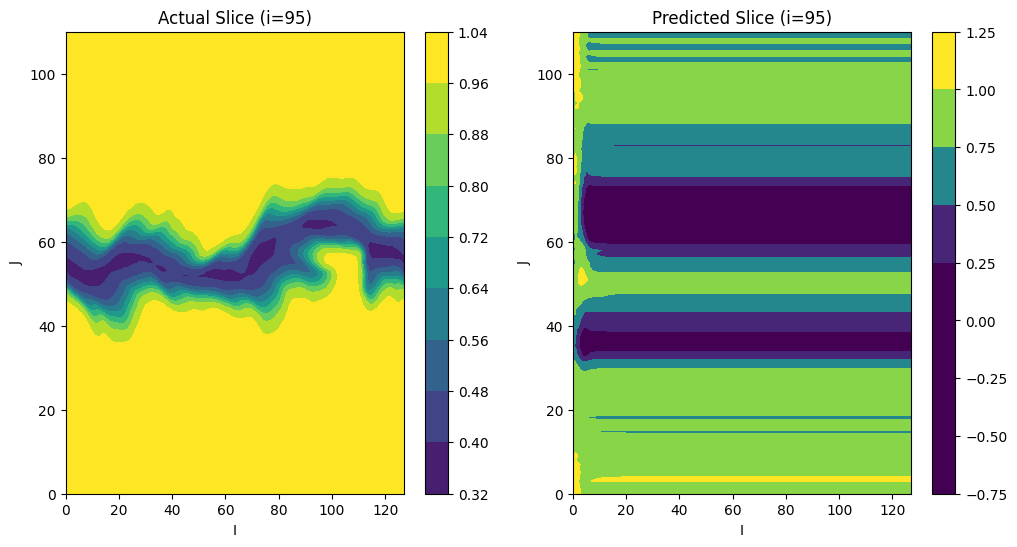

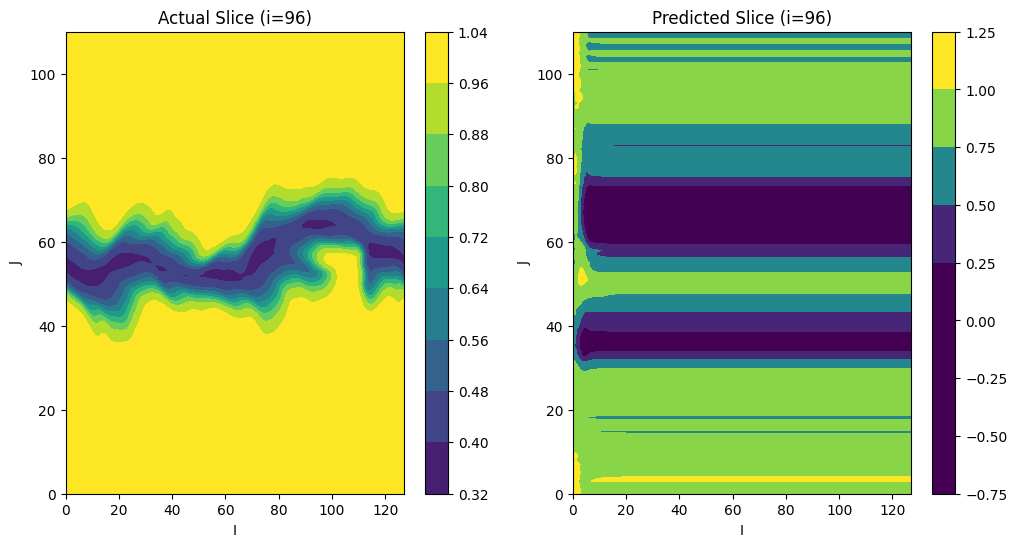

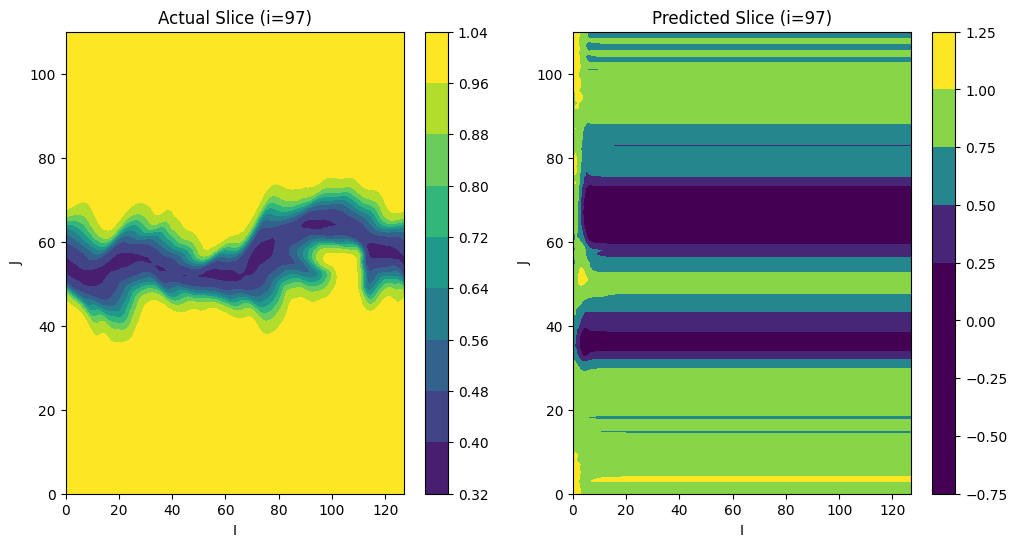

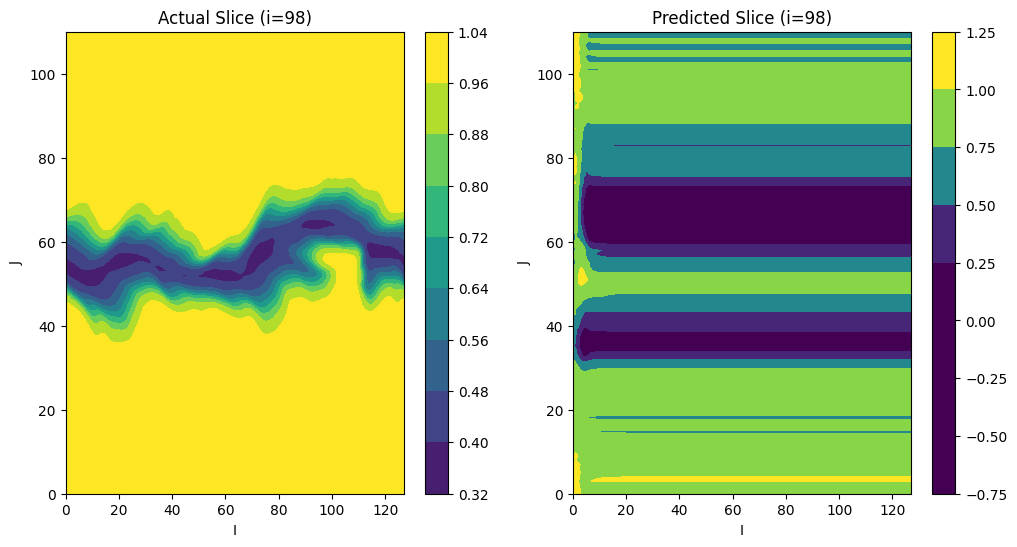

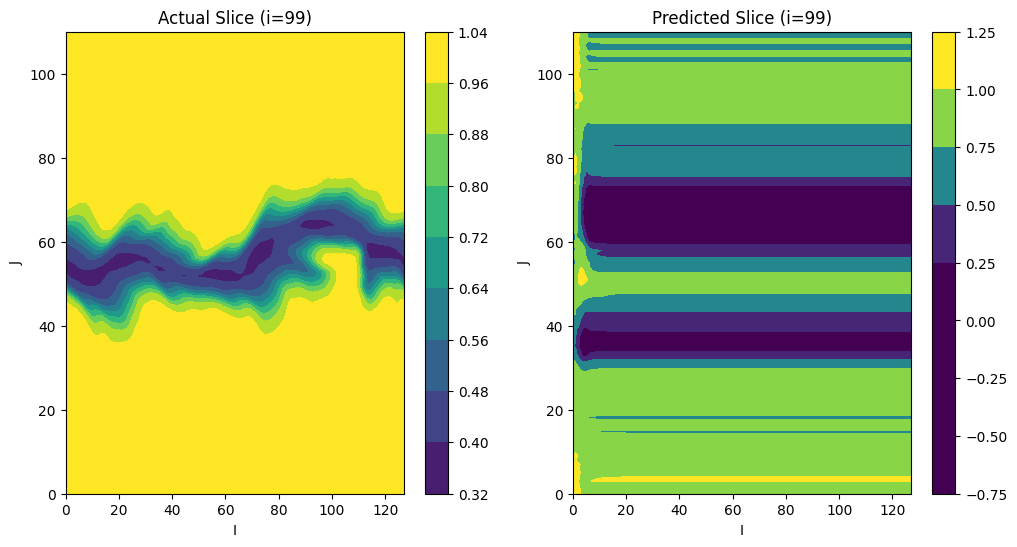

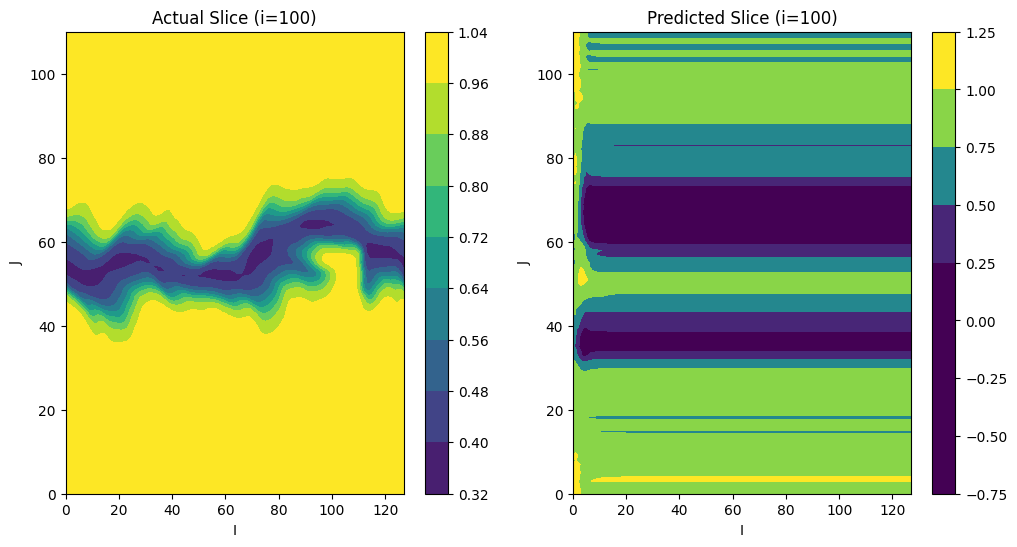

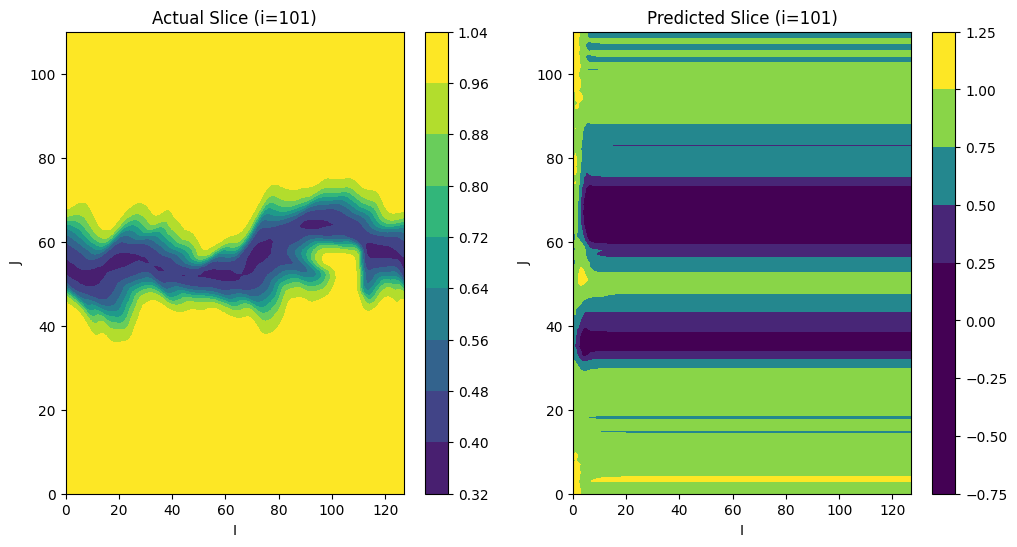

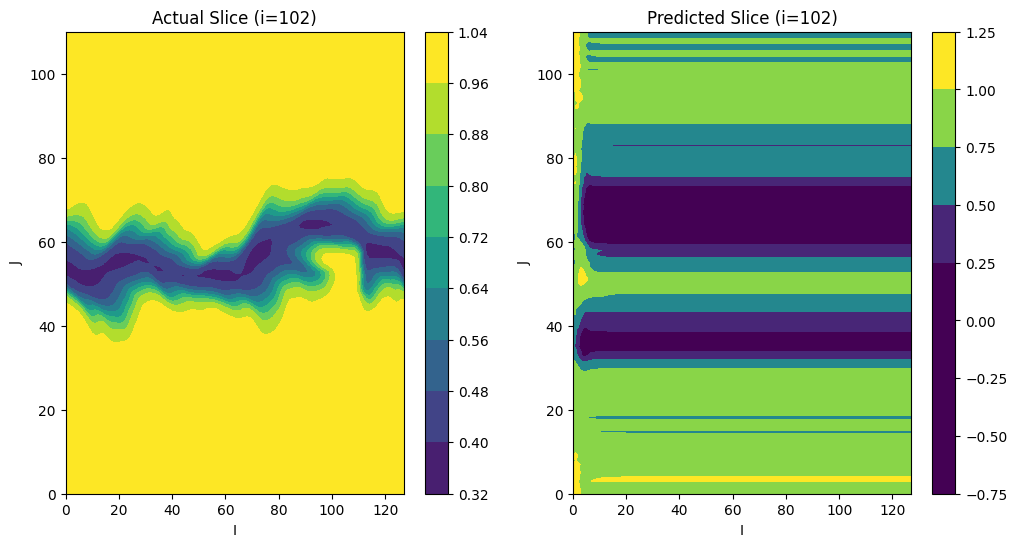

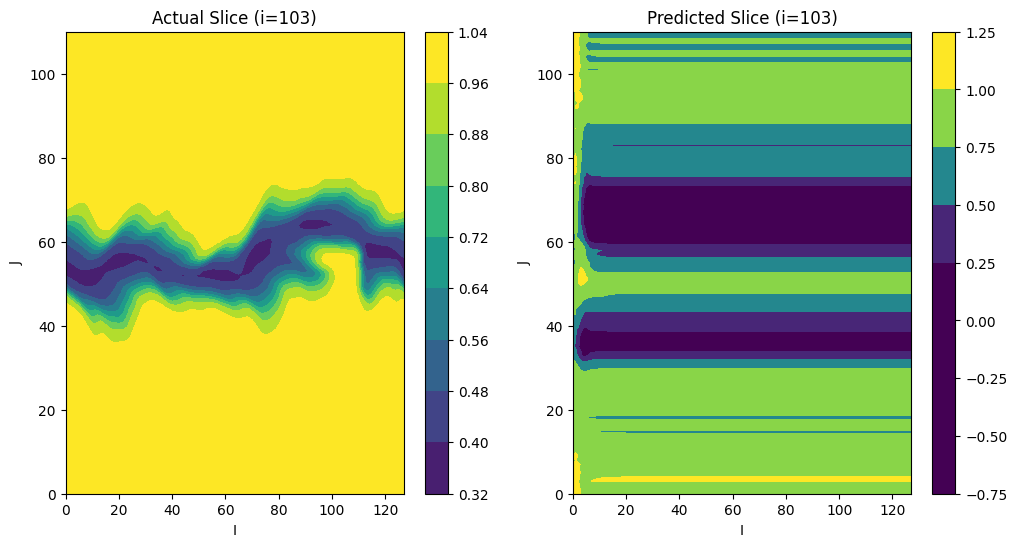

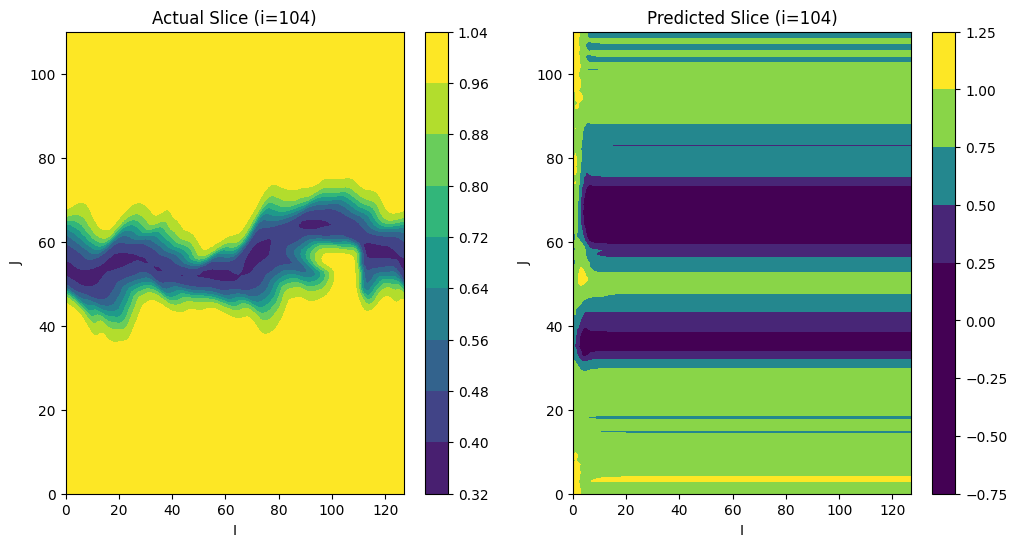

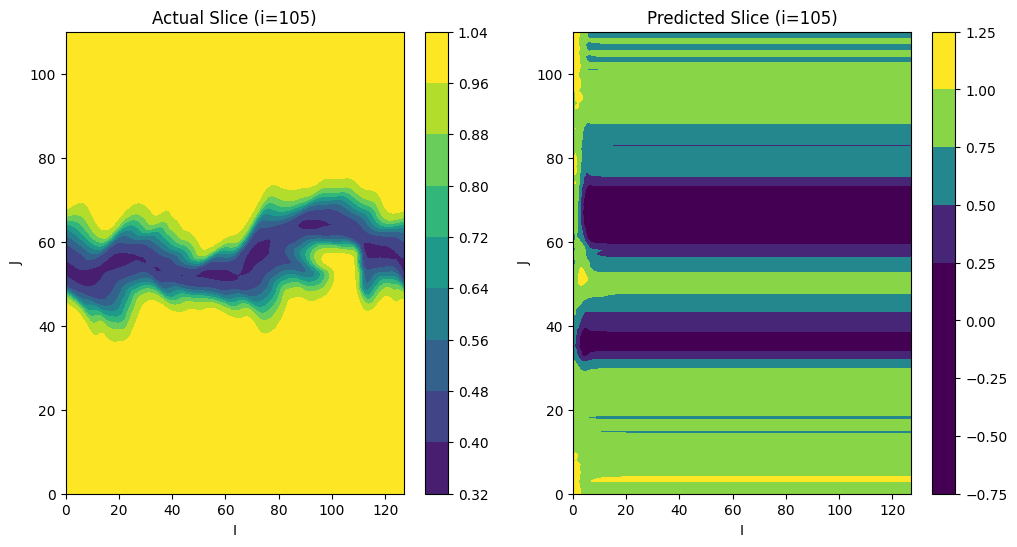

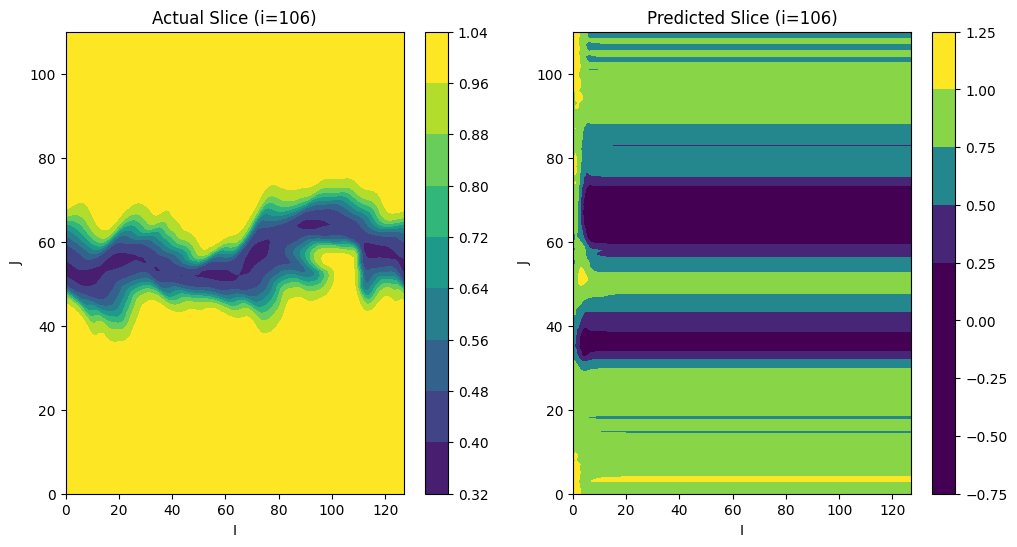

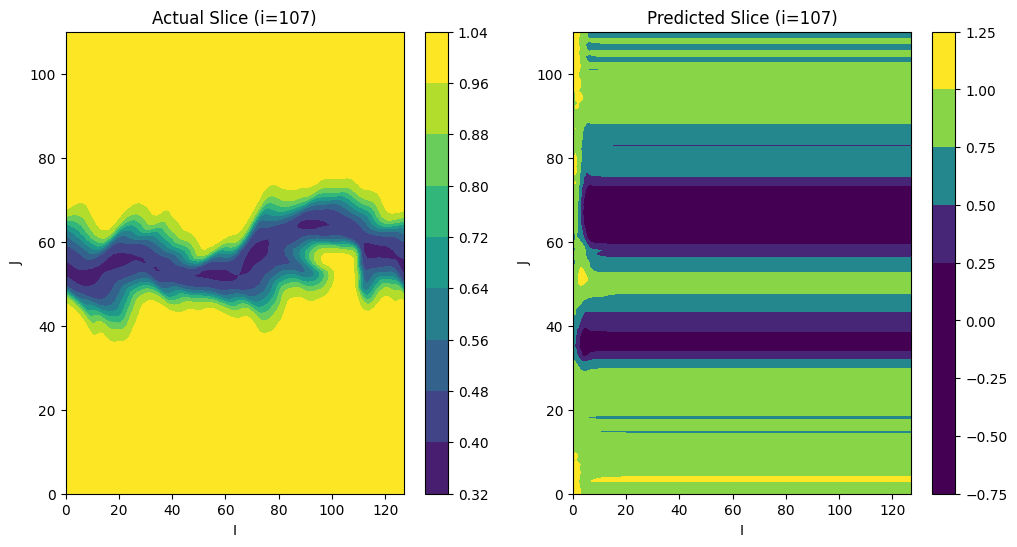

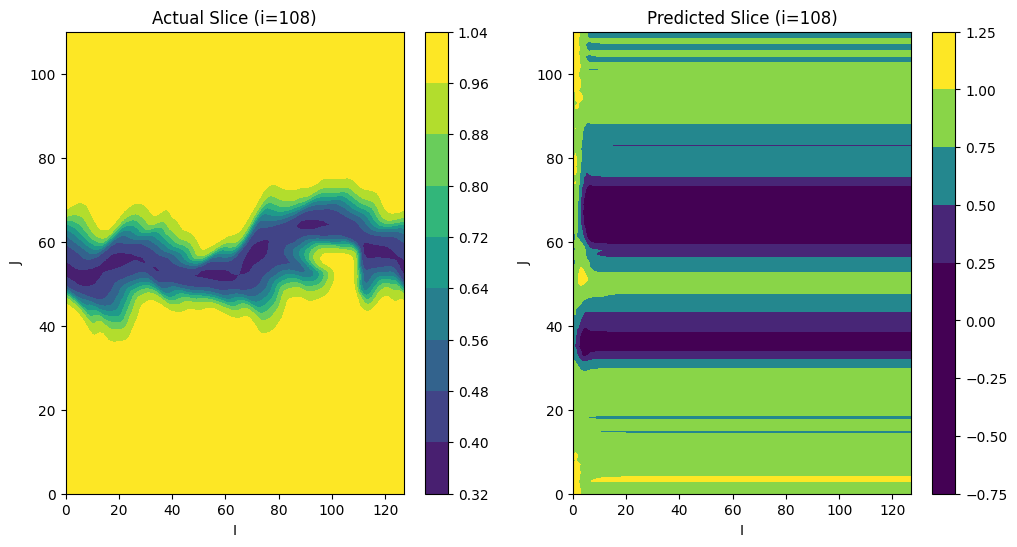

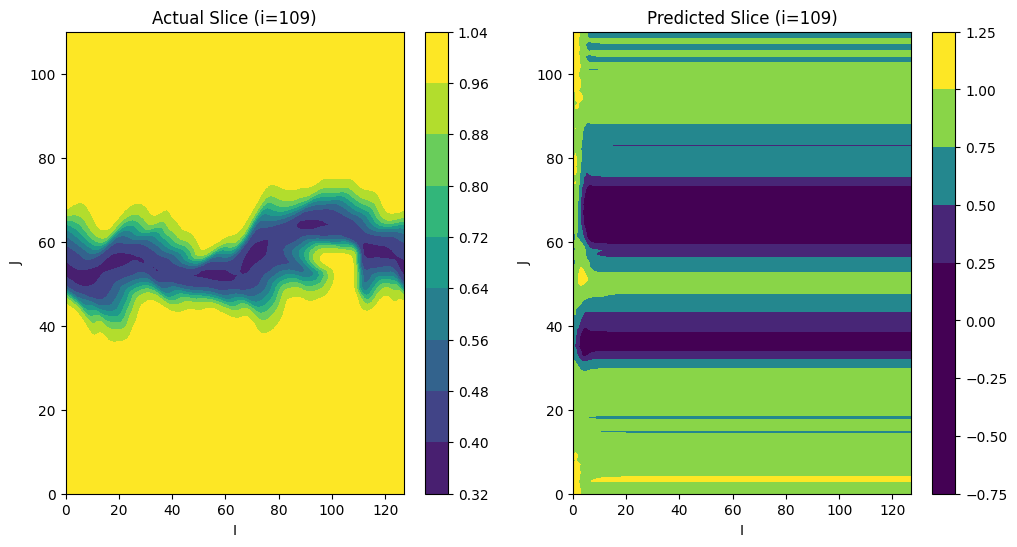

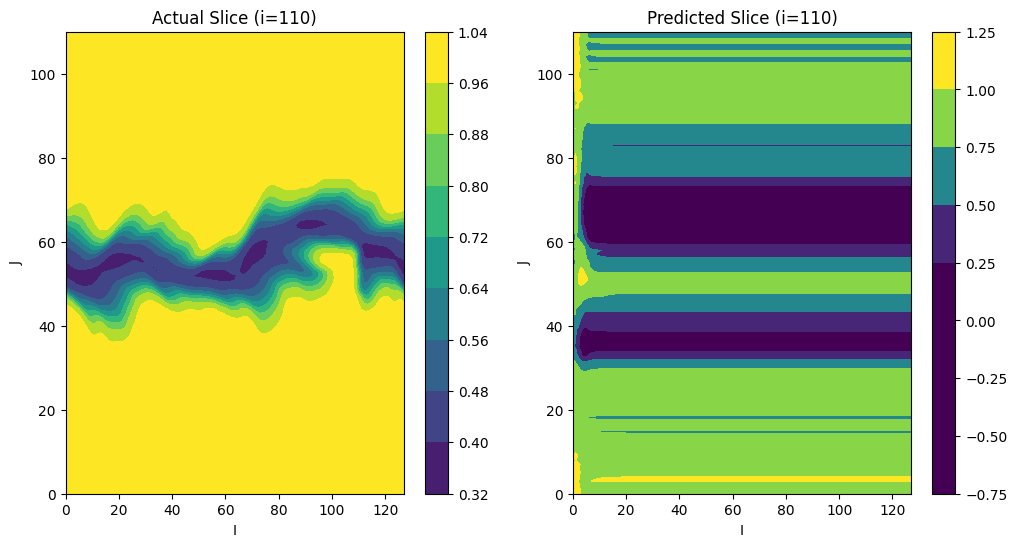

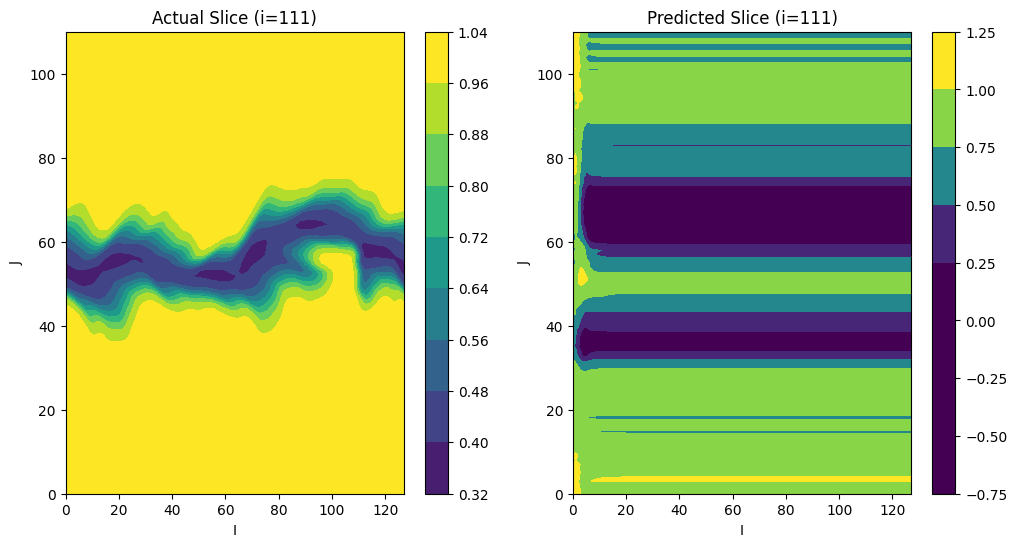

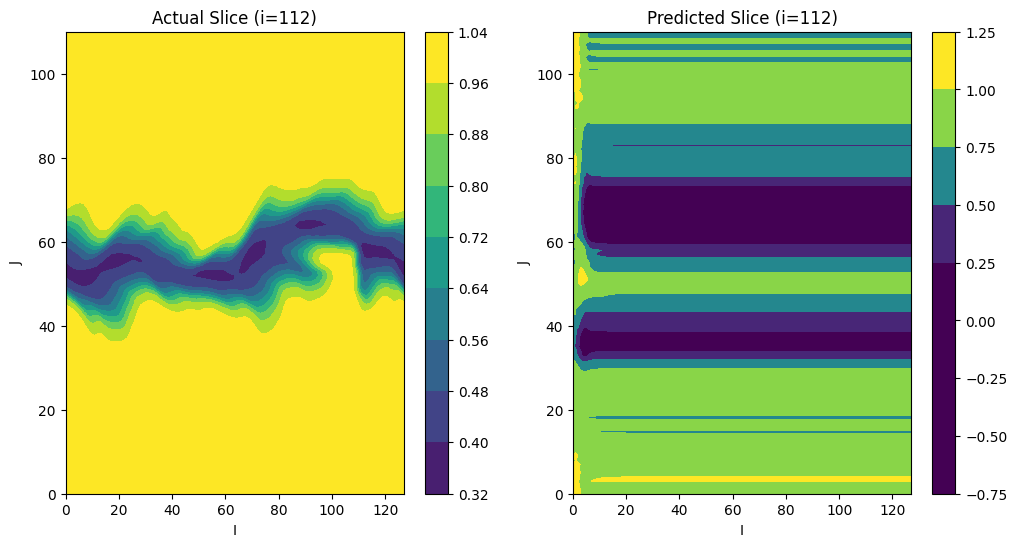

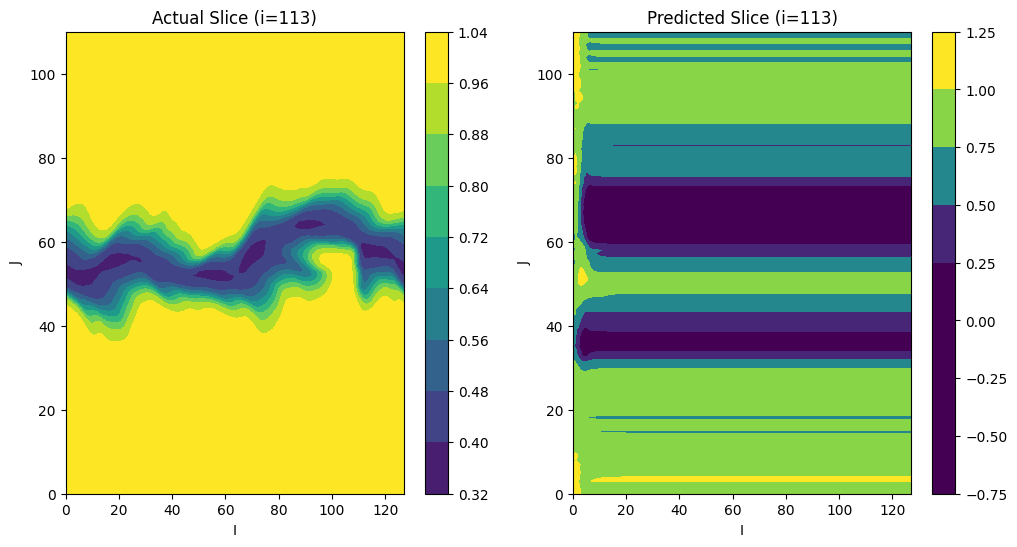

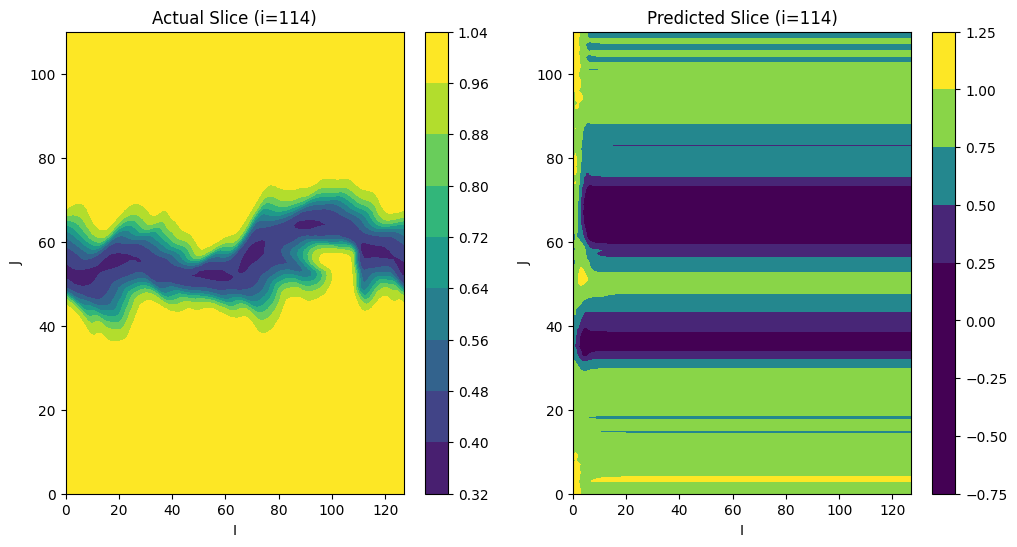

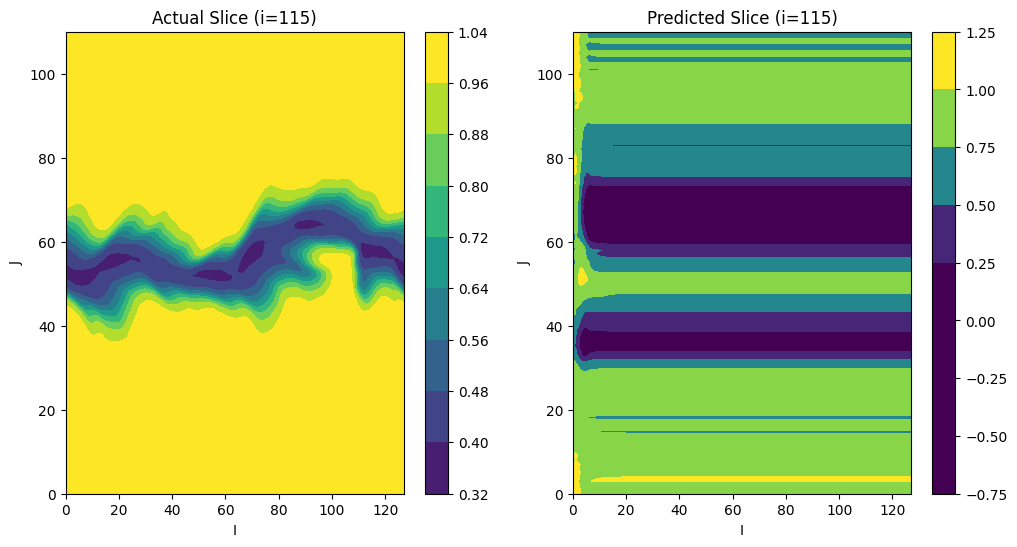

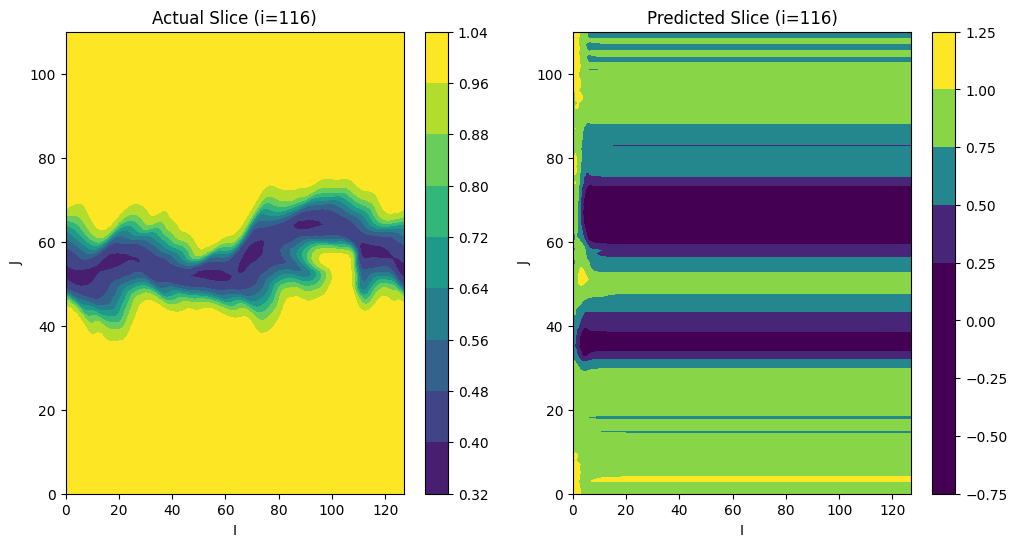

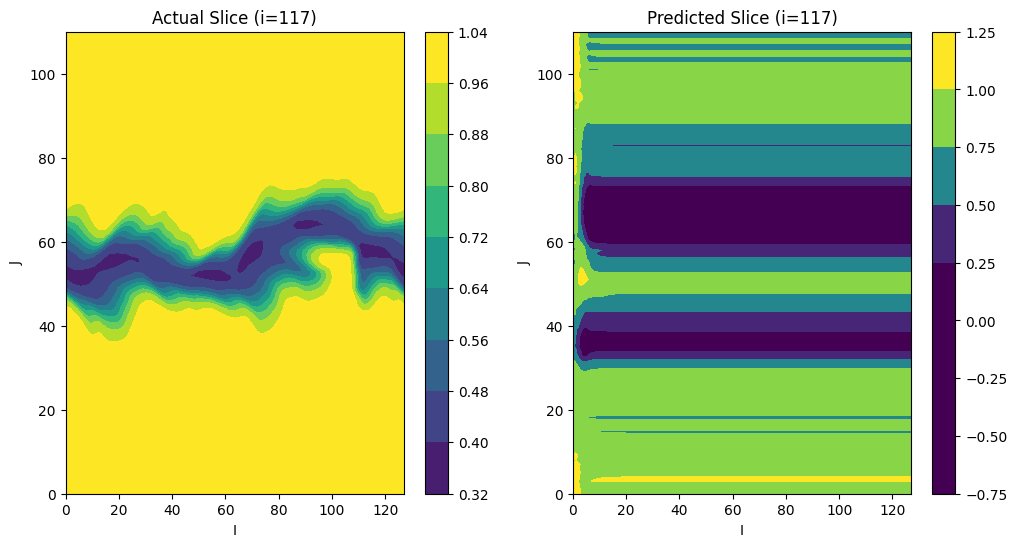

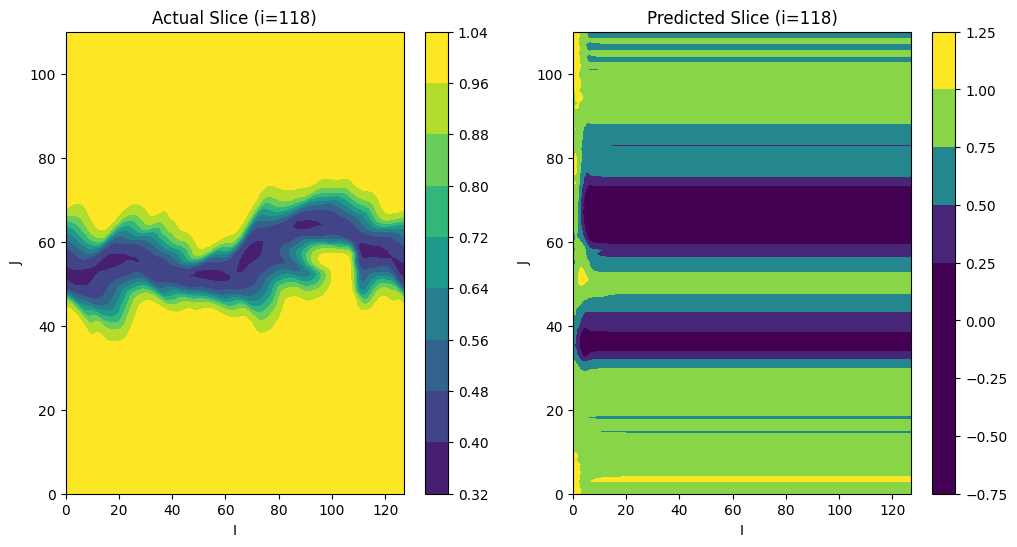

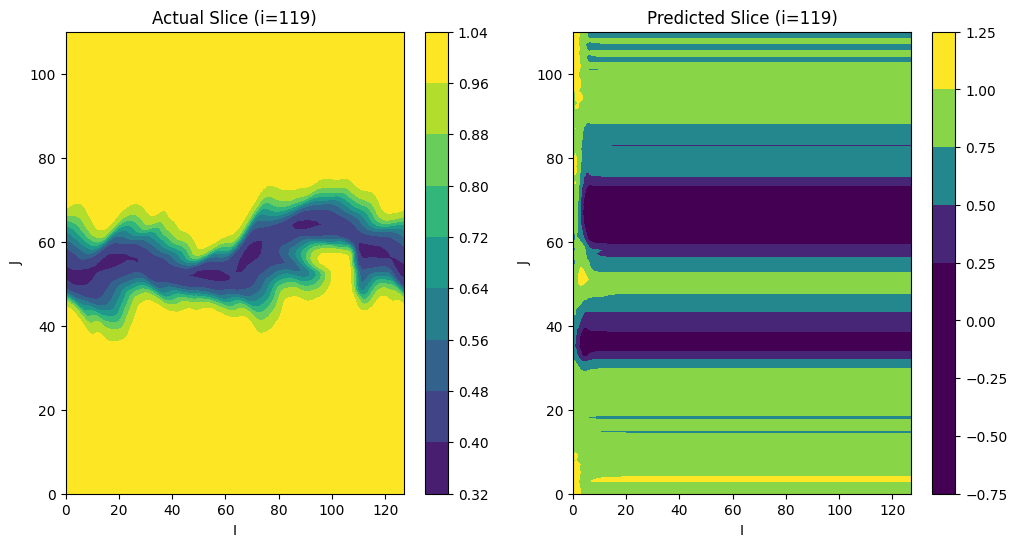

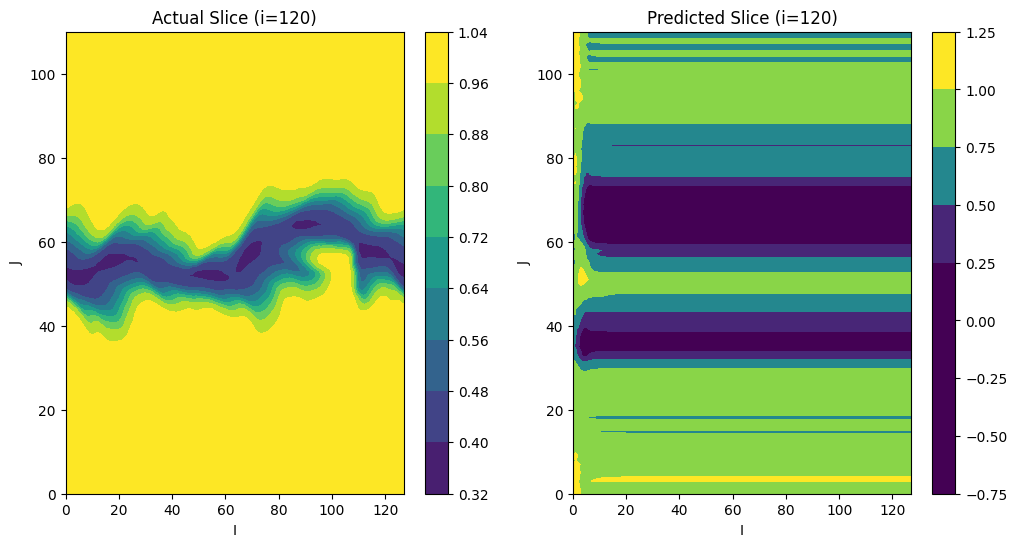

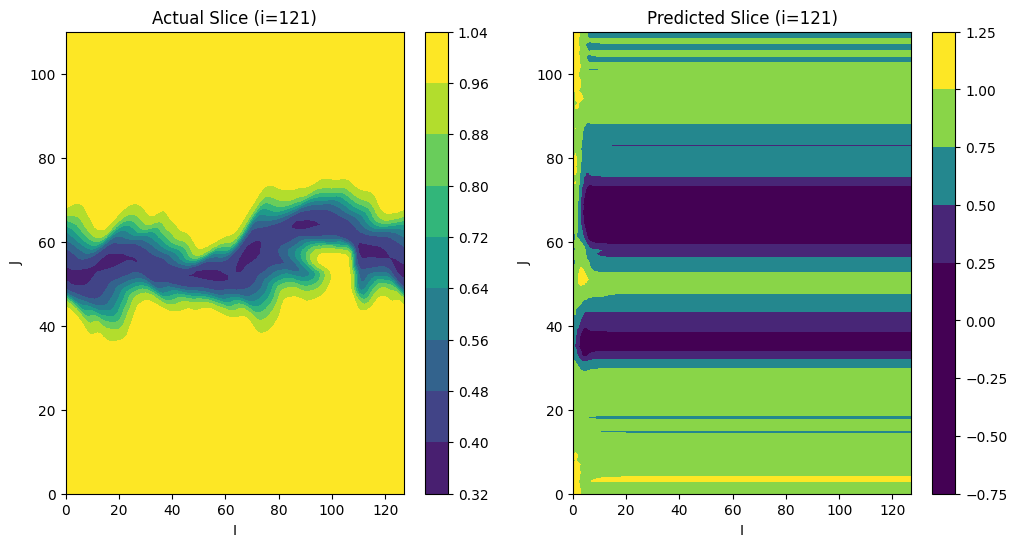

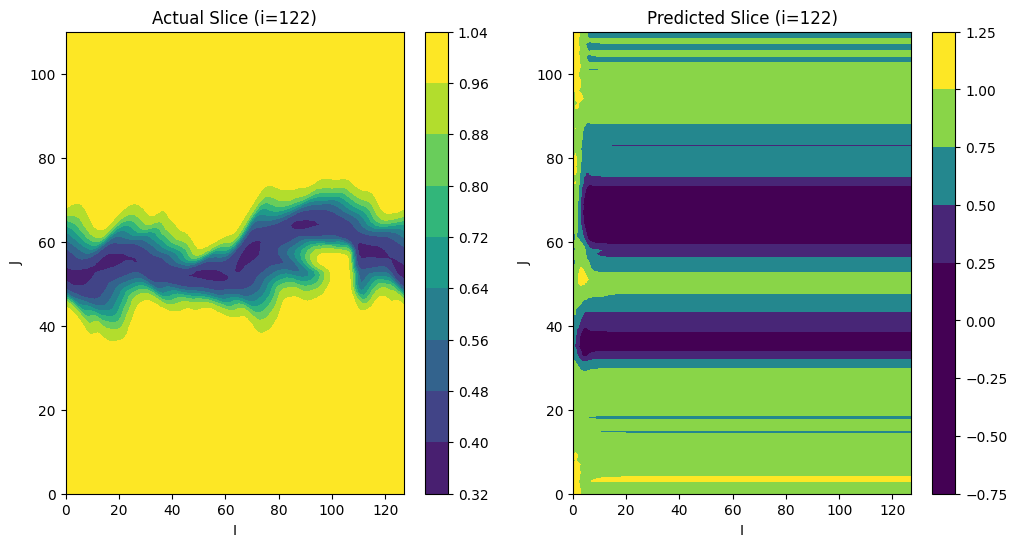

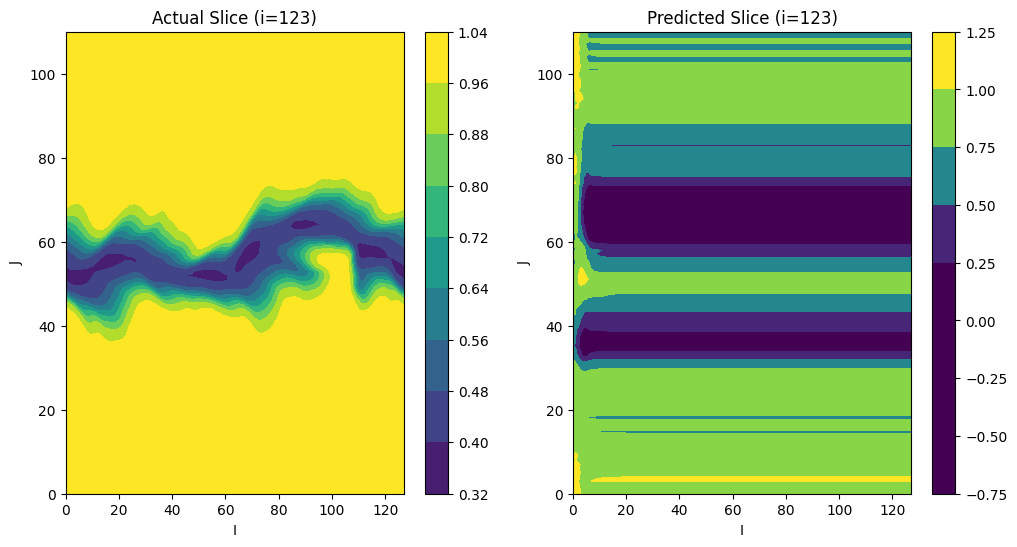

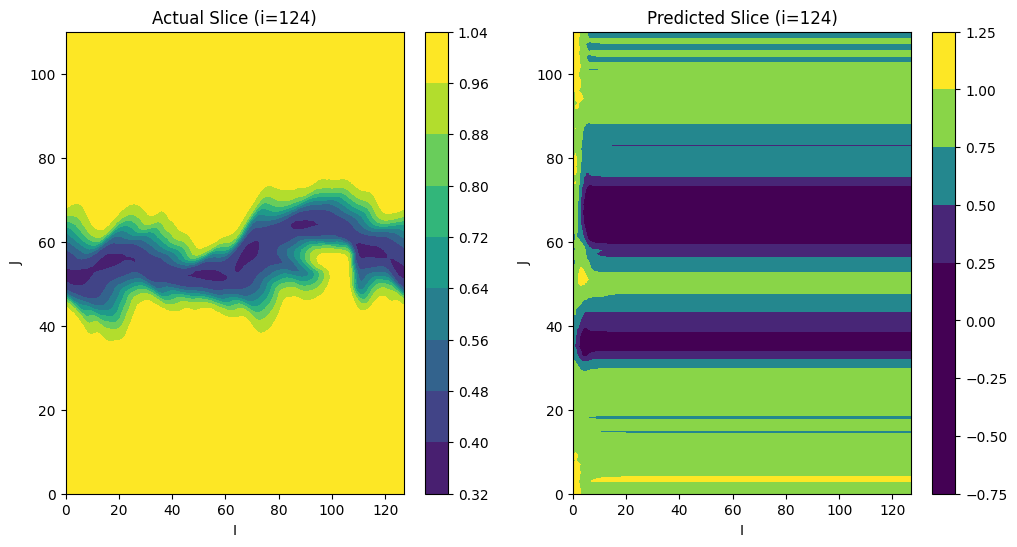

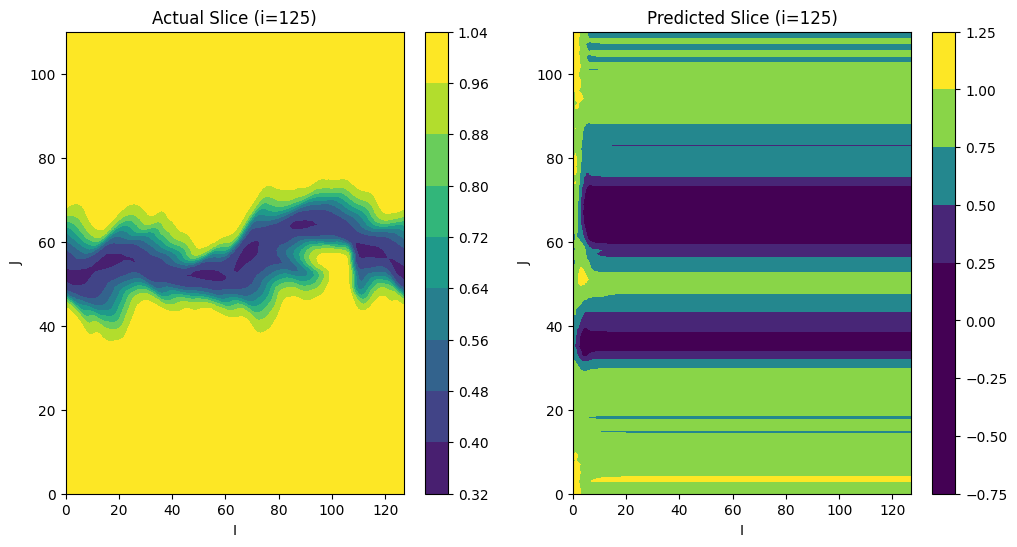

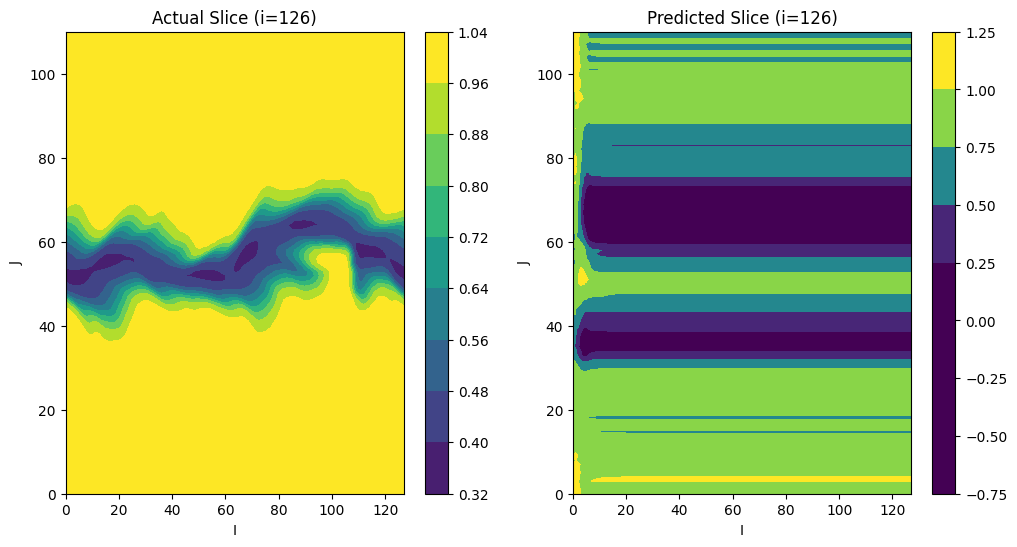

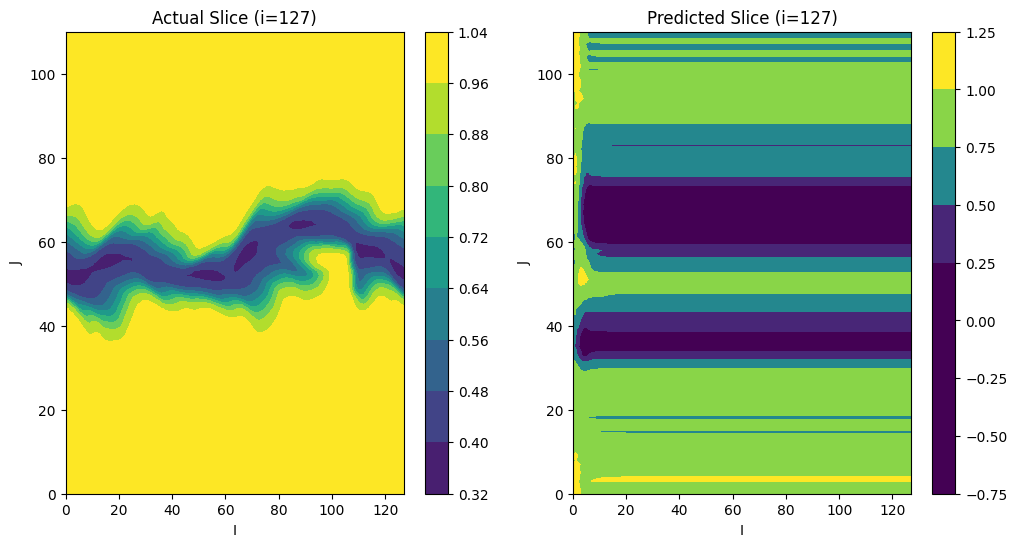

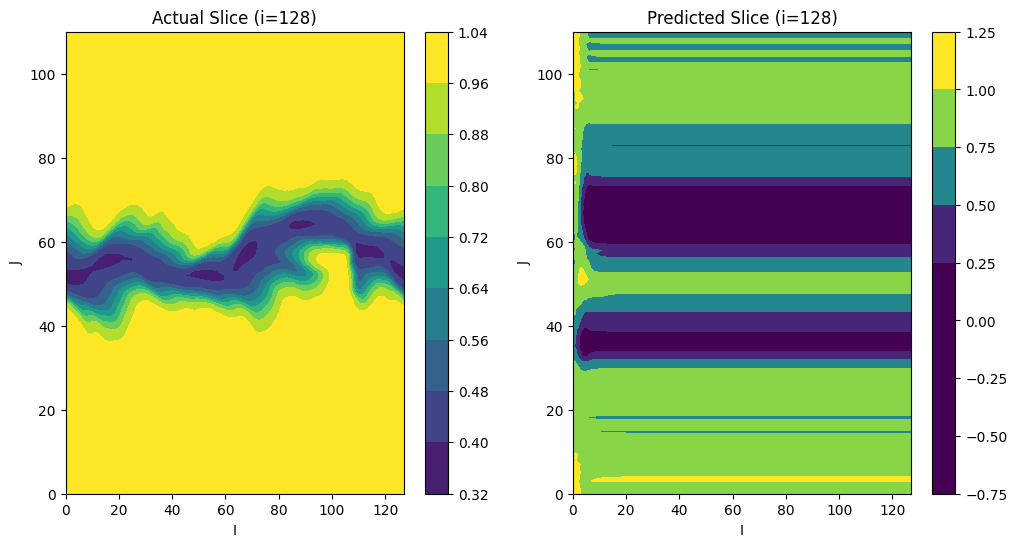

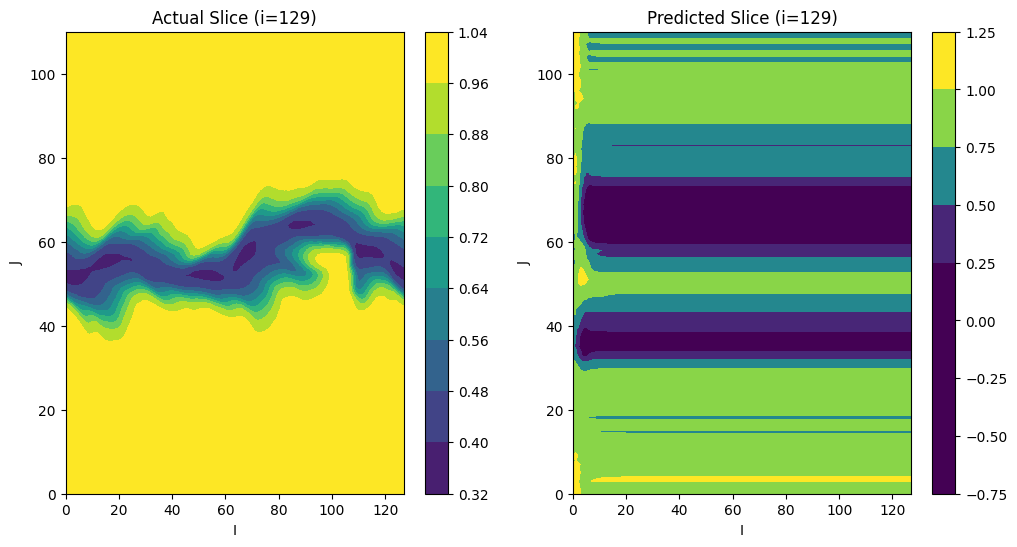

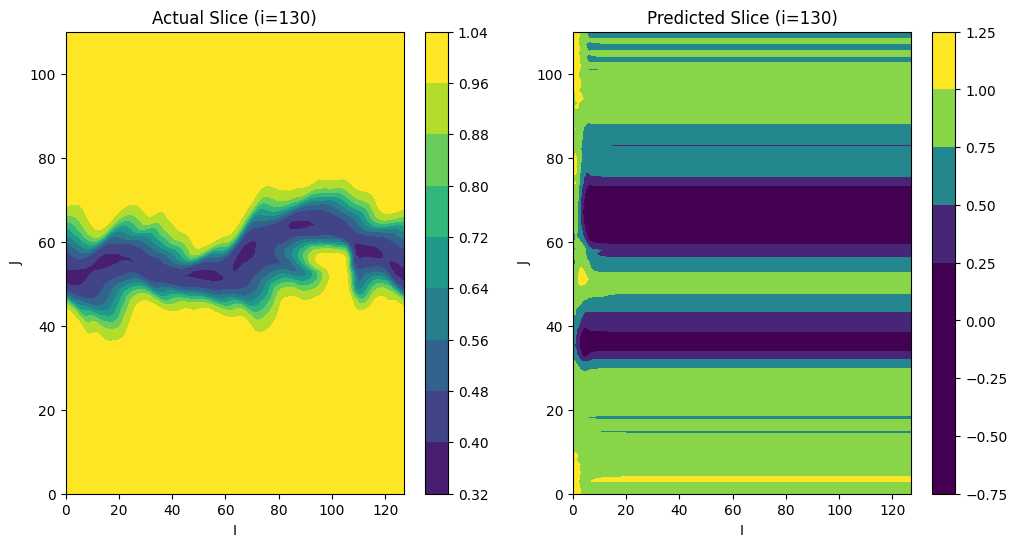

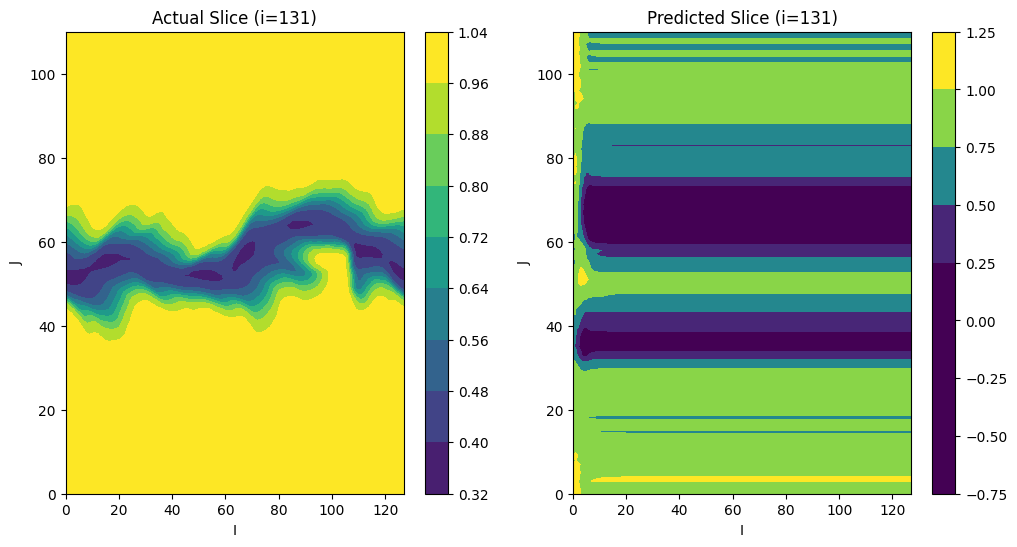

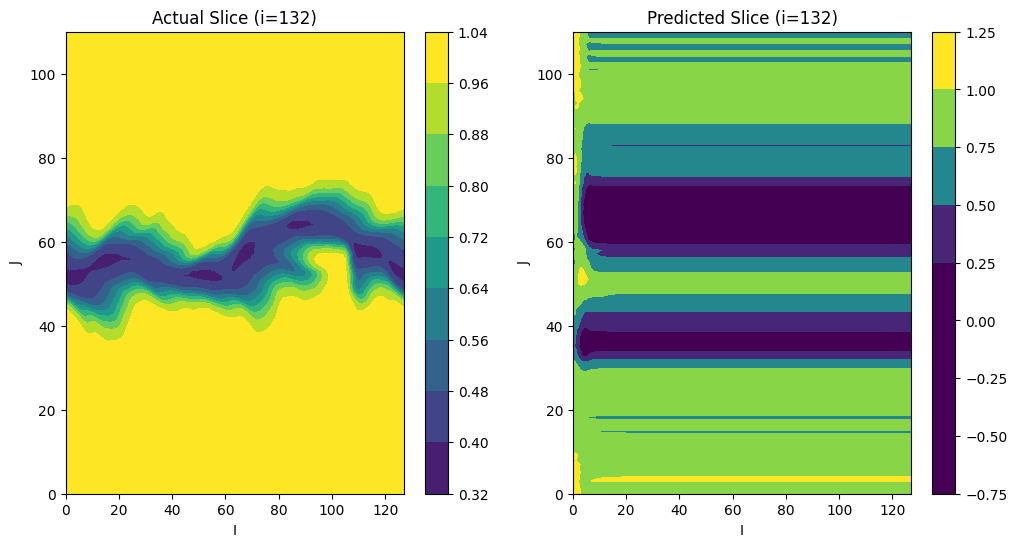

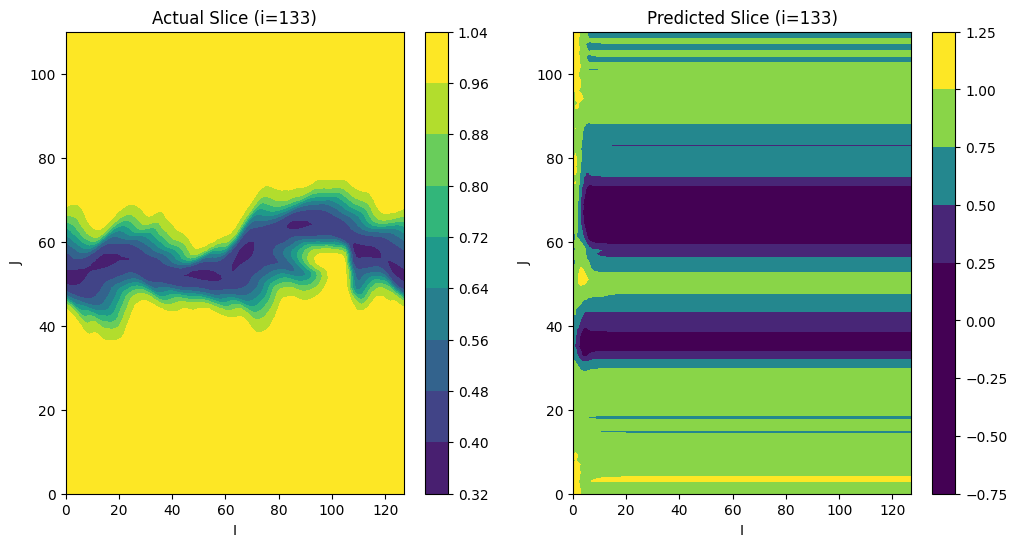

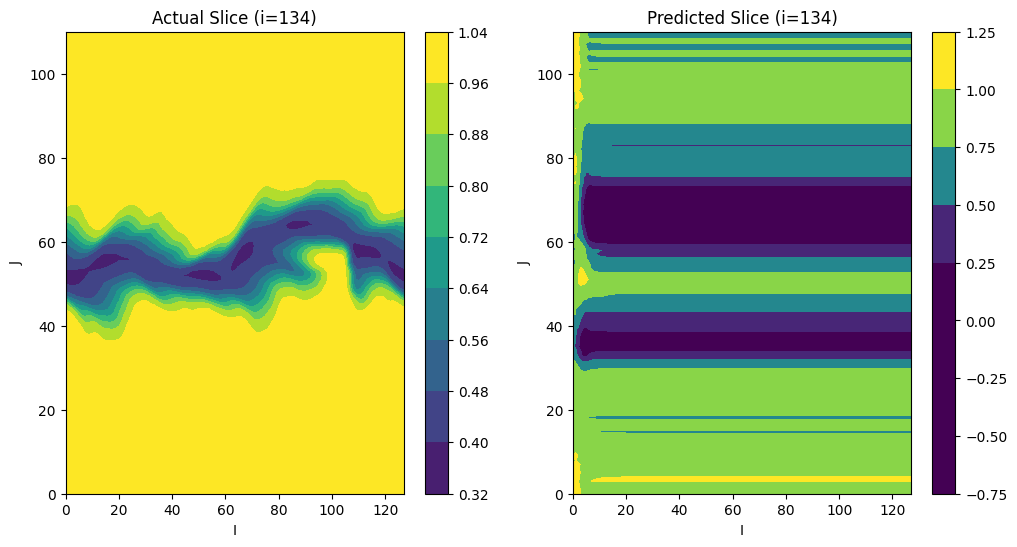

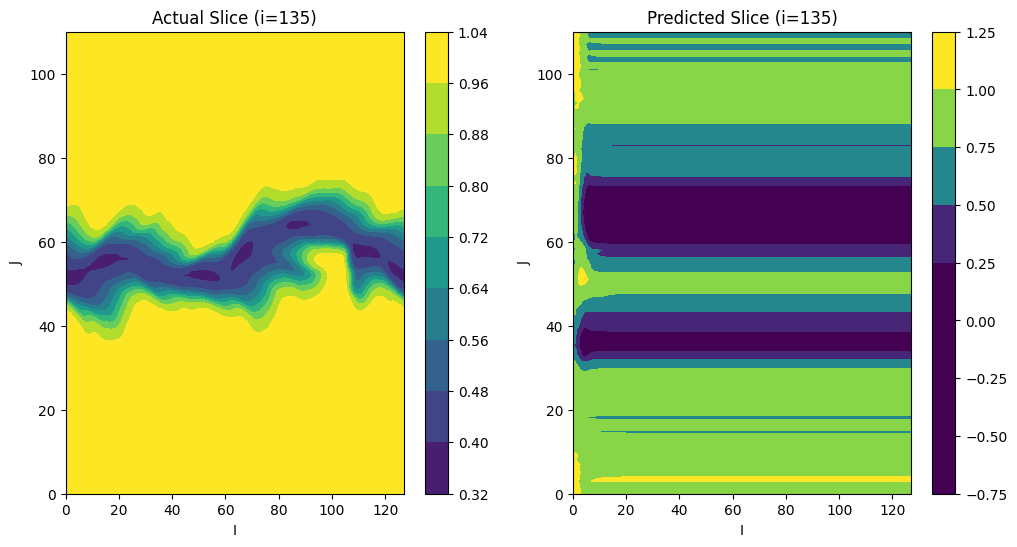

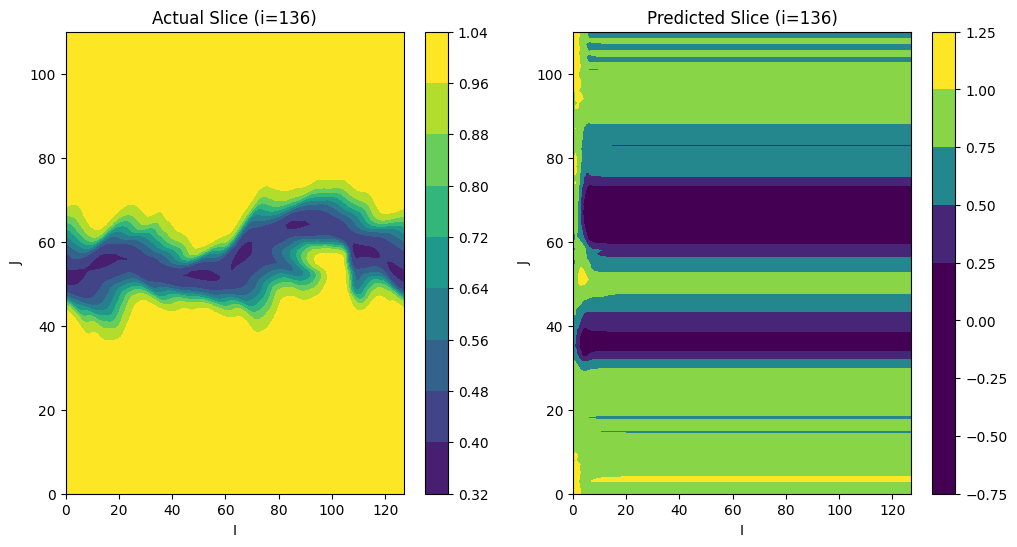

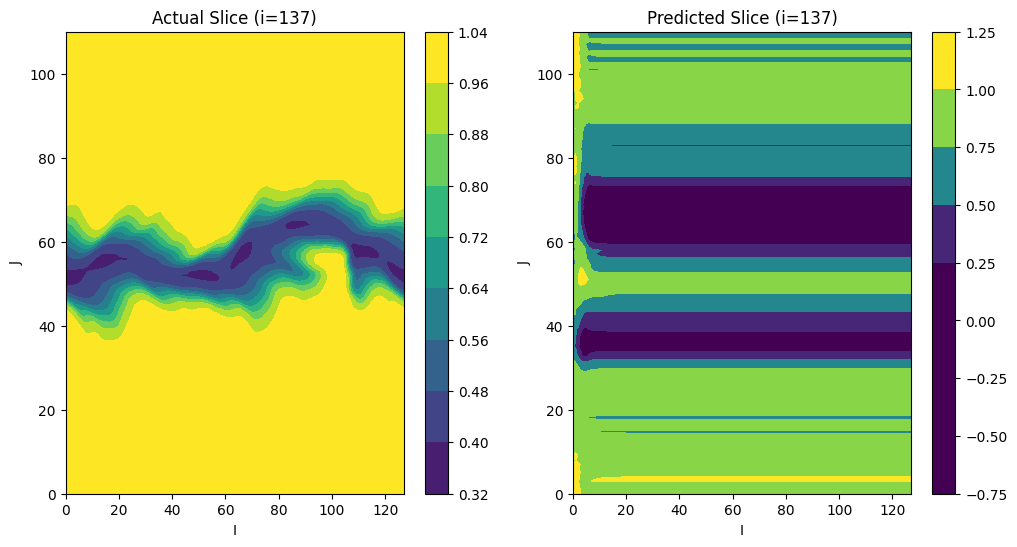

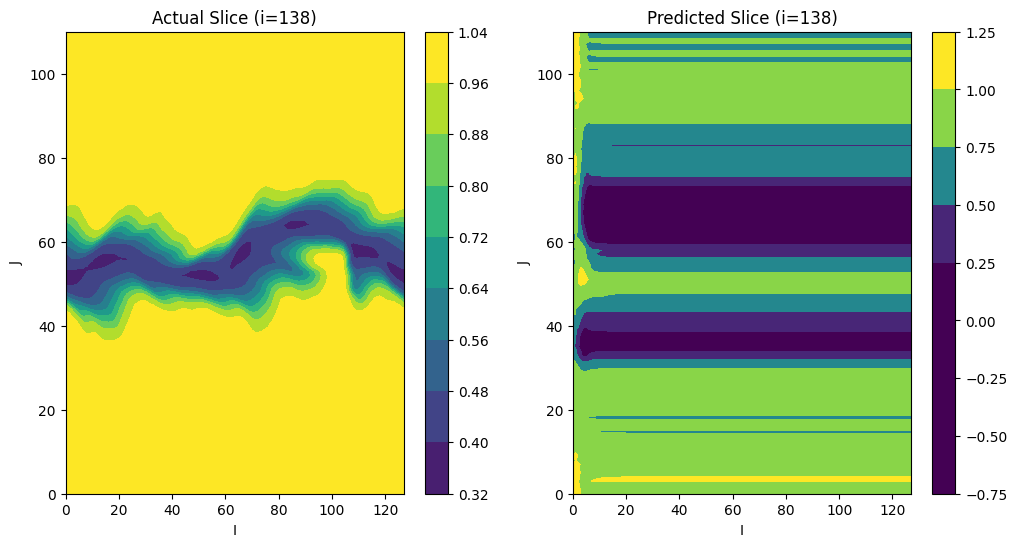

In [16]:
for step in range(val_y.shape[2]):
    val = val_y[:, :, step]
    pred = yhat[:, :, step]
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.contourf(
        np.arange(val.shape[0]),
        np.arange(val.shape[1]),
        val.T,
        cmap="viridis",
        norm=norm,
    )
    plt.title(f"Actual Slice (i={step})")
    plt.colorbar()
    plt.xlabel("I")
    plt.ylabel("J")

    plt.subplot(1, 2, 2)
    plt.contourf(
        np.arange(pred.shape[0]),
        np.arange(pred.shape[1]),
        pred.T,
        cmap="viridis",
        norm=norm,
    )
    plt.title(f"Predicted Slice (i={step})")
    plt.colorbar()
    plt.xlabel("I")
    plt.ylabel("J")

    plt.show()